# Figure overview

## One figure that does a quick run-through of the most important plots from the 10 week figures (i.e. all previous figures) 

1. Figure 1
    - A) Show RBG over time
    - B) Show OGTTs
2. Figure 2
    - C) Show PCA that will likely separate Male vs female
3. Figure 3
    - D) Bar plot of each animal's non-fasted RSDs for all lipids
    - E) Maybe do heatmap plot for each lipid class? 
4. Figure 4 - Machine learning model comparison and feature importance
    - OGTT isn't very wide range here, so skip
5. Figure 5 - Individual metabolite regressions 
    - F) Slope vs slope
    - G) TG unsat vs carbons
6. Figure 6 not currently used
7. New plot: 
    - 3-column heatmap with OGTT correlation to each metabolite for 10wkM, 30wkF, 30wkM

In [26]:
import json
import importlib
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots
from src.plots import plot_quant_vs_ogtt, annotate_point
import importlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import patches, transforms
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns 
import plotly.express as px
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [27]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
vldata_cols = fg.loc[(fg['cohort'] == '30wk') & fg['has_ogtt']].index
qc_rep_1700s = fg.loc[fg['qc_rep']].index

vdata = pd.read_csv('../data/processed/data30wk_lipid_metab.csv', index_col=0)

datad = pd.read_csv('../data/processed/diet_study_lipidomics.csv', index_col=0)
apd = pd.read_csv('../data/metadata/Diet_study_sample_info.csv', index_col=0)

In [28]:
animals = ap.loc[ap['validation'] & (ap['OGTT_age'].notna()) & (ap['cohort'] == '30wk')].index
animals

df = ap.filter(regex='^RBGweek').iloc[:, 6:].loc[animals]
df.columns = [int(x[-2:]) for x in df.columns]
df

new = []
for animal in animals:
    row = df.loc[animal]
    age = ap.loc[animal, 'OGTT_age']
#     print(age)
    weeks_b4_ogtt = [idx - age for idx in row.index]
    row.index = weeks_b4_ogtt
#     display(row)
    new.append(row)
wkdf = pd.DataFrame(new).iloc[:, 1:-3]
wkdf['animal'] = wkdf.index
# wkdf = wkdf.join(ap['sex'])
wkdf
wkdf = wkdf.melt(id_vars='animal', value_vars=wkdf.columns[:-1], 
                 var_name='week', value_name='rbg')
wkdf = wkdf.join(ap['sex'], on='animal' )
wkdf = wkdf.loc[wkdf['week'] > -7 ]
wkdf

,animal,week,rbg,sex
99,1727,-6.0,229.0,M
100,1728,-6.0,241.0,M
101,1731,-6.0,82.0,F
102,1732,-6.0,90.0,M
103,1735,-6.0,83.0,M
...,...,...,...,...
171,1746,0.0,116.0,F
172,1748,0.0,246.5,F
173,1742,0.0,NaN,F
174,1743,0.0,NaN,F


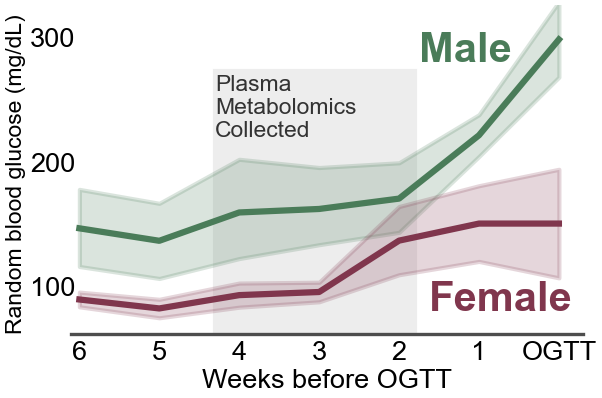

In [4]:
importlib.reload(src.plots)

def rbg_wrapper(ax):
    sns.lineplot(
        data=wkdf, x='week', y='rbg', ax=ax,
        hue='sex', palette=colors, 
        ci=68, n_boot=200, seed=1,
        legend=False,
    )
    ax.axvspan(-4.3, -1.8,  ymax=0.8, color='0.93', zorder=-10)
    # ax.text(-4.45, 297, 'Plasma\nmetabolomics\ncollected', color='0.5', fontsize=5.5, 
    #         ha='right', va='top')
#     ax.text(-4.4, 297, 'Plasma\nmetabolomics\ncollected', color='0.3', fontsize=5.5, 
#             ha='left', va='top')
    ax.text(-4.3, 270, 'Plasma\nMetabolomics\nCollected', fontsize=5.5, color='0.2', ha='left', va='top')
    ax.text(0.86, 0.83, r'Male', color=colors['M'], fontweight='bold', fontsize=10, 
            ha='right', transform=ax.transAxes)
    ax.text(0.98, 0.07, 'Female', color=colors['F'], fontweight='bold', fontsize=10, 
            ha='right', transform=ax.transAxes)

    ax.set_ylabel('Random blood glucose (mg/dL)', fontsize=5.5, loc='bottom', labelpad=1)
    ax.set_xlabel('Weeks before OGTT', fontsize=6.5, labelpad=1)
    ax.set_xticks([-6, -5, -4, -3, -2, -1, 0], ['6', '5', '4', '3', '2', '1', 'OGTT'])
    ax.set_yticks([100, 200, 300])
    ax.set_xlim(left=-6.1)
    ax.set_ylim(top=325)
    ax.tick_params(length=0, labelsize=6.5)
    ax.tick_params(axis='y', pad=-1)
    ax.tick_params(axis='x', pad=1.5)
    ax.set_axisbelow(True)
    # ax.grid(axis='y', lw=src.plots.GRID_LW, ls='-', color=src.plots.GRID_LIGHT_COLOR)

    ax.spines['bottom'].set(lw=0.8*src.plots.SPINE_LW, color='0.3')
    ax.set_xmargin(0.01)
    bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1, s='A', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(ax=ax, left=True)
    
fig, ax = plt.subplots(dpi=300, figsize=(2.2, 1.45))
rbg_wrapper(ax)
# plt.savefig('../reports/figures/Figure7/Fig7A_RBGs_before_OGTT.pdf', bbox_inches='tight', dpi=300)

31.0

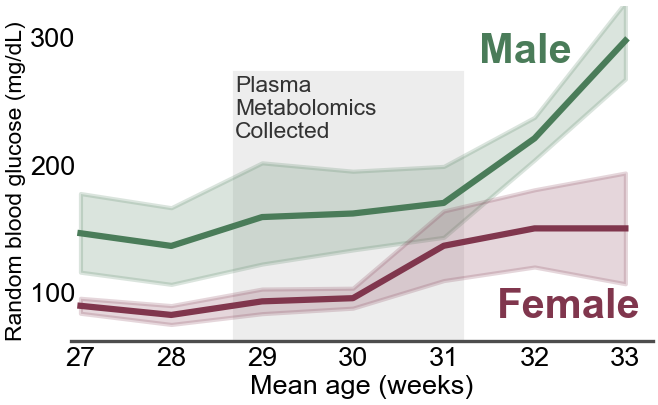

In [8]:
importlib.reload(src.plots)

sampwks = fg.loc[fg['validation'], ['num_wk_before_ogtt', 'week']]
display(sampwks.loc[sampwks['num_wk_before_ogtt'] == 2, 'week'].mean())

def rbg_wrapper_v2(ax):
    sns.lineplot(
        data=wkdf, x='week', y='rbg', ax=ax,
        hue='sex', palette=colors, 
        ci=68, n_boot=200, seed=1,
        legend=False,
    )
    ax.axvspan(-4.3, -1.8,  ymax=0.8, color='0.93', zorder=-10)
    # ax.text(-4.45, 297, 'Plasma\nmetabolomics\ncollected', color='0.5', fontsize=5.5, 
    #         ha='right', va='top')
#     ax.text(-4.4, 297, 'Plasma\nmetabolomics\ncollected', color='0.3', fontsize=5.5, 
#             ha='left', va='top')
    ax.text(-4.3, 270, 'Plasma\nMetabolomics\nCollected', fontsize=5.5, color='0.2', ha='left', va='top')
    ax.text(0.86, 0.83, r'Male', color=colors['M'], fontweight='bold', fontsize=10, 
            ha='right', transform=ax.transAxes)
    ax.text(0.98, 0.07, 'Female', color=colors['F'], fontweight='bold', fontsize=10, 
            ha='right', transform=ax.transAxes)

    ax.set_ylabel('Random blood glucose (mg/dL)', fontsize=5.5, loc='bottom', labelpad=1)
    ax.set_xlabel('Mean age (weeks)', fontsize=6.5, labelpad=1)
    ax.set_xticks([-6, -5, -4, -3, -2, -1, 0], 
#                   ['6', '5', '4', '3', '2', '1', 'OGTT']
                  ['27', '28', '29', '30', '31', '32', '33']
                 )
    ax.set_yticks([100, 200, 300])
    ax.set_xlim(left=-6.1)
    ax.set_ylim(top=325)
    ax.tick_params(length=0, labelsize=6.5)
    ax.tick_params(axis='y', pad=-1)
    ax.tick_params(axis='x', pad=1.5)
    ax.set_axisbelow(True)
    # ax.grid(axis='y', lw=src.plots.GRID_LW, ls='-', color=src.plots.GRID_LIGHT_COLOR)

    ax.spines['bottom'].set(lw=0.8*src.plots.SPINE_LW, color='0.3')
    ax.set_xmargin(0.01)
    bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1, s='A', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(ax=ax, left=True)
    
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 1.45))
rbg_wrapper_v2(ax)
# plt.savefig('../reports/figures/Figure7/Fig7A_RBGs_mean_weeks.pdf', 
#             bbox_inches='tight', dpi=300)

# Repeated measures variance of the 30 week data

## Also, the same features are not being compared, though this may not be bad because different age groups can have different metabolite abundances 

In [29]:
# POLAR METABOLITE RSDs FROM BJA-2.1.2
mrsds = [
    (1727, 38.562890),
    (1728, 33.336125),
    (1731, 15.504138),
    (1732, 31.198330),
    (1735, 22.405632),
    (1741, 22.693006),
    (1742, 25.203626),
    (1743, 26.689934),
    (1746, 27.126147),
    (1748, 20.561506),
    (1754, 15.622290),
]
mrsds = pd.DataFrame(mrsds, columns=['i', 'metab_median_rsd']).set_index('i')
mrsds

,metab_median_rsd
i,
1727,38.562890
1728,33.336125
1731,15.504138
1732,31.198330
1735,22.405632
1741,22.693006
1742,25.203626
1743,26.689934
1746,27.126147


In [30]:
offset = 0.3
wk10pos = 12.2
w10ogtts = ap.loc[ap['original'], 'OGTT (AUC)']
fed_muted = src.plots.adjust_color(colors['Fed'], 0.8)
male_muted = src.plots.adjust_color(colors['M'], 0.8)
female_muted = src.plots.adjust_color(colors['F'], 0.8)

gb = np.power(2, vldata.loc[:, vldata_cols])
gb = (gb
      .T
      .groupby(fg['animal'])
     )
gb = (gb.std() / gb.mean()) * 100
gb['median'] = gb.median(axis=1)
gb.index = gb.index.astype(int)
gb = gb.join(ap[['sex', 'OGTT (AUC)']])
gb['animal'] = gb.index
sdf = gb.groupby('sex').mean()['median']

melt = gb.drop(['OGTT (AUC)', 'median'], axis=1).melt(id_vars=['animal', 'sex'])
order = ap.loc[gb.index, ['Nile rat label', 'sex', 'OGTT (AUC)']].sort_values('Nile rat label')
order['ogtt'] = order['OGTT (AUC)'].round(0).astype('str').str[:-2]
order['label'] = order['Nile rat label'] + '\n[' + order['ogtt'] + ']'
order['median'] = gb.median(axis=1)
order = order.sort_values(['sex', 'median'])
order['x_rsd'] = [0,1,2,3,4,5] + [x + offset for x in [6,7,8,9,10]]

order = order.sort_values(['sex', 'ogtt'])
order['x_ogtt'] = [0,1,2,3,4,5] + [x + offset for x in [6,7,8,9,10]]
order['colors'] = order['sex'].map({'M': male_muted, 'F': female_muted})
order = order.join(mrsds)
order = order.sort_values(['sex', 'metab_median_rsd'])
order['x_polar_metab_rsd'] = [0,1,2,3,4,5] + [x + offset for x in [6,7,8,9,10]] 

order

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Nile rat label,sex,OGTT (AUC),ogtt,label,median,x_rsd,x_ogtt,colors,metab_median_rsd,x_polar_metab_rsd
animal,,,,,,,,,,,
1731,F6,F,686.975000,687,F6\n[687],14.873750,2.0,5.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",15.504138,0.0
1754,F3,F,524.333333,524,F3\n[524],14.477538,1.0,2.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",15.622290,1.0
1748,F5,F,627.500000,628,F5\n[628],16.638058,3.0,4.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",20.561506,2.0
1742,F1,F,429.041667,429,F1\n[429],20.798072,5.0,0.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",25.203626,3.0
1743,F4,F,595.958333,596,F4\n[596],13.168419,0.0,3.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",26.689934,4.0
1746,F2,F,496.416667,496,F2\n[496],19.241205,4.0,1.0,"(0.6850922131147541, 0.28678278688524594, 0.40...",27.126147,5.0
1735,M1,M,601.500000,602,M1\n[602],18.738975,8.3,6.3,"(0.3854797979797978, 0.633270202020202, 0.4598...",22.405632,6.3
1741,M5,M,734.083333,734,M5\n[734],13.871115,7.3,10.3,"(0.3854797979797978, 0.633270202020202, 0.4598...",22.693006,7.3
1732,M2,M,631.000000,631,M2\n[631],13.768446,6.3,7.3,"(0.3854797979797978, 0.633270202020202, 0.4598...",31.198330,8.3


In [31]:
importlib.reload(src.plots)

<module 'src.plots' from 'D:\\nile_rat_multiomics\\notebooks\\..\\src\\plots.py'>

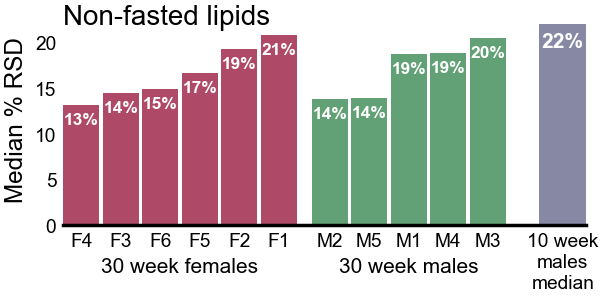

In [32]:
def rsd_wrapper(ax):
    # Plot 30wk median RSDs
    ax.bar(order['x_rsd'], order['median'], color=order['colors'], width=0.91)
    # Plot 10wk median of all Nile rats
    ax.bar([wk10pos], [22], width=1.2, color=fed_muted)

    for i, row in order.iterrows():
        med = row['median']
        ax.text(row['x_rsd'], med-1.6, 
                str(round(med, 0))[:-2] + '%',  
                color='1', fontsize=5, fontweight='bold', 
                ha='center', va='center')
    ax.text(wk10pos, 19.5, '22%', color='1', fontsize=6, fontweight='bold', ha='center')

    # ax.set_xlabel('Nile rat')#\n[OGTT glucose AUC]')
    ax.set_ylabel('Median % RSD', fontsize=7)
#     ax.set_yticks([])
    ax.set_xticks(order['x_rsd'].to_list() + [wk10pos],  
                  order['Nile rat label'].to_list() + ['10 week\nmales\nmedian'])
    # ax.set_xticks([2.5, 8, wk10pos], ['Female', 'Male', '10 wk male\nMedian'], ha='center')
    ax.tick_params(length=0, pad=2, labelsize=5.5)
    ax.text(0, 0.95, 'Non-fasted lipids', fontsize=8, transform=ax.transAxes)
    trans = src.plots.transform_mixed_coordinates(ax)
    ax.text(2.5, -0.15, '30 week females', fontsize=6, ha='center', va='top', transform=trans)
    ax.text(8.3, -0.15, '30 week males', fontsize=6, ha='center', va='top', transform=trans)
    ax.legend([])
    ax.set_xmargin(0)
    ax.spines['bottom'].set_linewidth(src.plots.SPINE_LW)
    bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1*0.94, s='B', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(left=True)

fig, ax = plt.subplots(dpi=250, figsize=(2.7, 1.1))
rsd_wrapper(ax)
# plt.savefig('../reports/figures/Figure7/Fig7B_RSD_barplot.pdf', bbox_inches='tight', dpi=300)

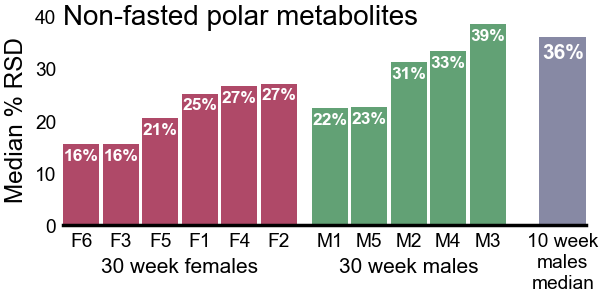

In [1330]:
def rsd_polar_metabs_wrapper(ax):
    # Plot 30wk median RSDs
    ax.bar(order['x_polar_metab_rsd'], order['metab_median_rsd'], 
           color=order['colors'], width=0.91)
    # Plot 10wk median of all Nile rats
    ax.bar([wk10pos], [36], width=1.2, color=fed_muted)

    for i, row in order.iterrows():
        med = row['metab_median_rsd']
        ax.text(row['x_polar_metab_rsd'], med-2.2, 
                str(round(med, 0))[:-2] + '%',  
                color='1', fontsize=5, fontweight='bold', 
                ha='center', va='center')
    ax.text(wk10pos, 32, '36%', color='1', fontsize=6, fontweight='bold', ha='center')

    # ax.set_xlabel('Nile rat')#\n[OGTT glucose AUC]')
    ax.set_ylabel('Median % RSD', fontsize=7)
#     ax.set_yticks([])
    ax.set_xticks(order['x_polar_metab_rsd'].to_list() + [wk10pos],  
                  order['Nile rat label'].to_list() + ['10 week\nmales\nmedian'])
    # ax.set_xticks([2.5, 8, wk10pos], ['Female', 'Male', '10 wk male\nMedian'], ha='center')
    ax.tick_params(length=0, pad=2, labelsize=5.5)
    ax.text(0, 0.95, 'Non-fasted polar metabolites', fontsize=8, transform=ax.transAxes)
    trans = src.plots.transform_mixed_coordinates(ax)
    ax.text(2.5, -0.15, '30 week females', fontsize=6, ha='center', va='top', transform=trans)
    ax.text(8.3, -0.15, '30 week males', fontsize=6, ha='center', va='top', transform=trans)
    ax.legend([])
    ax.set_xmargin(0)
    ax.spines['bottom'].set_linewidth(src.plots.SPINE_LW)
    bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1*0.94, s='B', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(left=True)

fig, ax = plt.subplots(dpi=250, figsize=(2.7, 1.1))
rsd_polar_metabs_wrapper(ax)
# plt.savefig('../reports/figures/Figure7/Fig7_RSD_barplot.pdf', bbox_inches='tight', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


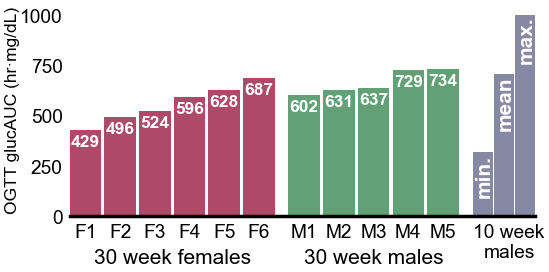

In [1511]:
def ogtt_bar_wrapper(ax):
    ax.bar(order['x_ogtt'], order['OGTT (AUC)'], color=order['colors'], width=0.91)
    for i, row in order.iterrows():
        med = row['OGTT (AUC)']
        ax.text(row['x_ogtt'], med-60, row['ogtt'],  
                color='1', fontsize=5, fontweight='bold', ha='center', va='center')
    
    w10min, w10mean, w10max = w10ogtts.min(), w10ogtts.mean(), w10ogtts.max()
    x_positions = [wk10pos-0.75, wk10pos-0.15, wk10pos+0.45]
    ax.bar(x_positions, [w10min, w10mean, w10max], width=0.57, color=fed_muted)
    for xpos, ypos, text in zip(x_positions, [w10min, w10mean, w10max], ['min.', 'mean', 'max.']):
        ax.text(
            xpos+0.035, ypos - 8, text, 
#             f"{text}={str(round(ypos, 0))[:-2]}", 
            color='1', fontsize=6, fontweight='bold', ha='center', va='top', rotation=90)

    ax.set_ylabel(src.plots.ogtt_gluc_label, fontsize=5, labelpad=0)
    ax.set_xticks(order['x_ogtt'].to_list() + [wk10pos], 
                  order['Nile rat label'].to_list() + ['10 week\nmales'])
#     ax.set_yticks([0, 500, 1000])
    ax.tick_params(length=0, pad=2, labelsize=5.5)
#     ax.grid(axis='y', )
    trans = src.plots.transform_mixed_coordinates(ax)
    ax.text(2.5, -0.15, '30 week females', fontsize=6, ha='center', va='top', transform=trans)
    ax.text(8.3, -0.15, '30 week males', fontsize=6, ha='center', va='top', transform=trans)
    ax.legend().remove()
    ax.set_xmargin(0.0)
    ax.spines['bottom'].set_linewidth(src.plots.SPINE_LW)
#     bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1*0.94, s='B', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(left=True)
    
v1_figure_height = 1.1
fig, ax = plt.subplots(dpi=250, figsize=(2.4, v1_figure_height))
ogtt_bar_wrapper(ax)
# plt.savefig('../reports/figures/Figure7/Fig7_OGTT_barplot.pdf', bbox_inches='tight', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


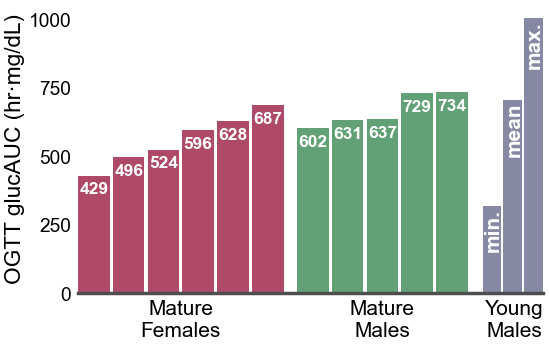

In [1513]:
def ogtt_bar_wrapper_v2(ax):
    ax.bar(order['x_ogtt'], order['OGTT (AUC)'], color=order['colors'], width=0.91)
    for i, row in order.iterrows():
        med = row['OGTT (AUC)']
        ax.text(row['x_ogtt'], med-50, row['ogtt'],  
                color='1', fontsize=5, fontweight='bold', ha='center', va='center')
    
    w10min, w10mean, w10max = w10ogtts.min(), w10ogtts.mean(), w10ogtts.max()
    x_positions = [wk10pos-0.75, wk10pos-0.15, wk10pos+0.45]
    ax.bar(x_positions, [w10min, w10mean, w10max], width=0.54, color=fed_muted)
    for xpos, ypos, text in zip(x_positions, [w10min, w10mean, w10max], ['min.', 'mean', 'max.']):
        ax.text(
            xpos+0.03, ypos-10, text, 
#             f"{text}={str(round(ypos, 0))[:-2]}", 
            color='1', fontsize=6, fontweight='bold', ha='center', va='top', rotation=90)

    ax.set_ylabel(src.plots.ogtt_gluc_label, fontsize=6.5, labelpad=1)
#     ax.set_xticks(order['x_ogtt'].to_list() + [wk10pos], 
#                   order['Nile rat label'].to_list() + ['10 week\nmales'])
    ax.set_xticks([])
    ax.set_yticks([0, 250, 500, 750, 1000])
    ax.tick_params(length=0, pad=2, labelsize=5.5)
#     ax.grid(axis='y', )
    trans = src.plots.transform_mixed_coordinates(ax)
    ax.text(2.5, -0.02, 'Mature\nFemales', fontsize=6, ha='center', va='top', transform=trans)
    ax.text(8.3, -0.02, 'Mature\nMales', fontsize=6, ha='center', va='top', transform=trans)
    ax.text(12.1, -0.02, 'Young\nMales', fontsize=6, ha='center', va='top', transform=trans)
    
    ax.legend().remove()
    ax.set_xmargin(0.0)
    ax.spines['bottom'].set(lw=src.plots.SPINE_LW, color='0.3')
#     bb = src.plots.tight_bbox(ax)
    # ax.text(x=bb.x0, y=bb.y1*0.94, s='B', 
    #         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
    sns.despine(left=True)
    
fig, ax = plt.subplots(dpi=250, figsize=(2.4, 1.5))
ogtt_bar_wrapper_v2(ax)
plt.savefig('../reports/figures/Figure7/Fig7_OGTT_barplot_v2.pdf', bbox_inches='tight', dpi=300)

# Violin plots

In [33]:
vgb = np.power(2, vdata[vldata_cols]).T.groupby(fg['animal'])
vrsds = ((vgb.std() / vgb.mean()) * 100)
vrsds.index = vrsds.index.astype(int)
vrsds['median_rsd'] = vrsds.median(axis=1)
vrsds = vrsds.join(ap[['sex', 'Nile rat label']])
vrsds = vrsds.sort_values(['sex', 'median_rsd'])

melt = vrsds.melt(id_vars=['sex', 'Nile rat label'], value_vars=vdata.index)

dgb = np.power(2, data[rbg_cols]).T.groupby(fg['animal'])
drsds = ((dgb.std() / dgb.mean()) * 100)
drsds['sex'] = '10wk'
drsds['Nile rat label'] = 'All 10 week\nmales'
dmelt = drsds.melt(id_vars=['sex', 'Nile rat label'])

med10wk = round(dmelt['value'].median(), 1)

melt = melt.append(dmelt)
melt = melt.loc[melt['value'] < 100]
melt

,sex,Nile rat label,variable,value,i
0,F,F4,vl_6,14.134937,NaN
1,F,F3,vl_6,16.589078,NaN
2,F,F6,vl_6,22.950371,NaN
3,F,F5,vl_6,25.439855,NaN
4,F,F2,vl_6,17.424895,NaN
...,...,...,...,...,...
14085,10wk,All 10 week\nmales,NaN,51.533909,l_916
14086,10wk,All 10 week\nmales,NaN,62.792193,l_916
14087,10wk,All 10 week\nmales,NaN,38.184628,l_916
14088,10wk,All 10 week\nmales,NaN,34.610618,l_916


In [1419]:
importlib.reload(src.plots)

<module 'src.plots' from 'D:\\nile_rat_multiomics\\notebooks\\..\\src\\plots.py'>

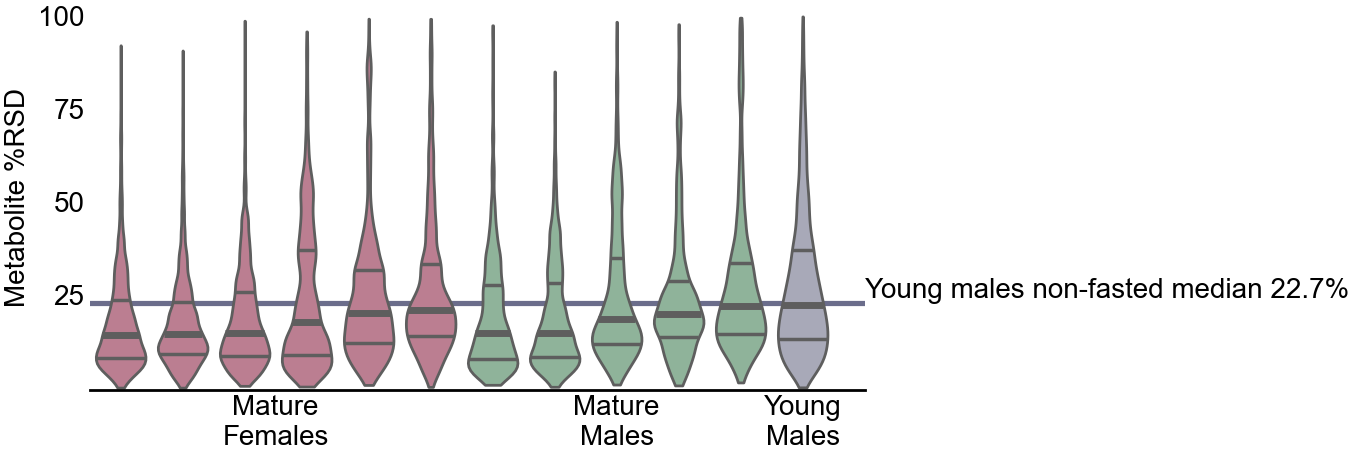

In [12]:
fig, ax = plt.subplots(dpi=250, figsize=(4, 2))

lighter_palette = {
    'M': src.plots.adjust_color(colors['M'], 0.6), 
    'F': src.plots.adjust_color(colors['F'], 0.6),
    '10wk': src.plots.adjust_color(colors['Non-fasted'], 0.6)}

sns.violinplot(
    data=melt, x='Nile rat label', y='value', 
    hue='sex', hue_order=['F', 'M', '10wk'], dodge=False, 
    palette=lighter_palette,
    inner='quartile', cut=0, bw=0.14,
    linewidth=0.8,
)
src.plots.adjust_violin_quartiles(ax=ax, lw=1)
ax.axhline(med10wk, lw=1.5, color=colors['Non-fasted'], zorder=-10, alpha=1)
ax.text(1.0, med10wk, 
#         f'Young males\nnon-fasted\nmedian\n{med10wk}%',
        f'Young males non-fasted median {med10wk}%',
        fontsize=8, ha='left', va='bottom',
        transform=src.plots.transform_mixed_coordinates(ax, True))

ax.set_ylim(-0.5, 103)
ax.set_xlim(right=12)
ax.set_yticks([25, 50, 75, 100])
ax.set_xticks([2.5, 8, 11], ['Mature\nFemales', 'Mature\nMales', 'Young\nMales'])
# xticklabels = [str(x) + '%' for x in list(vrsds['median_rsd'].round(1)) + [med10wk]]
# ax.set_xticks(range(12), xticklabels, fontsize=5)

ax.set_ylabel('Metabolite %RSD')
ax.set_xlabel(None)
ax.tick_params(pad=1.5, length=0, labelsize=8)
ax.legend().remove()
# legend = src.plots.custom_legend(
#     entries=['F', 'M', '10wk'], labels=['Mature female', 'Mature male', 'Young male'], ax=ax,
#     palette=lighter_palette, marker='s', 
#     title='')

sns.despine(left=True)

# plt.savefig('../reports/figures/Figure7/RSD_violin.pdf', dpi=300, bbox_inches='tight')

# Is there a significant difference between all %RSDs from young males and %RSD from mature?
## Is there a signif difference between mature females, mature males, young males? 

In [1576]:
import scipy

In [1602]:
frsds = melt.loc[melt['sex'] == 'F', 'value']
mrsds = melt.loc[melt['sex'] == 'M', 'value']
yrsds = melt.loc[melt['sex'] == '10wk', 'value']
print('mature F vs mature M', scipy.stats.kruskal(frsds, mrsds))
print('mature M vs young M', scipy.stats.kruskal(mrsds, yrsds))
print('mature F vs young M ', scipy.stats.kruskal(frsds, yrsds))

mature F vs mature M KruskalResult(statistic=30.784848682055333, pvalue=2.8827993458749788e-08)
mature M vs young M KruskalResult(statistic=222.3427596322071, pvalue=2.788559980372062e-50)
mature F vs young M  KruskalResult(statistic=499.42070919836203, pvalue=1.2706104581486702e-110)


## Write supplemental tables

In [24]:
# vrsds.drop(['median_rsd', 'sex', 'Nile rat label'], axis=1).to_csv('../data/supplemental_tables/validation_rsds.csv')

vsdf = vdata.copy()
vsdf.loc[:, vldata_cols] = np.power(2, vsdf.loc[:, vldata_cols])

vsdf.to_csv('../data/supplemental_tables/validation_data_table.csv')

# PCA plot

In [942]:
startdf = vldata.loc[:, 
#     vldata['ID'] != 'Unidentified', 
    vldata_cols].T
scaled = pd.DataFrame(StandardScaler().fit_transform(startdf), index=startdf.index, columns=startdf.columns)
pca_object = PCA(n_components=5).fit(scaled)
pca = pca_object.transform(scaled)
pc_columns = [f'pc{x}' for x in range(1, pca_object.n_components+1)]
pca = pd.DataFrame(pca, index=startdf.index, columns=pc_columns)
pca = pca.join(fg[['animal', 'week', 'ogtt', 'sex', 'num_wk_before_ogtt']])
pca['animal'] = pca['animal'].astype('str')
# pca = pca.rename({'bg_type': 'Sampling'}, axis=1)
# pca['Sampling'] = pca['Sampling'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_), 
                        index=startdf.columns, columns=pc_columns)
loadings['pc1_rank'] = loadings['pc1'].abs().rank(ascending=False)
loadings['pc2_rank'] = loadings['pc2'].abs().rank(ascending=False)
loadings = loadings.join(vldata[['ID', 'fa_carbons', 'fa_unsat', 'superclass', 'molec_class']])
# loadings.sort_values('pc1_rank').iloc[60:120]
# loadings
# pca

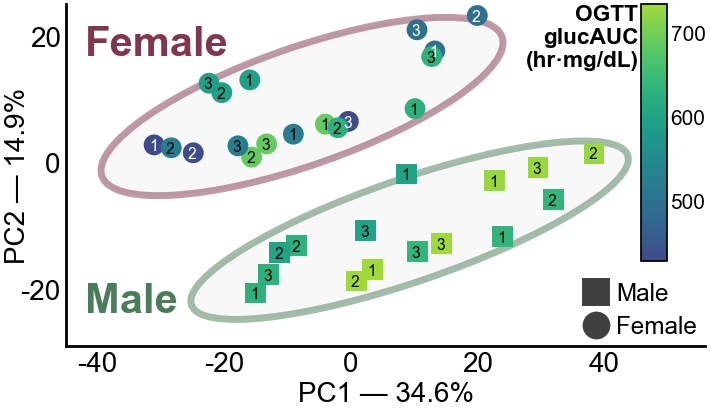

In [766]:
importlib.reload(src.plots)
vminclip, vmaxclip = w10ogtts.min(), w10ogtts.max()-200
def pca_plot(ax=None):
    x, y = 'pc1', 'pc2'
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)
    sns.scatterplot(
        data=pca, x=x, y=y, ax=ax,
        hue='ogtt', palette='viridis', hue_norm=(vminclip, vmaxclip),
#         size='num_wk_before_ogtt', sizes={2: 20, 3: 30, 4:40},
        style='sex', markers={'M': 's', 'F': 'o'}, 
#         style='num_wk_before_ogtt', markers={2: '^', 3: 's', 4: 'p'},
#         style='num_wk_before_ogtt',
#         hue='animal', palette='tab10', 
        legend=False, 
        alpha=1, linewidth=0, edgecolor='0.15',)
    for i, row in pca.iterrows():
        order_dict = {4: 1, 3: 2, 2: 3}
        text = order_dict[row['num_wk_before_ogtt']]
        ax.text(row[x]-0.15, row[y] - 0.2, text, fontsize=4.5, 
                va='center', ha='center', color=('white' if row['ogtt'] < 520 else 'black'))
    ax.set_xlabel(f'PC1 — {round(100*pca_object.explained_variance_ratio_[0], 1)}%', fontsize=8, labelpad=1) 
    ax.set_ylabel(f'PC2 — {round(100*pca_object.explained_variance_ratio_[1], 1)}%', fontsize=8, labelpad=-3) 
    ax.set_xlim(-45, 56)
    ax.set_ylim(-29, 25)
    ax.tick_params(labelsize=8, length=0, pad=1.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(20))
    ax.yaxis.set_major_locator(plt.MultipleLocator(20))
    ax.set_aspect('equal')
    ax.text(0.03, 0.1, 'Male', color=colors['M'], fontweight='bold', fontsize=12, ha='left', transform=ax.transAxes)
    ax.text(0.03, 0.85, 'Female', color=colors['F'], fontweight='bold', fontsize=12, ha='left', transform=ax.transAxes)
    for sex in ['M', 'F']:
        df = pca.loc[pca['sex'] == sex]
        ci_ellipse = src.plots.make_ci(
            x=df[x], y=df[y],            
            edgecolor=colors[sex], facecolor=(0.95, 0.95, 0.95),
            linewidth=2, alpha=0.5, zorder=0, )
        ax.add_artist(ci_ellipse)
    cbar, cax = src.plots.custom_colorbar(
        ax, 
#         vmin=pca['ogtt'].min(), vmax=pca['ogtt'].max(),
        vmin=vminclip, vmax=vmaxclip,
        bbox=[0.9, 0.25, 0.04, 0.75], edgewidth=0.5, debug_rect=False)
    cax.text(x=-0.12, y=1, s=f'OGTT\nglucAUC\n{src.plots.ogtt_gluc_label[-10:]}', 
             ha='right', va='top', fontsize=6.5, fontweight='bold', transform=cax.transAxes)
    cax.set_ylim(pca['ogtt'].min(), pca['ogtt'].max())
#     cax.set_ylim(vminclip, vmaxclip)
    cax.tick_params(pad=1, length=0)
    legend = src.plots.custom_legend(loc=(0.8, 0.01), fontsize=7,
        ax=ax, entries=['Male', 'Female'], marker=['s', 'o'], mew=0,
        palette={'Male': '0.25', 'Female': '0.25'})
#     ax.legend(loc=(1.01, 0))
    sns.despine(ax=ax)
    return ax, cbar, cax
fig, ax = plt.subplots(dpi=250, figsize=(3.3, 2.8))
ax, cbar, cax = pca_plot(ax)
# plt.savefig('../reports/figures/Figure7/PCA_MvsF.pdf', dpi=300, bbox_inches='tight')

# Futzing with machine learning
## Conclusions: 
- PLSr pulls out TGs, 
- SVR with radial kernel can get the best CV scores (R2 = 0.45) 
- Most other models get about R2=0.25  at best

In [933]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector, SelectFwe, RFE

rkf = RepeatedKFold(n_splits=5, n_repeats=150, random_state=42)
Xid = scaled.loc[:, vldata['ID'] != 'Unidentified']
y = fg.loc[Xid.index, 'ogtt']

In [921]:
rfecv = RFECV(
    estimator=SVR(kernel='linear', C=100),
    step=0.1, min_features_to_select=20, 
    cv=rkf, n_jobs=7,
).fit(X=Xid, y=y)
# rfecv.cv_results_['split0_test_scor']
rfecv.cv_results_

{'mean_test_score': array([-0.21351059, -0.12681979, -0.04638229, -0.05114394, -0.02076755,
        -0.00425489,  0.01012319,  0.02049125,  0.02483458,  0.02654534,
         0.02695527]),
 'std_test_score': array([1.30234665, 1.20526714, 1.04360602, 1.05293342, 0.98549239,
        0.97300829, 0.95968612, 0.93891597, 0.93448978, 0.93169211,
        0.93111506]),
 'split0_test_score': array([0.47021966, 0.54170506, 0.62831455, 0.6521213 , 0.62893985,
        0.60663646, 0.58349438, 0.58333339, 0.57581033, 0.57767364,
        0.57758968]),
 'split1_test_score': array([0.16461837, 0.44786761, 0.26681903, 0.17167856, 0.11698241,
        0.13395636, 0.14463456, 0.20843538, 0.23348783, 0.2461165 ,
        0.24111864]),
 'split2_test_score': array([-0.19817726, -0.163781  , -0.54027672, -0.39793533, -0.36949546,
        -0.315735  , -0.22037957, -0.21159396, -0.22915664, -0.2358088 ,
        -0.23500919]),
 'split3_test_score': array([-0.17022167, -0.25619642,  0.13702156, -0.00743856,  0.0769

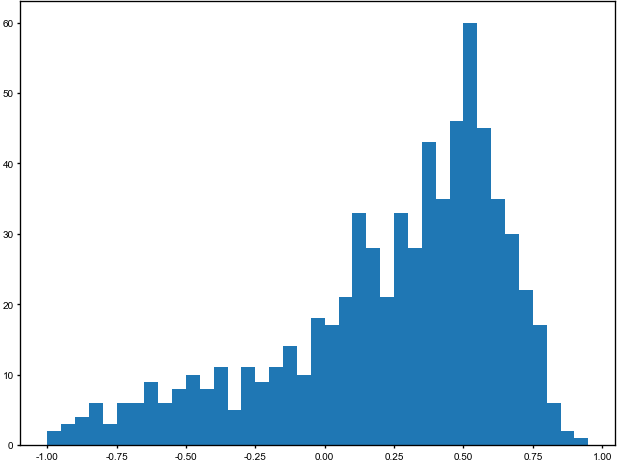

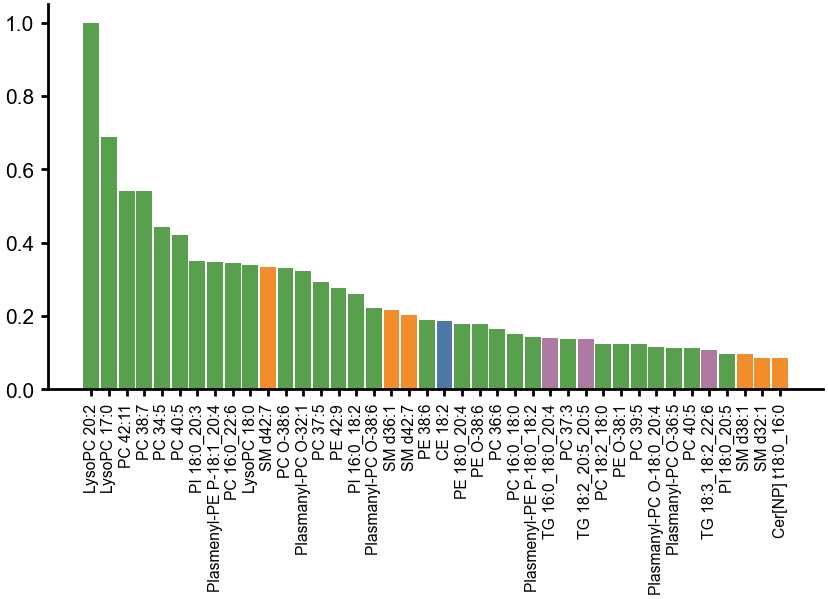

In [941]:
cv = cross_validate(
    estimator=ElasticNet(alpha=0.01, l1_ratio=.99),
    X=Xid, y=y,
    cv=rkf,
    n_jobs=7, return_estimator=True,
)

plt.hist(cv['test_score'], bins=np.arange(-1, 1, 0.05))
np.median(cv['test_score'])

coefs = [estimator.coef_ for estimator in cv['estimator']]
# cv['estimator'][0].coef_
coefs = np.sum(np.stack(coefs), axis=0)
coefs = pd.DataFrame(coefs.T, index=cv['estimator'][0].feature_names_in_, columns=['coef'])
coefs['absnorm'] = coefs['coef'].abs().div(coefs['coef'].max())
coefs = coefs.join(vldata[['ID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat']])
coefs['color'] = coefs['superclass'].map(colors)
coefs = coefs.sort_values('absnorm', ascending=False)
coefs['x'] = range(len(coefs))
coefs

fig, ax = plt.subplots(dpi=250, figsize=(4, 2))
subset = coefs.iloc[:40]
ax.bar(
    data=subset, x='x', height='absnorm', color='color', width=0.9
)
ax.set_xticks(subset['x'], subset['ID'], rotation=90, fontsize=4.5)
sns.despine()

In [939]:
# cv = cross_validate(
#     estimator=PLSRegression(),
#     X=scaled.loc[:, vldata['ID']!='Unidentified'], y=fg.loc[scaled.index, 'ogtt'], 
#     cv=RepeatedKFold(n_splits=4, n_repeats=200, random_state=42),
#     n_jobs=7, return_estimator=True,
# )

# plt.hist(cv['test_score'], bins=np.arange(-1, 1, 0.05))
# np.median(cv['test_score'])

# Combine wrappers

In [166]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(
#     nrows=4, figsize=(2.2, 7), dpi=250, 
#     gridspec_kw=dict(hspace=0.25, height_ratios=[0.8, 0.5, 0.5, 1]))
# rbg_wrapper(ax1)
# rsd_wrapper(ax2)
# ogtt_bar_wrapper(ax3)
# pca_plot(ax4)

# Do mixed-effects differences between male and female

In [34]:
# Save time by reading in the saved csv
mer = pd.read_csv('../data/processed/male_vs_female_mixed_effects_results.csv', index_col=0)

# ## Running all mixed effects models takes about 2 minutes 
# medata = vdata[vldata_cols].T.join(fg[['animal', 'sex']])

# me_results = {}
# for feature in vdata.index:
#     mlm = smf.mixedlm(f'{feature} ~ sex', groups='animal', data=medata).fit()
#     me_results[feature] = {'pval_sex': mlm.pvalues['sex[T.M]'], 
#                            'pval_animalvar': mlm.pvalues['animal Var']}
# mer = pd.DataFrame(me_results).T
# mer['qval_sex'] = fdrcorrection(mer['pval_sex'])[1]
# mer['pval_animalvar'].replace(np.nan, 1, inplace=True)
# mer['qval_animalvar'] = fdrcorrection(mer['pval_animalvar'])[1]
# mer['qval_sex'].hist(bins=20)
# mer = mer.join(vdata[['ID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat', 
#                        'RT', 'm/z']])
# mer['signif_sex'] = mer['qval_sex'] < 0.05
# mer['logqvalsex'] = -np.log10(mer['qval_sex'])
# log2fc = vdata[vldata_cols].T.groupby(fg['sex']).mean().diff().iloc[1]
# log2fc.name = 'log2fcM-F'
# mer = mer.join(log2fc)
# mer = mer.sort_values('superclass', ascending=False)
# mer['i'] = mer.index

# ###### Write mixed effects to csv ##########
# mer.to_csv('../data/processed/male_vs_female_mixed_effects_results.csv')

In [46]:
mer['num'] = mer.index.str.split('_').str[-1].astype('int')
mer['index'] = mer.index
mer['Type'] = mer['index'].str.contains('l')
mer = mer.sort_values(['Type', 'num'], ascending=[False, True])
# mer[['log2fcM-F', 'pval_sex', 'qval_sex']].to_clipboard()

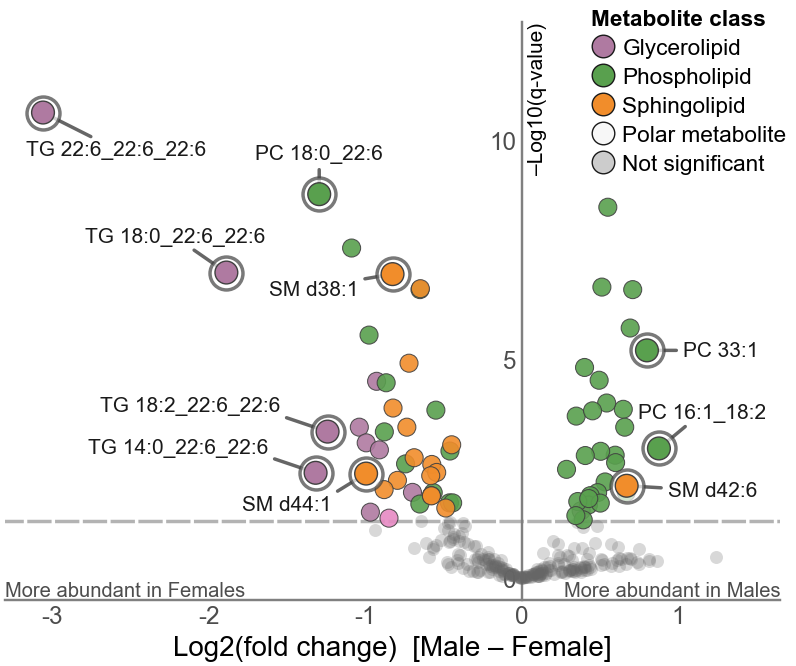

In [35]:
cutoff = -np.log10(0.05)
fccutoff = 0.0
mer['interesting'] = ((mer['ID'] != 'Unidentified') &
                      (mer['log2fcM-F'].abs() > fccutoff) &
                      (mer['logqvalsex'] > cutoff))

x, y = 'log2fcM-F', 'logqvalsex'
fig, ax = plt.subplots(dpi=250, figsize=(4, 3))

# ax.plot([-5, -fccutoff, -fccutoff, None, fccutoff, fccutoff, 7], 
#         [cutoff, cutoff, 20, None, 20, cutoff, cutoff],
#         zorder=-2, color='0.7', linestyle=(0, (7, 1)), lw=1)
ax.plot([-5, 5], [cutoff, cutoff], zorder=-2, color='0.7', linestyle=(0, (7, 1)), lw=1)

hl = {
      # 'vl_3074': dict(x=0, y=-10),  # UnID top
      'vl_4879': dict(x=-1, y=-9, ha='left'),  # TG 22:6 22:6 22:6
      'vl_3073': dict(x=0, y=8),  #PC 18:0 22:6
      'vl_5485': dict(x=-3, y=7),  # TG 18:0 22:6 22:6
      'vl_3744': dict(x=-2, y=-3, ha='right', relpos=(1, 1)),   # SM 38:1
      'vl_5071': dict(x=-8, y=5, fontsize=6, relpos=(1, 0)),  # TG 14:0 22:6 22:6
      'vl_5101': dict(x=-8, y=5, fontsize=6, relpos=(1, 0)),  # TG 18:2 22:6 22:6
      'vl_4905': dict(x=-2, y=-6, ha='right', relpos=(1, 1)),  # sm 44:1
      
#       'vl_5993': dict(x=2, y=8, ha='right'),  # UnID far right
      'vl_2379': dict(x=2.5, y=7),  # PC 16:1_18:2
      'vl_3007': dict(x=4.3, y=0),  # PC 33:1
      'vl_2597': dict(x=5, y=-1), # SM 42:6
    }
mer['outlier'] = mer['i'].isin(hl)
mer = mer.sort_values('superclass')
subset = mer.loc[mer['interesting'] & ~mer['outlier']]
sns.scatterplot(
    data=subset, x=x, y=y, hue='superclass', palette=colors,
    size='interesting', sizes={True: 27, 'False': 10},
    linewidth=0.3, ec='0.25', alpha=0.9, zorder=4,)
subset = mer.loc[(mer['interesting'] == False) & (mer['ID'] != 'Unidentified')]
sns.scatterplot(data=subset, x=x, y=y, zorder=3, alpha=0.25, s=14, linewidth=0, color='0.4')
subset = mer.loc[mer['outlier']]
sns.scatterplot(data=subset, x=x, y=y, hue='superclass', palette=colors, s=43, zorder=9, 
    linewidth=0.4, ec='0.25', legend=False,)

for i, d in hl.items():
    row = mer.loc[i]
    if row['ID'] == 'Unidentified':
        text = f'RT {round(row.RT, 2)} min\nm/z {round(row["m/z"], 3)}'
    elif 'text' in d:
        text = d.pop('text')
    else: text = row['ID']
    xloc, yloc = d.pop('x'), d.pop('y')
    src.plots.annotate_point(
        xy=(row[x], row[y]), text=text, xytext=(xloc, yloc), ax=ax, color='0.4', **d,)

ax.set(xlim=[-3.3, 1.65], ylim=[-0.5, 12.7], xlabel='Log2(fold change)  [Male – Female]', ylabel=None) 

ax.text(0.04, 12.7, '–Log10(q-value)', rotation=90, va='top', ha='left', size=6)
ax.text(ax.get_xlim()[0], -0.5, 'More abundant in Females', fontsize=5.8, c='0.3', va='bottom')
ax.text(ax.get_xlim()[1], -0.5, 'More abundant in Males', fontsize=5.8, c='0.3', va='bottom', ha='right')
# ax.text(-0.5, 14, ha='right', va='top', fontsize=7, 
#     s=f'N={len(mer.loc[mer.signif_sex & (mer.ID != "Unidentified")])} significant\n'
#         'identified\nmetabolites')

ax.tick_params(length=0, pad=1.5, labelsize=7, labelcolor='0.3')
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.spines.left.set_position('zero')
ax.spines[:].set_color('0.5')
ax.spines[:].set_lw(0.7)
colors['Not significant'] = '0.8'
colors['Polar metabolite'] = '0.97' #colors['Organic acid']
legend = src.plots.custom_legend(ax=ax, palette=colors, loc=(0.75, 0.73),
    entries=['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Polar metabolite', 'Not significant'],
    title='Metabolite class', title_fontsize=6.5, fontsize=6.5, ms=6.5, mew=0.4, 
    show_frame=False, frame_edgewidth=0, frame_edgecolor='0.3')
sns.despine()
# plt.savefig('../reports/figures/Figure7/male-vs-female-volcano_with_metabs.pdf', 
#             bbox_inches='tight', dpi=300, pad_inches=0)

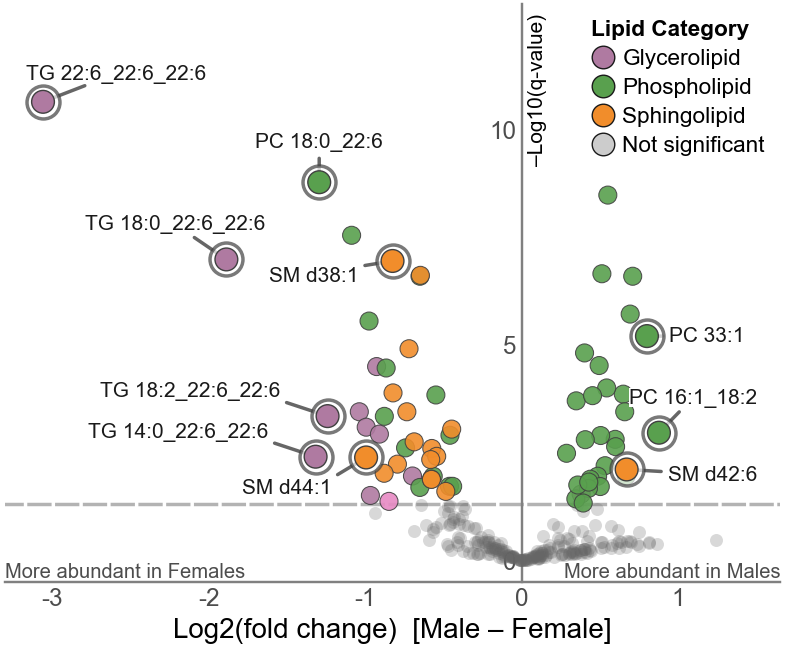

In [1625]:
cutoff = -np.log10(0.05)
fccutoff = 0.0
mer['interesting'] = ((mer['ID'] != 'Unidentified') &
                      (mer['log2fcM-F'].abs() > fccutoff) &
                      (mer['logqvalsex'] > cutoff))

x, y = 'log2fcM-F', 'logqvalsex'
fig, ax = plt.subplots(dpi=250, figsize=(4, 3))

# ax.plot([-5, -fccutoff, -fccutoff, None, fccutoff, fccutoff, 7], 
#         [cutoff, cutoff, 20, None, 20, cutoff, cutoff],
#         zorder=-2, color='0.7', linestyle=(0, (7, 1)), lw=1)
ax.plot([-5, 5], [cutoff, cutoff], zorder=-2, color='0.7', linestyle=(0, (7, 1)), lw=1)

hl = {
      # 'vl_3074': dict(x=0, y=-10),  # UnID top
      'vl_4879': dict(x=-1, y=7, ha='left'),  # TG 22:6 22:6 22:6
      'vl_3073': dict(x=0, y=8),  #PC 18:0 22:6
      'vl_5485': dict(x=-3, y=7),  # TG 18:0 22:6 22:6
      'vl_3744': dict(x=-2, y=-3, ha='right', relpos=(1, 1)),   # SM 38:1
      'vl_5071': dict(x=-8, y=5, fontsize=6, relpos=(1, 0)),  # TG 14:0 22:6 22:6
      'vl_5101': dict(x=-8, y=5, fontsize=6, relpos=(1, 0)),  # TG 18:2 22:6 22:6
      'vl_4905': dict(x=-2, y=-6, ha='right', relpos=(1, 1)),  # sm 44:1
      
#       'vl_5993': dict(x=2, y=8, ha='right'),  # UnID far right
      'vl_2379': dict(x=2, y=7),  # PC 16:1_18:2
      'vl_3007': dict(x=3.5, y=0),  # PC 33:1
      'vl_2597': dict(x=5, y=-1), # SM 42:6
}
mer['outlier'] = mer['i'].isin(hl)
mer = mer.sort_values('superclass')
subset = mer.loc[mer['interesting'] & ~mer['outlier']]
sns.scatterplot(
    data=subset, x=x, y=y, hue='superclass', palette=colors,
    size='interesting', sizes={True: 27, 'False': 10},
    linewidth=0.3, ec='0.25', alpha=0.9, zorder=4,)
subset = mer.loc[(mer['interesting'] == False) & (mer['ID'] != 'Unidentified')]
sns.scatterplot(data=subset, x=x, y=y, zorder=3, alpha=0.25, s=14, linewidth=0, color='0.4')
subset = mer.loc[mer['outlier']]
sns.scatterplot(data=subset, x=x, y=y, hue='superclass', palette=colors, s=43, zorder=9, 
    linewidth=0.4, ec='0.25', legend=False,)

for i, d in hl.items():
    row = mer.loc[i]
    if row['ID'] == 'Unidentified':
        text = f'RT {round(row.RT, 2)} min\nm/z {round(row["m/z"], 3)}'
    else: text = row['ID']
    xloc, yloc = d.pop('x'), d.pop('y')
    src.plots.annotate_point(
        xy=(row[x], row[y]), text=text, xytext=(xloc, yloc), ax=ax, color='0.4', **d,)

ax.set(xlim=[-3.3, 1.65], ylim=[-0.5, 12.9], xlabel='Log2(fold change)  [Male – Female]', ylabel=None) # xlim=[-3.4, 5.2]

ax.text(0.04, 12.7, '–Log10(q-value)', rotation=90, va='top', ha='left', size=6)
ax.text(ax.get_xlim()[0], -0.5, 'More abundant in Females', fontsize=5.8, c='0.3', va='bottom')
ax.text(ax.get_xlim()[1], -0.5, 'More abundant in Males', fontsize=5.8, c='0.3', va='bottom', ha='right')
# ax.text(-0.5, 14, ha='right', va='top', fontsize=7, 
#     s=f'N={len(mer.loc[mer.signif_sex & (mer.ID != "Unidentified")])} significant\n'
#         'identified\nmetabolites')

ax.tick_params(length=0, pad=1.5, labelsize=7, labelcolor='0.3')
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.spines.left.set_position('zero')
ax.spines[:].set_color('0.5')
ax.spines[:].set_lw(0.7)
colors['Not significant'] = '0.8'
legend = src.plots.custom_legend(ax=ax, palette=colors, loc=(0.75, 0.73),
    entries=['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Not significant'],
    title='Lipid Category', title_fontsize=6.5, fontsize=6.5, ms=6.5, mew=0.4, 
    show_frame=False, frame_edgewidth=0, frame_edgecolor='0.3')
sns.despine()
# plt.savefig('../reports/figures/Figure7/male-vs-female-volcano_v2.pdf', bbox_inches='tight', dpi=300)

# do a week-by-week volcano plot for the 3 sampling plots, male vs female


In [1208]:
(vldata
 .loc[vldata['ID'] != 'Unidentified', vldata_cols]
 .T
 .join(fg[['sex']])#, 'num_wk_before_ogtt']])
 .groupby(['sex'])#, 'num_wk_before_ogtt'])
 .mean()
)

,vl_946,vl_948,vl_1056,vl_1123,vl_1974,vl_2018,vl_2027,vl_2070,vl_2079,vl_2110,...,vl_6343,vl_6379,vl_6391,vl_6395,vl_6396,vl_6431,vl_6436,vl_6454,vl_6458,vl_6461
sex,,,,,,,,,,,,,,,,,,,,,
F,21.780947,23.720063,30.015325,20.482911,21.198285,21.790560,21.605310,22.419579,26.123469,25.437284,...,22.499190,21.934970,26.884317,23.205023,25.955480,21.536346,21.561627,23.859820,22.524635,23.378083
M,22.187253,24.270318,29.467391,20.995318,20.633388,21.781729,21.546771,21.554092,26.723415,25.670301,...,22.896007,22.747038,27.203745,23.828218,26.276858,22.284850,22.132578,24.466861,23.190622,24.075106


In [1261]:
from scipy.stats import ttest_ind
ttdf = vldata.loc[vldata['ID'] != 'Unidentified'].copy()
subfg = fg.loc[fg['validation'] & (fg['cohort']=='30wk') & fg['quant_file']]

for wk in [2, 3, 4]:

    m_cols = subfg.loc[(subfg['sex'] == 'M') & (subfg['num_wk_before_ogtt'] == wk)].index
    f_cols = subfg.loc[(subfg['sex'] == 'F') & (subfg['num_wk_before_ogtt'] == wk)].index

    tt = ttdf.apply(lambda x: ttest_ind(x[m_cols].values, x[f_cols].values)[1], axis=1)
    
    ttdf[f'wk{wk}_ttest_pval'] = tt
    ttdf[f'wk{wk}_ttest_logqval'] = -1* np.log10(fdrcorrection(tt)[1])
    
    ttdf[f'wk{wk}_MvsF_fc'] = ttdf.apply(lambda x: x[m_cols].mean() - x[f_cols].mean(), axis=1)
ttdf

,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,f30ogttcorr,wk2_ttest_pval,wk2_ttest_logqval,wk2_MvsF_fc,wk3_ttest_pval,wk3_ttest_logqval,wk3_MvsF_fc,wk4_ttest_pval,wk4_ttest_logqval,wk4_MvsF_fc
vl_946,2.478,548.37488,+,LysoPC 20:2,LysoPC,78,14.662277,14.698737,14.701709,19.368946,...,-0.142857,0.006588,1.347377,0.538173,0.033173,0.846438,0.417078,0.105975,0.508017,0.263668
vl_948,2.496,510.35880,+,LysoPC 17:0,LysoPC,150,14.737479,14.778014,16.514468,21.885525,...,0.371429,0.000355,1.832129,0.656311,0.001749,1.440195,0.448094,0.000610,1.663252,0.546361
vl_1056,3.242,524.37469,+,LysoPC 18:0,LysoPC,163,16.433923,18.908208,20.335865,26.938440,...,0.257143,0.098407,0.555256,-0.364617,0.000887,1.571321,-0.674417,0.002323,1.468110,-0.604769
vl_1123,3.568,550.39099,+,LysoPC 20:1,LysoPC,73,15.191915,15.139724,15.153213,18.636795,...,-0.257143,0.000861,1.655650,0.565481,0.014378,1.015769,0.379324,0.000905,1.550213,0.592418
vl_1974,7.775,852.56415,+,PC 42:11,PC,27,15.202901,15.190675,15.212371,18.528170,...,-0.371429,0.062802,0.692321,-0.419145,0.003152,1.383933,-0.761077,0.027703,0.885547,-0.514469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vl_6431,20.242,977.86035,+,TG 18:2_18:1_23:0,TG,72,16.701427,16.705873,16.712249,20.035100,...,0.314286,0.558382,0.102382,0.441760,0.102980,0.612732,1.293130,0.446264,0.149984,0.510620
vl_6436,20.265,946.88922,+,TG 57:2,TG,66,18.746826,17.733955,18.826365,20.656709,...,0.485714,0.710676,0.054831,0.240944,0.182230,0.483409,0.984185,0.548981,0.119516,0.487725
vl_6454,20.508,934.88812,+,TG 56:1,TG,89,20.269431,20.744248,21.309080,22.776710,...,0.200000,0.509125,0.119692,0.353262,0.107136,0.603251,1.060599,0.413828,0.168824,0.407263
vl_6458,20.537,986.92023,+,TG 18:2_18:1_24:0,TG,78,17.113679,17.271889,17.956024,21.115378,...,0.485714,0.525889,0.110794,0.430295,0.144814,0.538951,1.078589,0.463791,0.144304,0.489079


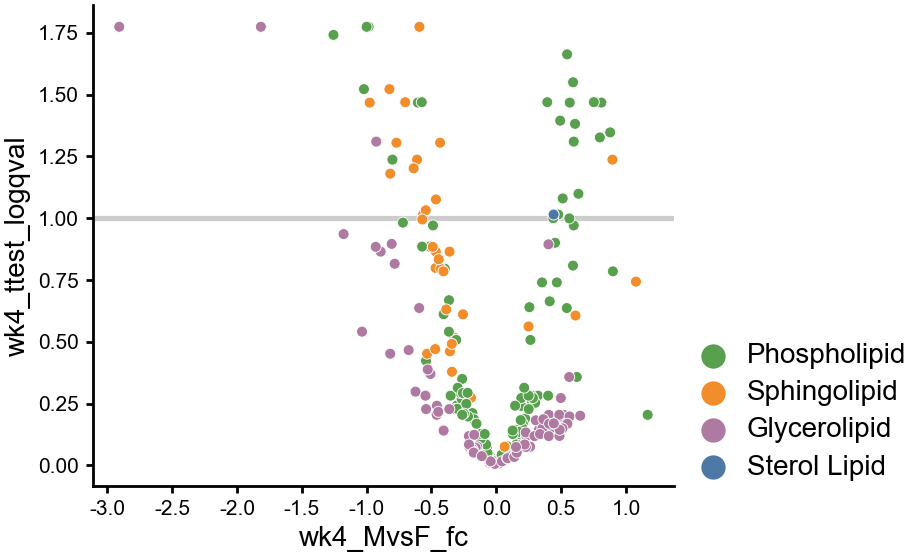

In [1270]:
fig, ax = plt.subplots(dpi=250, figsize=(3, 2.5))
wk = 4
x, y = f'wk{wk}_MvsF_fc', f'wk{wk}_ttest_logqval'
sns.scatterplot(
    data=ttdf, x=x, y=y, hue='superclass', palette=colors, ax=ax,
    s=10
)
ax.axhline(-1*np.log10(0.1), color='0.8', zorder=-2)
ax.legend(loc=(1.01, 0))
sns.despine()

[None, None]

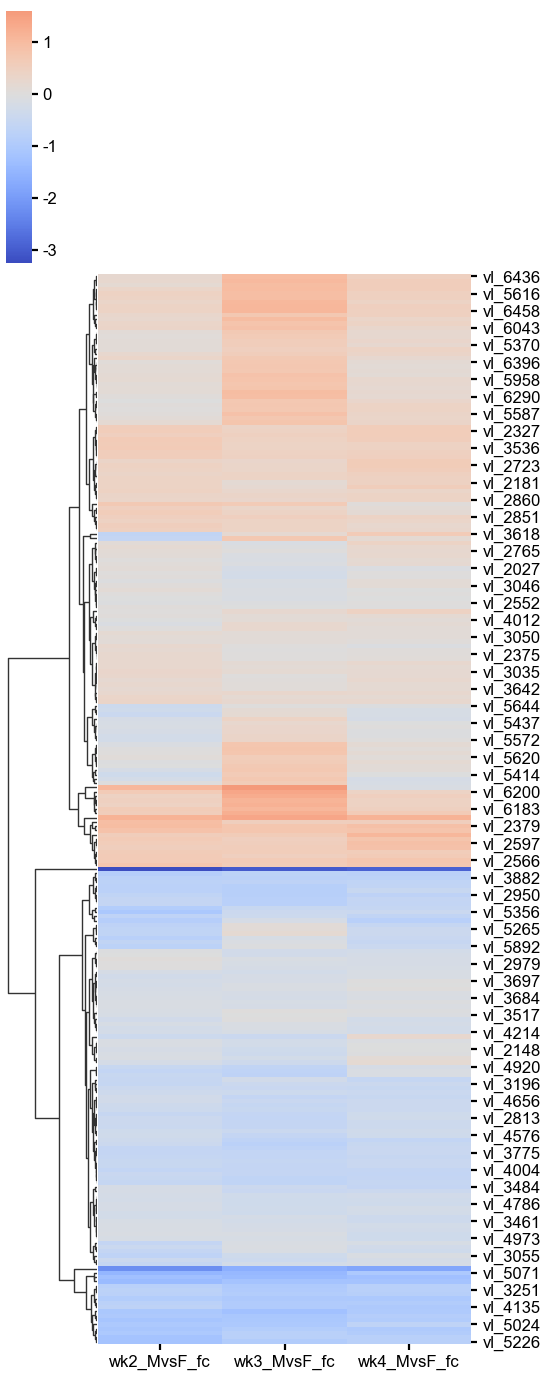

In [1277]:
cm = sns.clustermap(
    data=ttdf[['wk2_MvsF_fc', 'wk3_MvsF_fc', 'wk4_MvsF_fc']], 
    row_cluster=True, col_cluster=False, 
    method='complete', metric='euclidean',
    cmap='coolwarm', center=0,
)
fig, axh = cm.fig, cm.ax_heatmap
fig.set(dpi=200, size_inches=(2.5, 7))

In [1305]:
mdf = vldata[vldata_cols].T.join(fg[['sex', 'animal', 'num_wk_before_ogtt']])
feature = 'vl_1974'

r = {}
for feature in vldata.loc[vldata['ID'] != 'Unidentified'].index:
    lm = smf.mixedlm(f'{feature} ~ num_wk_before_ogtt + sex', # + num_wk_before_ogtt:sex', 
                     groups='animal', data=mdf).fit()
    r[feature] = {'wk_pval': lm.pvalues['num_wk_before_ogtt'], 
                  'sex_pval': lm.pvalues['sex[T.M]'], 
#                   'wk:sex_pval': lm.pvalues['num_wk_before_ogtt:sex[T.M]']
                 }
wkdf = pd.DataFrame(r).T.join(vldata[['ID', 'superclass']])
signif_wk = wkdf.loc[wkdf['wk_pval'] < 0.1]
display(signif_wk)

for feature in signif_wk.index:
    fig, ax = plt.subplots(figsize=(3, 2))
    sns.regplot(data=mdf.loc[mdf['sex'] == 'M'], x='num_wk_before_ogtt', y=feature, ax=ax)
    sns.regplot(data=mdf.loc[mdf['sex'] == 'F'], x='num_wk_before_ogtt', y=feature, ax=ax)

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bjanderson23\AppData\Roaming\Python

In [ ]:
mer['q']

In [951]:
subset = mer.loc[(mer['ID'] != 'Unidentified'), 
        ['ID', 'molec_class', 'pval_sex', 'qval_sex', 'log2fcM-F']]
subset['qval_significant'] = subset['qval_sex'] < 0.05
subset['more_abundant_in_females'] = subset['log2fcM-F'] < 0
# subset.to_csv('../data/processed/female_vs_male_pvals.csv')

In [1098]:
px.scatter(
    mer.loc[mer['interesting']], 
#     mer,
    x='log2fcM-F', y='logqvalsex', hover_data=['i', 'ID', 'superclass', 'RT', 'm/z'], 
    color='superclass', #color_discrete_map=colors,
)

# Pull out interesting OGTT vs quant plots

In [258]:
ap.loc[1735, 'OGTT (AUC)'] * 60

36090.0

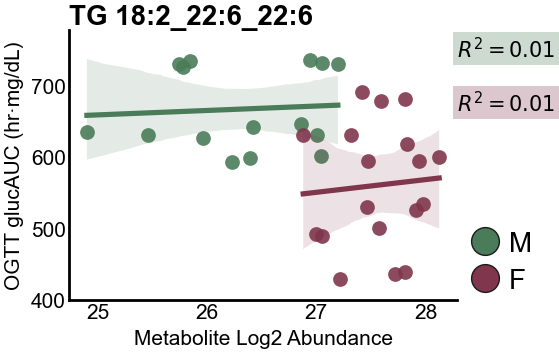

In [437]:
importlib.reload(src.plots)
m_cols = fg.loc[fg['validation'] & (fg['cohort'] == '30wk') * (fg['sex'] == 'M')].index
f_cols = fg.loc[fg['validation'] & (fg['cohort'] == '30wk') * (fg['sex'] == 'F')].index

f = 'vl_2597'  # Sm 42:6
f = 'vl_4879'  # TG 22:6 22:6 22:6
f = 'vl_5485'  # TG 18:0 22:6 22:6
f = 'vl_3073'
f = 'vl_2379'
f = 'vl_6068'
f = 'vl_5101'  # TG 18:2 22:6 22:6

ax = src.plots.plot_ogtt_vs_quant(
    df=vldata, feature=f, group_names=['M', 'F'], df_cols=vldata_cols, 
#     group_within_animal=True,
    legend=False,
    group_cols=[m_cols, f_cols],# ax=ax,
)
ax.yaxis.set_major_locator(plt.MultipleLocator(100))
ax.set_ylim(400, 777)
src.plots.custom_legend(
    ax=ax, entries=['M', 'F']
)

# Step 1: Find all non-sumcomp lipids that are in both datasets:
## Some of the sum composition IDs have duplicates so just drop them
## `nonsc_both` is a lookup table of all lipids with their indexes that are not sum composition and are found in both datasets

## nonsc = Not Sum Composition 

In [973]:
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
data['shortID'] = data['molec_class'] + ' ' + data['fa_carbon:unsat']
vldata['shortID'] = vldata['molec_class'] + ' ' + vldata['fa_carbon:unsat']

# olid = Original Lipid IDs
olid = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')] 
# data lacks an 'is_sum_comp' column
olid['is_sum_comp'] = olid['ID'].apply(lambda x: src.utils.parse_lipid(x)[-1])

# vlid = Validation Lipid IDs
vlid = vldata.loc[(vldata['Type'] == 'lipid') & (vldata['ID'] != 'Unidentified')] 
vlid['is_sum_comp'] = vlid['is_sum_comp'].astype(bool)

dfs = [olid, vlid]

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [974]:
nonsc = [
    olid.loc[~olid['is_sum_comp']].copy().drop_duplicates(subset='ID', keep=False),
    vlid.loc[~vlid['is_sum_comp']].copy().drop_duplicates(subset='ID', keep=False),
]

nonsc_both = {}
df0 = nonsc[0]
df1 = nonsc[1]
for df0_i, row in nonsc[0].iterrows():
    rowid = row['ID']
    if rowid in df1['ID'].to_list():
        df1_i = df1.loc[df1['ID'] == row['ID']].index[0]
        nonsc_both[rowid] = {'o': df0_i, 'v': df1_i}
        
        # Find the other lipids in each dataframe that have same shortID
        df0_others = df0.loc[df0['shortID'] == df0.loc[df0_i, 'shortID']]
        df1_others = df1.loc[df1['shortID'] == df1.loc[df1_i, 'shortID']]
        
        if len(df0_others) > 1:
            nonsc_both[rowid]['o_others'] = df0_others.index
        if len(df1_others) > 1:
            nonsc_both[rowid]['v_others'] = df1_others.index

nonsc_both_df = pd.DataFrame(nonsc_both).T
nonsc_both_df

,o,v,o_others,v_others
LysoPC 20:2,l_55,vl_946,NaN,NaN
PI 16:0_20:4,l_160,vl_2079,NaN,NaN
PI 16:0_18:2,l_168,vl_2146,NaN,NaN
PI 18:2_18:1,l_173,vl_2181,NaN,NaN
PC 18:3_18:2,l_179,vl_2178,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')"
PI 18:0_20:5,l_183,vl_2194,NaN,NaN
PC 14:0_18:2,l_206,vl_2327,NaN,NaN
PC 18:2_20:4,l_213,vl_2375,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')"
PC 16:0_20:5,l_216,vl_2388,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')"
PC 16:1_18:2,l_217,vl_2379,NaN,NaN


## Now go through and remove all the indexes in `o_others` and `v_others` for the next step of searching

In [976]:
o_indexes = []
[o_indexes.extend(x) for x in nonsc_both_df['o_others'].dropna()]
v_indexes = []
[v_indexes.extend(x) for x in nonsc_both_df['v_others'].dropna()]

dfs[0] = dfs[0].drop(o_indexes, errors='ignore')
dfs[1] = dfs[1].drop(v_indexes, errors='ignore')

## Drop all that  have duplicate `shortID`s

In [977]:
dfs[0].drop_duplicates(subset='shortID', keep=False, inplace=True)
dfs[1].drop_duplicates(subset='shortID', keep=False, inplace=True)

## Now repeat similar logic as above, for all the rows remaining 

In [978]:
df0 = dfs[0]
df1 = dfs[1]
for df0_i, row in df0.iterrows():
    rowid = row['ID']
    if rowid in df1['ID'].to_list():
        df1_i = df1.loc[df1['ID'] == row['ID']].index[0]
        nonsc_both[rowid] = {'o': df0_i, 'v': df1_i}
        
nonsc_both = pd.DataFrame(nonsc_both).T
nonsc_both.iloc[:50]

,o,v,o_others,v_others
LysoPC 20:2,l_55,vl_946,NaN,NaN
PI 16:0_20:4,l_160,vl_2079,NaN,NaN
PI 16:0_18:2,l_168,vl_2146,NaN,NaN
PI 18:2_18:1,l_173,vl_2181,NaN,NaN
PC 18:3_18:2,l_179,vl_2178,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')"
PI 18:0_20:5,l_183,vl_2194,NaN,NaN
PC 14:0_18:2,l_206,vl_2327,NaN,NaN
PC 18:2_20:4,l_213,vl_2375,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')"
PC 16:0_20:5,l_216,vl_2388,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')"
PC 16:1_18:2,l_217,vl_2379,NaN,NaN


# Find overlapping polar metabolites

In [1537]:
metab_intersect = set(vdata.loc[vdata['Type'] == 'metabolite', 'ID']).intersection(
    set(data.loc[data['Type'] == 'metabolite', 'ID']))

metab_intersect.remove('Unidentified')
metab_intersect = list(metab_intersect)

val_metab_i = vdata.loc[vdata['ID'].isin(metab_intersect)].index
orig_metab_i = data.loc[data['ID'].isin(metab_intersect)].index

metab_is = pd.DataFrame([orig_metab_i, val_metab_i], 
                        index=['o', 'v'], columns=metab_intersect).T
nonsc_both = nonsc_both.append(metab_is)
nonsc_both

,o,v,o_others,v_others
LysoPC 20:2,l_55,vl_946,NaN,NaN
PI 16:0_20:4,l_160,vl_2079,NaN,NaN
PI 16:0_18:2,l_168,vl_2146,NaN,NaN
PI 18:2_18:1,l_173,vl_2181,NaN,NaN
PC 18:3_18:2,l_179,vl_2178,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')"
...,...,...,...,...
Phenylalanine,m_103,vm_215,NaN,NaN
Hydrocinnamic acid,m_105,vm_261,NaN,NaN
Arginine,m_109,vm_263,NaN,NaN
Carnitine,m_116,vm_364,NaN,NaN


# For both datasets, calculate the correlation to OGTT glucAUC and furthest in future RBG

In [1541]:
method = 'pearson'

lastrbg = ap['lastRBG']
lastrbg.index = lastrbg.index.astype('str')
ogtts = ap['OGTT (AUC)']
ogtts.index = ogtts.index.astype('str')

rbggb = data.loc[:, rbg_cols].T.groupby(fg['animal']).mean()
fbggb = data.loc[:, fbg_cols].T.groupby(fg['animal']).mean()

# data['nonfast10rbgcorr'] = rbggb.corrwith(lastrbg, method=method)
# data['fasted10rbgcorr'] = fbggb.corrwith(lastrbg, method=method)
data['nonfast10ogttcorr'] = rbggb.corrwith(ogtts, method=method)
data['fasted10ogttcorr'] = fbggb.corrwith(ogtts, method=method)

wk30cols = fg.loc[(fg['cohort'] == '30wk') & fg['quant_file'] & (fg['validation'])]
m30cols = wk30cols.loc[wk30cols['sex'] == 'M'].index
f30cols = wk30cols.loc[wk30cols['sex'] == 'F'].index
m30gb = vldata[m30cols].T.groupby(fg['animal']).mean()
f30gb = vldata[f30cols].T.groupby(fg['animal']).mean()
# vdata['m30rbgcorr'] = m30gb.corrwith(lastrbg, method=method)
# vldata['f30rbgcorr'] = f30gb.corrwith(lastrbg, method=method)
vdata['m30ogttcorr'] = m30gb.corrwith(ogtts, method=method)
vdata['f30ogttcorr'] = f30gb.corrwith(ogtts, method=method)

In [1542]:
from scipy.stats import pearsonr, spearmanr


In [1546]:
r.loc[r['Type'] == 'metabolite', 'color']

m_2      [0.3999999999999998, 0.7607843137254903, 0.647...
m_5      [0.9882352941176471, 0.5529411764705883, 0.384...
m_6      [0.9882352941176471, 0.5529411764705883, 0.384...
m_7      [0.8980392156862744, 0.7686274509803921, 0.580...
m_8      [0.8980392156862744, 0.7686274509803921, 0.580...
m_13     [0.9058823529411764, 0.5411764705882354, 0.764...
m_22     [0.9882352941176471, 0.5529411764705883, 0.384...
m_26     [0.9882352941176471, 0.5529411764705883, 0.384...
m_31     [0.9058823529411764, 0.5411764705882354, 0.764...
m_34     [0.9058823529411764, 0.5411764705882354, 0.764...
m_56     [0.8980392156862744, 0.7686274509803921, 0.580...
m_61     [0.8980392156862744, 0.7686274509803921, 0.580...
m_78     [0.5529411764705885, 0.627450980392157, 0.7960...
m_86     [0.3999999999999998, 0.7607843137254903, 0.647...
m_88     [0.8980392156862744, 0.7686274509803921, 0.580...
m_95     [0.8980392156862744, 0.7686274509803921, 0.580...
m_97     [0.9058823529411764, 0.5411764705882354, 0.764.

In [1550]:
num_metabs * [(0.5, 0.5, 0.5)]

[(0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5),
 (0.5, 0.5, 0.5)]

In [1552]:
linker = [*zip(nonsc_both['o'], nonsc_both['v'])]

group_cols = {'nf10': rbg_cols, 'f10': fbg_cols, 
              'm30': m30cols, 'f30': f30cols}

corrdf = data.loc[nonsc_both['o'], data_cols]
corrdf.index = pd.MultiIndex.from_tuples(linker, names=['o', 'v'])
corrdf = corrdf.merge(vdata[vldata_cols], left_on='v', right_index=True)
corrdf.index = corrdf.index.get_level_values('o')
corrdf = corrdf.T

features = corrdf.columns
corrdf = corrdf.join(fg['ogtt'])

method, method_name = pearsonr, 'pearson'
# method, method_name = spearmanr, 'spearman'

r = {}    
for f in features:
    r[f] = {}
    for name, cols in group_cols.items():
        
        # USE gbcorr FOR GROUPING WITHIN ANIMAL
#         gbcorr = corrdf.loc[cols].groupby(fg['animal']).mean()
#         p = method(gbcorr.loc[:, f], gbcorr.loc[:, 'ogtt'])
        
        # USE THIS TO NOT PERFORM GROUPING WITHIN ANIMAL
        p = method(corrdf.loc[cols, f], corrdf.loc[cols, 'ogtt'])
        
        r[f][f'{name}_{method_name}'] = p[0]
        r[f][f'{name}_pval'] = p[1]
r = pd.DataFrame(r).T
for name in group_cols:
    r[f'{name}_qval'] = fdrcorrection(r[f'{name}_pval'])[1]
    r[f'{name}_signif'] = fdrcorrection(r[f'{name}_pval'])[0]
r = r.join(data[['superclass', 'molec_class', 'ID', 'fa_carbons', 'fa_unsat', 'Type']])
r['color'] = r['superclass'].map(colors)
num_metabs = len(r.loc[r['Type'] == 'metabolite'])
r.loc[r['Type'] == 'metabolite', 'color'] = \
    r.loc[r['Type'] == 'metabolite', 'color'].apply(lambda x: (0.5, 0.5, 0.5))
r

,nf10_pearson,nf10_pval,f10_pearson,f10_pval,m30_pearson,m30_pval,f30_pearson,f30_pval,nf10_qval,nf10_signif,...,m30_signif,f30_qval,f30_signif,superclass,molec_class,ID,fa_carbons,fa_unsat,Type,color
l_55,-0.242240,0.197142,-0.174649,0.364866,0.458040,0.085983,0.042556,0.866847,0.252648,False,...,False,0.968825,False,Phospholipid,LysoPC,LysoPC 20:2,20.0,2.0,lipid,"[0.34765625, 0.62890625, 0.3046875]"
l_160,0.299463,0.107907,0.044912,0.817053,0.217326,0.436541,-0.153737,0.542483,0.154822,False,...,False,0.952695,False,Phospholipid,PI,PI 16:0_20:4,36.0,4.0,lipid,"[0.34765625, 0.62890625, 0.3046875]"
l_168,0.280032,0.133927,0.092328,0.633823,0.249366,0.370102,-0.361441,0.140552,0.182251,False,...,False,0.952695,False,Phospholipid,PI,PI 16:0_18:2,34.0,2.0,lipid,"[0.34765625, 0.62890625, 0.3046875]"
l_173,0.141550,0.455592,-0.230305,0.229395,-0.082538,0.769953,-0.116234,0.646019,0.518432,False,...,False,0.952695,False,Phospholipid,PI,PI 18:2_18:1,36.0,3.0,lipid,"[0.34765625, 0.62890625, 0.3046875]"
l_179,0.588839,0.000619,0.099699,0.606857,0.573566,0.025384,-0.208620,0.406112,0.001776,True,...,False,0.952695,False,Phospholipid,PC,PC 18:3_18:2,36.0,5.0,lipid,"[0.34765625, 0.62890625, 0.3046875]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_103,-0.072399,0.703799,-0.585194,0.000854,-0.140860,0.616563,0.103037,0.684118,0.749206,False,...,False,0.952695,False,Amino acid,Amino acid,Asparagine,NaN,NaN,metabolite,"(0.5, 0.5, 0.5)"
m_105,0.082634,0.664203,-0.514516,0.004295,0.558609,0.030429,-0.024477,0.923199,0.718646,False,...,False,0.968825,False,Amino acid,Amino acid,Arginine,NaN,NaN,metabolite,"(0.5, 0.5, 0.5)"
m_109,0.438065,0.015468,0.102581,0.596446,0.367292,0.178060,0.019530,0.938689,0.026866,True,...,False,0.968825,False,Organic acid,Organic acid,alpha-Glycerylphosphorylcholine,NaN,NaN,metabolite,"(0.5, 0.5, 0.5)"
m_116,-0.236503,0.208291,-0.363264,0.052753,0.123731,0.660421,-0.280260,0.259979,0.261851,False,...,False,0.952695,False,Amino acid derivative,Amino acid derivative,Acetyl-beta-methylcholine,NaN,NaN,metabolite,"(0.5, 0.5, 0.5)"


In [1148]:
# rdf = nonsc_both.iloc[:, :2]
# rdf = (rdf
#         .merge(data[['shortID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat']], 
#               left_on='o', right_index=True, how='left')
#         .merge(data[['nonfast10rbgcorr', 'fasted10rbgcorr', 'nonfast10ogttcorr', 'fasted10ogttcorr']], 
#                left_on='o', right_index=True)
#         .merge(vldata[['m30rbgcorr', 'f30rbgcorr', 'm30ogttcorr', 'f30ogttcorr']], 
#                left_on='v', right_index=True)
#         .sort_values(['superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])
#       )
# rdf['class'] = rdf['molec_class'].map(colors)
# rdf

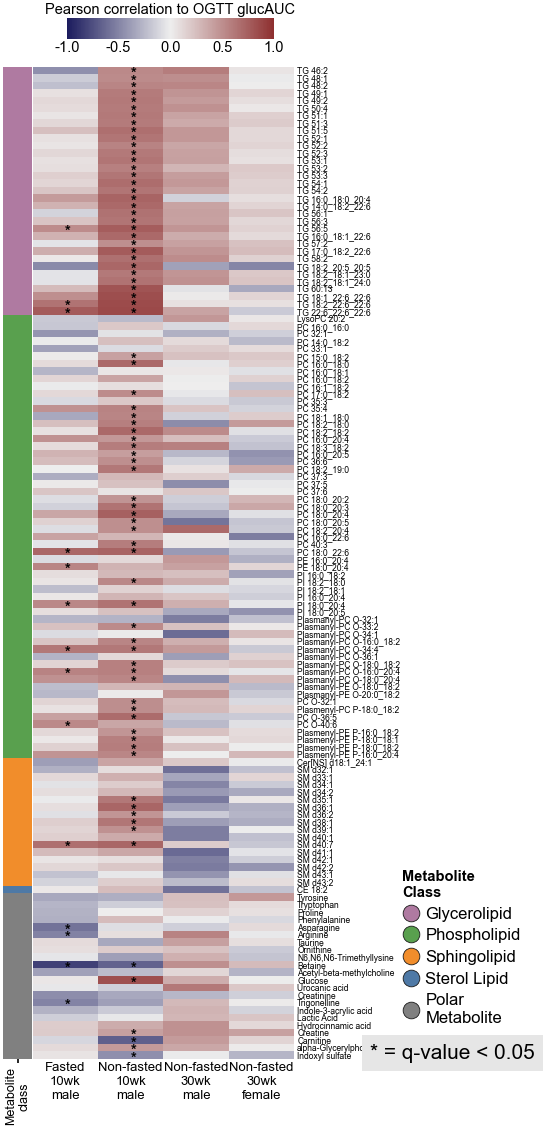

In [1558]:
cm_cols = {
    f'f10_{method_name}': 'Fasted\n10wk\nmale',
    f'nf10_{method_name}': 'Non-fasted\n10wk\nmale',
    f'm30_{method_name}': 'Non-fasted\n30wk\nmale',
    f'f30_{method_name}': 'Non-fasted\n30wk\nfemale',
#            'fasted10ogttcorr':  'Fasted\n10wk Male\nOGTT glucAUC',
#            'nonfast10ogttcorr': 'Non-fasted\n10wk Male\nOGTT glucAUC',
#            'm30ogttcorr':       'Non-fasted\n30wk Male\nOGTT glucAUC',
#            'f30ogttcorr':       'Non-fasted\n30wk Female\nOGTT glucAUC',
}

subset = r
subset = r.sort_values(['Type', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])

# cmap = sns.color_palette('blend:#2BD7D1,#FFF,#7D0D87', as_cmap=True)
cmap = sns.color_palette('blend:#1B1B5D,#EEE,#8E3030', as_cmap=True)
# cmap = 'coolwarm'

ypos_offset = 0.95
subset['ypos'] = np.arange(ypos_offset, len(subset)+ypos_offset, 1)

cm = sns.clustermap(
    data=subset[cm_cols.keys()],
    row_cluster=False, col_cluster=False, dendrogram_ratio=[0.001, 0.001], colors_ratio=[0.1, 0],
    row_colors=subset['color'],
    method='complete', metric='cityblock',
    center=0, vmin=-1, vmax=1,
#     cmap=sns.color_palette('coolwarm', n_colors=12, desat=0.8),
    cmap=cmap,
    yticklabels=subset['ID'],
    cbar_pos=(0.2, 1.01, 0.6, 0.02),
    cbar_kws=dict(orientation='horizontal'))

fig, axh, axcb = plt.gcf(), cm.ax_heatmap, cm.ax_cbar

for xpos, col in enumerate(cm_cols):
    for lipid_i, row in subset.iterrows():
        group = col.split('_')[0]
        if row[f'{group}_signif']:  # if row[f'{group}_pval'] < 0.05:
            axh.text(xpos+0.5, row['ypos'], '*', color='black',
                     fontsize=7, fontweight='bold', va='center')
        # test the offset: 
#         if 'f30' in col:
#             axh.text(xpos+0.5, row['ypos'], '*', fontsize=6, fontweight='bold', va='center')
axh.text(1.29, 0, '* = q-value < 0.05 ', transform=axh.transAxes, bbox=dict(fc='0.9', lw=0))
fig.set(dpi=150, facecolor='white', size_inches=(2.3, 7))
axh.set_xticks(np.arange(0.5, len(cm_cols) + 0.5, 1), cm_cols.values())
axh.tick_params(length=0, pad=1.5, labelsize=4.1, )
axh.tick_params(axis='x', labelsize=6.3)
axcb.set_xlabel('Pearson correlation to OGTT glucAUC', fontsize=7)
axcb.xaxis.set_label_position('top')
axcb.tick_params(length=0, pad=1, labelsize=7)
cm.ax_row_colors.set(xticklabels=['Metabolite\nclass'])
colors['pm'] = (0.5, 0.5, 0.5)
legend = src.plots.custom_legend(
    ax=axh, loc=(1.4, 0.03), title='Metabolite\nClass', palette=colors,
    entries=['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Sterol Lipid', 'pm'],
    labels=['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Sterol Lipid', 'Polar\nMetabolite']  
)
# plt.savefig('../reports/figures/FigureSupp/10vs30wk_ogtt_corrs.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('../reports/figures/FigureSupp/10vs30wk_ogtt_corrs.png', bbox_inches='tight', dpi=500)

# For all aligned lipids, do the RSDs agree? 

In [771]:
ogb = np.power(2, (data[rbg_cols])).T.groupby(fg['animal'])
orsd = ((ogb.std() / ogb.mean()) * 100).T.mean(axis=1)
orsd.name = 'orsd'
orsd

vgb = np.power(2, (vldata[vldata_cols])).T.join(fg[['animal', 'sex']]).groupby(['animal', 'sex'])
vrsd = ((vgb.std() / vgb.mean()) * 100).groupby('sex').mean().T
vrsd.rename({'F':'Frsd', 'M': 'Mrsd'}, axis=1, inplace=True)
vrsd

sex,Frsd,Mrsd
vl_6,19.459595,18.729451
vl_11,23.320824,25.196126
vl_16,17.044147,17.272036
vl_19,19.112494,20.099236
vl_60,38.553004,49.161725
...,...,...
vl_6458,38.705806,41.641996
vl_6461,36.586312,40.122733
vl_6481,50.633287,38.663882
vl_6484,49.294925,39.109423


In [800]:
matched_rsds = (nonsc_both[['o', 'v']]
                .merge(orsd, left_on='o', right_index=True)
                .merge(vrsd, left_on='v', right_index=True)
                .merge(data[['ID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat']], left_on='o', right_index=True)
               )
matched_rsds['c'] = matched_rsds['molec_class'].map(colors)
matched_rsds = matched_rsds.sort_values('orsd')
matched_rsds['Fdiff'] = matched_rsds['Frsd'] - matched_rsds['orsd']
matched_rsds['Mdiff'] = matched_rsds['Mrsd'] - matched_rsds['orsd']
matched_rsds

,o,v,orsd,Frsd,Mrsd,ID,superclass,molec_class,fa_carbons,fa_unsat,c,Fdiff,Mdiff
SM d36:2,l_274,vl_2687,11.102311,13.786031,12.553124,SM d36:2,Sphingolipid,SM,36.0,2.0,"[0.9453125, 0.5546875, 0.16796875]",2.683720,1.450812
SM d33:1,l_208,vl_2357,12.128444,9.223334,10.939958,SM d33:1,Sphingolipid,SM,33.0,1.0,"[0.9453125, 0.5546875, 0.16796875]",-2.905110,-1.188486
PI 18:0_20:4,l_227,vl_2463,12.416475,18.489650,17.694295,PI 18:0_20:4,Phospholipid,PI,38.0,4.0,"[0.34765625, 0.62890625, 0.3046875]",6.073176,5.277820
PC 14:0_18:2,l_206,vl_2327,12.837594,8.976549,14.638631,PC 14:0_18:2,Phospholipid,PC,32.0,2.0,"[0.34765625, 0.62890625, 0.3046875]",-3.861045,1.801038
SM d35:1,l_326,vl_2950,13.059760,11.007870,11.512261,SM d35:1,Sphingolipid,SM,35.0,1.0,"[0.9453125, 0.5546875, 0.16796875]",-2.051891,-1.547500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TG 53:1,l_878,vl_6334,41.282863,48.369778,46.073372,TG 53:1,Glycerolipid,TG,53.0,1.0,"[0.6875, 0.4765625, 0.6328125]",7.086915,4.790509
TG 51:5,l_659,vl_5342,42.388870,42.581449,35.883869,TG 51:5,Glycerolipid,TG,51.0,5.0,"[0.6875, 0.4765625, 0.6328125]",0.192578,-6.505001
TG 22:6_22:6_22:6,l_582,vl_4879,46.266677,31.922029,23.319562,TG 22:6_22:6_22:6,Glycerolipid,TG,66.0,18.0,"[0.6875, 0.4765625, 0.6328125]",-14.344648,-22.947115
TG 57:2,l_905,vl_6436,47.460372,45.548757,42.734134,TG 57:2,Glycerolipid,TG,57.0,2.0,"[0.6875, 0.4765625, 0.6328125]",-1.911616,-4.726238


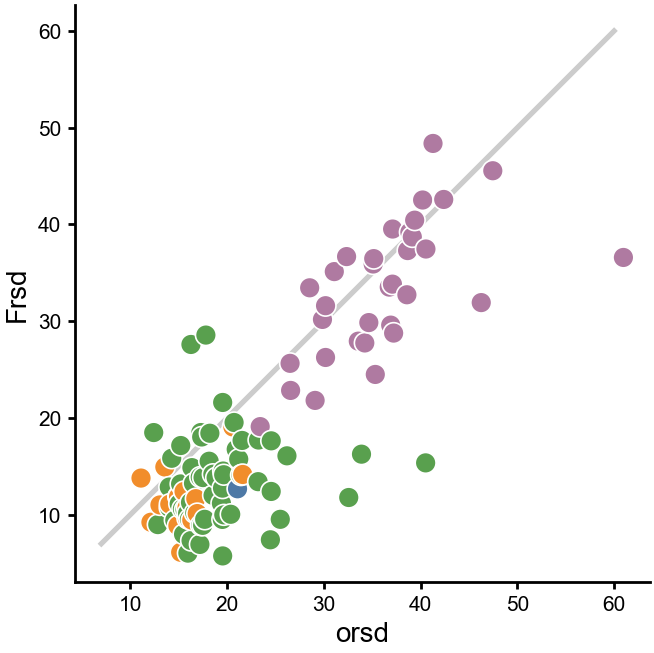

In [783]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=250)
sns.scatterplot(
    data=matched_rsds, x='orsd', y='Frsd', hue='superclass', palette=colors, ax=ax,
    legend=False,
)
ax.plot([7, 60], [7, 60], color='0.8', zorder=-1)
ax.set_aspect('equal')
sns.despine()

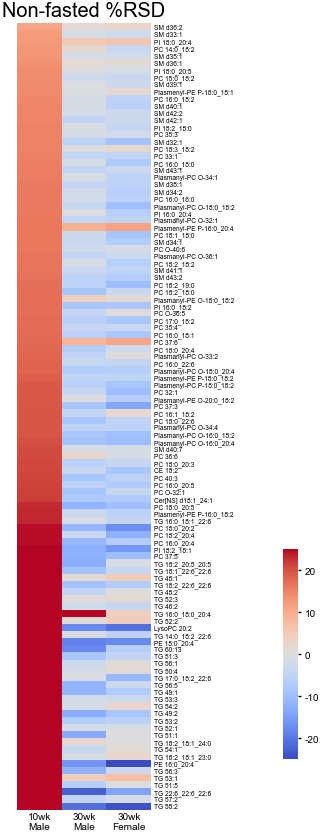

In [801]:
cm = sns.clustermap(
    data=matched_rsds[['orsd', 'Mdiff', 'Fdiff']],
    center=0, cmap='coolwarm', vmin=-25, vmax=25,
    col_cluster=False, row_cluster=False, 
    colors_ratio=[0.1, 0], dendrogram_ratio=0.001, 
    figsize=(2.5, 7),
    cbar_pos=[0.95, 0.1, 0.05, 0.25],
    yticklabels=matched_rsds.index
)
fig, axh, axcbar = cm.fig, cm.ax_heatmap, cm.ax_cbar
axh.tick_params(length=0, pad=1.5, labelsize=4)
axh.set_xticks([0.5, 1.5, 2.5], ['10wk\nMale', '30wk\nMale', '30wk\nFemale'], fontsize=6)

axh.set_title('Non-fasted %RSD')
plt.savefig('../reports/figures/Figure7/RSD_diffs.pdf', bbox_inches='tight', dpi=300)

In [810]:
matched_rsds['ranking'] = range(1, len(matched_rsds)+1)
matched_rsds.loc[matched_rsds['ranking'].isin([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])]

,o,v,orsd,Frsd,Mrsd,ID,superclass,molec_class,fa_carbons,fa_unsat,c,Fdiff,Mdiff,ranking
SM d36:2,l_274,vl_2687,11.102311,13.786031,12.553124,SM d36:2,Sphingolipid,SM,36.0,2.0,"[0.9453125, 0.5546875, 0.16796875]",2.683720,1.450812,1
Plasmenyl-PE P-18:0_18:1,l_509,vl_4035,14.276141,15.830964,13.729880,Plasmenyl-PE P-18:0_18:1,Phospholipid,Plasmenyl-PE,36.0,1.0,"[0.34765625, 0.62890625, 0.3046875]",1.554823,-0.546261,10
PC 16:0_18:0,l_465,vl_3729,15.500043,7.980383,14.270430,PC 16:0_18:0,Phospholipid,PC,34.0,0.0,"[0.34765625, 0.62890625, 0.3046875]",-7.519660,-1.229613,20
PC 18:1_18:0,l_474,vl_3752,16.277165,7.325363,13.158464,PC 18:1_18:0,Phospholipid,PC,36.0,1.0,"[0.34765625, 0.62890625, 0.3046875]",-8.951802,-3.118701,30
PI 16:0_18:2,l_168,vl_2146,17.293453,8.918119,8.891517,PI 16:0_18:2,Phospholipid,PI,34.0,2.0,"[0.34765625, 0.62890625, 0.3046875]",-8.375334,-8.401935,40
Plasmenyl-PE P-18:0_18:2,l_454,vl_3710,18.865623,13.813880,13.979281,Plasmenyl-PE P-18:0_18:2,Phospholipid,Plasmenyl-PE,36.0,2.0,"[0.34765625, 0.62890625, 0.3046875]",-5.051743,-4.886342,50
SM d40:7,l_166,vl_2148,20.597041,19.069591,19.540760,SM d40:7,Sphingolipid,SM,40.0,7.0,"[0.9453125, 0.5546875, 0.16796875]",-1.527449,-1.056280,60
TG 16:0_18:1_22:6,l_738,vl_5637,23.420076,19.103608,22.622017,TG 16:0_18:1_22:6,Glycerolipid,TG,56.0,7.0,"[0.6875, 0.4765625, 0.6328125]",-4.316468,-0.798059,70
TG 48:2,l_724,vl_5603,29.856571,30.181028,25.362145,TG 48:2,Glycerolipid,TG,48.0,2.0,"[0.6875, 0.4765625, 0.6328125]",0.324457,-4.494426,80
TG 56:1,l_907,vl_6454,35.099192,35.910261,31.874281,TG 56:1,Glycerolipid,TG,56.0,1.0,"[0.6875, 0.4765625, 0.6328125]",0.811069,-3.224911,90


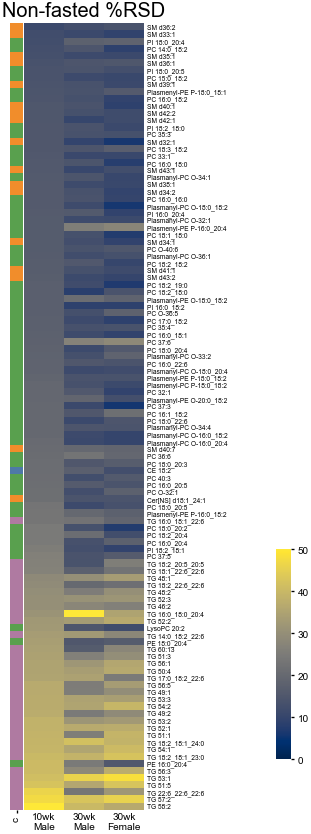

In [802]:
cm = sns.clustermap(
    data=matched_rsds[['orsd', 'Mrsd', 'Frsd']],
    vmin=0, vmax=50, cmap='cividis',
    col_cluster=False, row_cluster=False, 
    row_colors=matched_rsds['c'],
    colors_ratio=[0.1, 0], dendrogram_ratio=0.001, 
    figsize=(2.5, 7),
    cbar_pos=[0.95, 0.1, 0.05, 0.25],
    yticklabels=matched_rsds.index
)
fig, axh, axcbar = cm.fig, cm.ax_heatmap, cm.ax_cbar
axh.tick_params(length=0, pad=1.5, labelsize=4)
axh.set_xticks([0.5, 1.5, 2.5], ['10wk\nMale', '30wk\nMale', '30wk\nFemale'], fontsize=6)

axh.set_title('Non-fasted %RSD')
plt.savefig('../reports/figures/Figure7/RSD_values.pdf', bbox_inches='tight', dpi=300)

In [ ]:
ax.imshow()

In [786]:
axcbar.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

# Individual metabolite fixed effects modeling 

# Conclusion: After FDR correction none of sex, ogtt or sex:ogtt are significant
## When you iinclude week and ogtt:week terms, none are significant

In [476]:
nrsex = ap['sex']
nrsex.index = nrsex.index.astype('str')
lmdata = vldata[vldata_cols].T.join(fg[['ogtt', 'sex', 'week']])
lmdata

,vl_6,vl_11,vl_16,vl_19,vl_60,vl_84,vl_131,vl_217,vl_242,vl_243,...,vl_6454,vl_6457,vl_6458,vl_6461,vl_6481,vl_6484,vl_6490,ogtt,sex,week
1727_27_RBG,23.667730,24.440677,23.871339,28.356154,23.453587,27.311327,23.137993,25.091433,19.629902,23.657118,...,24.967295,20.733375,23.556047,24.452585,24.916387,23.549025,23.348177,636.708333,M,27.0
1727_28_RBG,23.779395,24.846924,24.063050,29.154788,23.118769,25.360826,23.548498,25.235026,19.573236,23.620384,...,25.622397,21.805664,24.417886,25.523029,25.629473,24.247148,23.855685,636.708333,M,28.0
1727_29_RBG,24.043473,25.260292,24.214676,29.249595,24.757631,26.445919,23.302067,25.620745,19.914589,25.009187,...,24.603435,20.710905,23.434391,24.153751,25.251856,23.951939,23.701983,636.708333,M,29.0
1728_27_RBG,23.354692,24.807312,24.491564,29.102521,22.841018,26.960894,23.291253,25.272119,19.377908,24.182424,...,25.027006,21.008846,23.946911,24.573933,23.554180,22.351392,21.835839,729.458333,M,27.0
1728_28_RBG,22.908659,23.528164,24.032823,28.785661,24.078661,26.606765,23.752561,24.853806,19.450609,23.271858,...,25.729469,21.713766,24.838433,25.406131,25.114213,23.813534,23.303220,729.458333,M,28.0
1728_30_RBG,23.718631,24.680641,23.760787,28.707637,25.004761,27.185102,23.746217,25.155528,20.015067,24.634911,...,25.412464,21.866132,24.302336,25.019617,24.494142,23.115228,22.616809,729.458333,M,30.0
1731_30_RBG,24.067865,25.339701,24.279088,29.216474,22.729032,25.973200,23.614925,25.863342,20.095319,24.694857,...,24.487900,20.287243,23.077834,23.967481,23.811996,22.552355,22.320936,686.975000,F,30.0
1731_31_RBG,24.522445,25.049551,24.206414,29.286579,22.036032,26.251125,23.875704,26.087868,20.637844,25.263225,...,23.756371,19.265093,22.196886,22.758243,23.450195,22.157983,21.100629,686.975000,F,31.0
1731_32_RBG,24.748302,25.628816,24.302731,29.482651,21.882598,25.443094,24.404979,26.092867,20.583044,25.301300,...,23.532979,19.290473,21.801959,23.116414,23.295264,21.532995,21.716691,686.975000,F,32.0
1732_27_RBG,24.993826,26.016486,24.457751,30.058890,24.952763,26.001369,24.070113,25.989910,21.259256,25.667034,...,23.284162,17.622172,21.792748,22.860251,22.794613,21.497018,20.913526,631.000000,M,27.0


(array([14., 27., 27., 31., 38., 22., 22., 20., 25., 23.]),
 array([0.01015191, 0.10895322, 0.20775454, 0.30655586, 0.40535717,
        0.50415849, 0.60295981, 0.70176113, 0.80056244, 0.89936376,
        0.99816508]),
 <BarContainer object of 10 artists>)

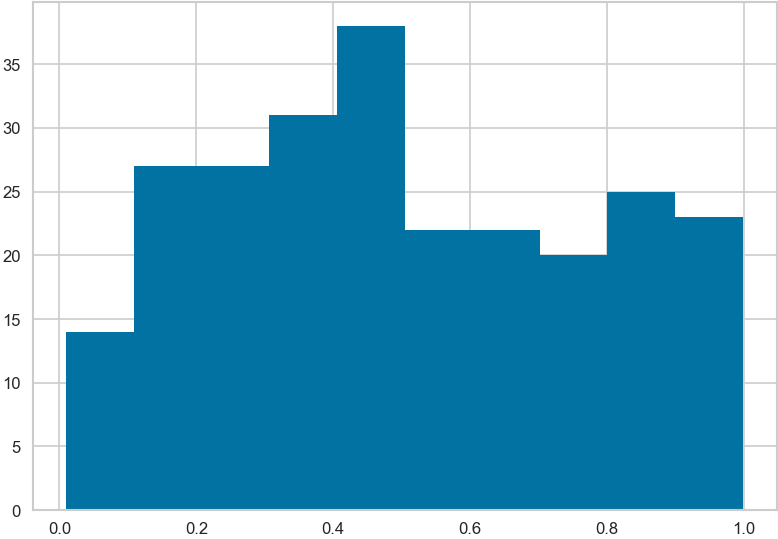

In [707]:
r = {}

for feature in vldata.loc[vldata['ID'] != 'Unidentified'].index: 

    lm = smf.ols(f'{feature} ~ ogtt:week:sex', data=lmdata).fit()
    r[feature] = {
#                   'pval_sex': lm.pvalues['sex[T.M]'], 
#                   'pval_ogtt': lm.pvalues['ogtt'], 
#                   'pval_ogtt:sex': lm.pvalues['ogtt:sex[T.M]'],
#                   'pval_week': lm.pvalues['week'],
#                   'pval_ogtt:week': lm.pvalues['ogtt:week'],
#                   'pval_week:sex': lm.pvalues['week:sex[T.M]']
        'pval_3wayF': lm.pvalues['ogtt:week:sex[F]'],
        'pval_3wayM': lm.pvalues['ogtt:week:sex[M]'],
                 }
fedf = pd.DataFrame(r).T
plt.hist(fedf['pval_3wayF'])

# Try a new strategy of mixed effects modeling:
`Quantitation of all metabolites (each 3-week average per rat is 1 row) ~ OGTT glucAUC + (1|metabolite class)`

# Conclusion:
# No matter how you slice the data into groups, there's not much, we are simply lacking power 

In [639]:
medata = (vldata
 .loc[vldata['ID'] != 'Unidentified', vldata_cols]
 .T
 .groupby(fg['animal'])
 .mean()
 .T
 .join(vldata[['superclass', 'molec_class', 'fa_carbons', 'fa_unsat']]))
# medata.loc[medata['molec_class'] == 'TG'].T
medata['fa_ratio'] = medata['fa_unsat'] / medata['fa_carbons']

val_animals = [str(x) for x in [1727, 1728, 1731, 1732, 1735, 1741, 1742, 1743, 1746, 1748, 1754]]

meltdf = medata.melt(
    value_vars=val_animals, id_vars=['superclass', 'molec_class', 'fa_ratio'],
    var_name='animal', value_name='quant')
ogttsex = ap[['OGTT (AUC)', 'sex']]
ogttsex.index = ogttsex.index.astype('str')
meltdf = meltdf.merge(ogttsex, left_on='animal', right_index=True)
meltdf.rename({'OGTT (AUC)': 'ogtt'}, axis=1, inplace=True)

# meltdf = meltdf.groupby(['molec_class', 'animal']).mean()
# meltdf = meltdf.reset_index()
# meltdf = meltdf.merge(ogttsex, left_on='animal', right_index=True)

meltdf = meltdf.groupby(['fa_ratio', 'molec_class', 'animal']).mean().reset_index()
meltdf['molec_class'] = meltdf['molec_class'].apply(lambda x: 'Cer' if 'Cer' in x else x)

meltdf

,fa_ratio,molec_class,animal,quant,ogtt
0,0.000000,Cer,1727,19.108442,636.708333
1,0.000000,Cer,1728,19.744265,729.458333
2,0.000000,Cer,1731,20.205594,686.975000
3,0.000000,Cer,1732,20.229082,631.000000
4,0.000000,Cer,1735,19.270943,601.500000
...,...,...,...,...,...
2162,0.272727,TG,1742,23.878061,429.041667
2163,0.272727,TG,1743,24.737474,595.958333
2164,0.272727,TG,1746,23.470821,496.416667
2165,0.272727,TG,1748,22.986279,627.500000


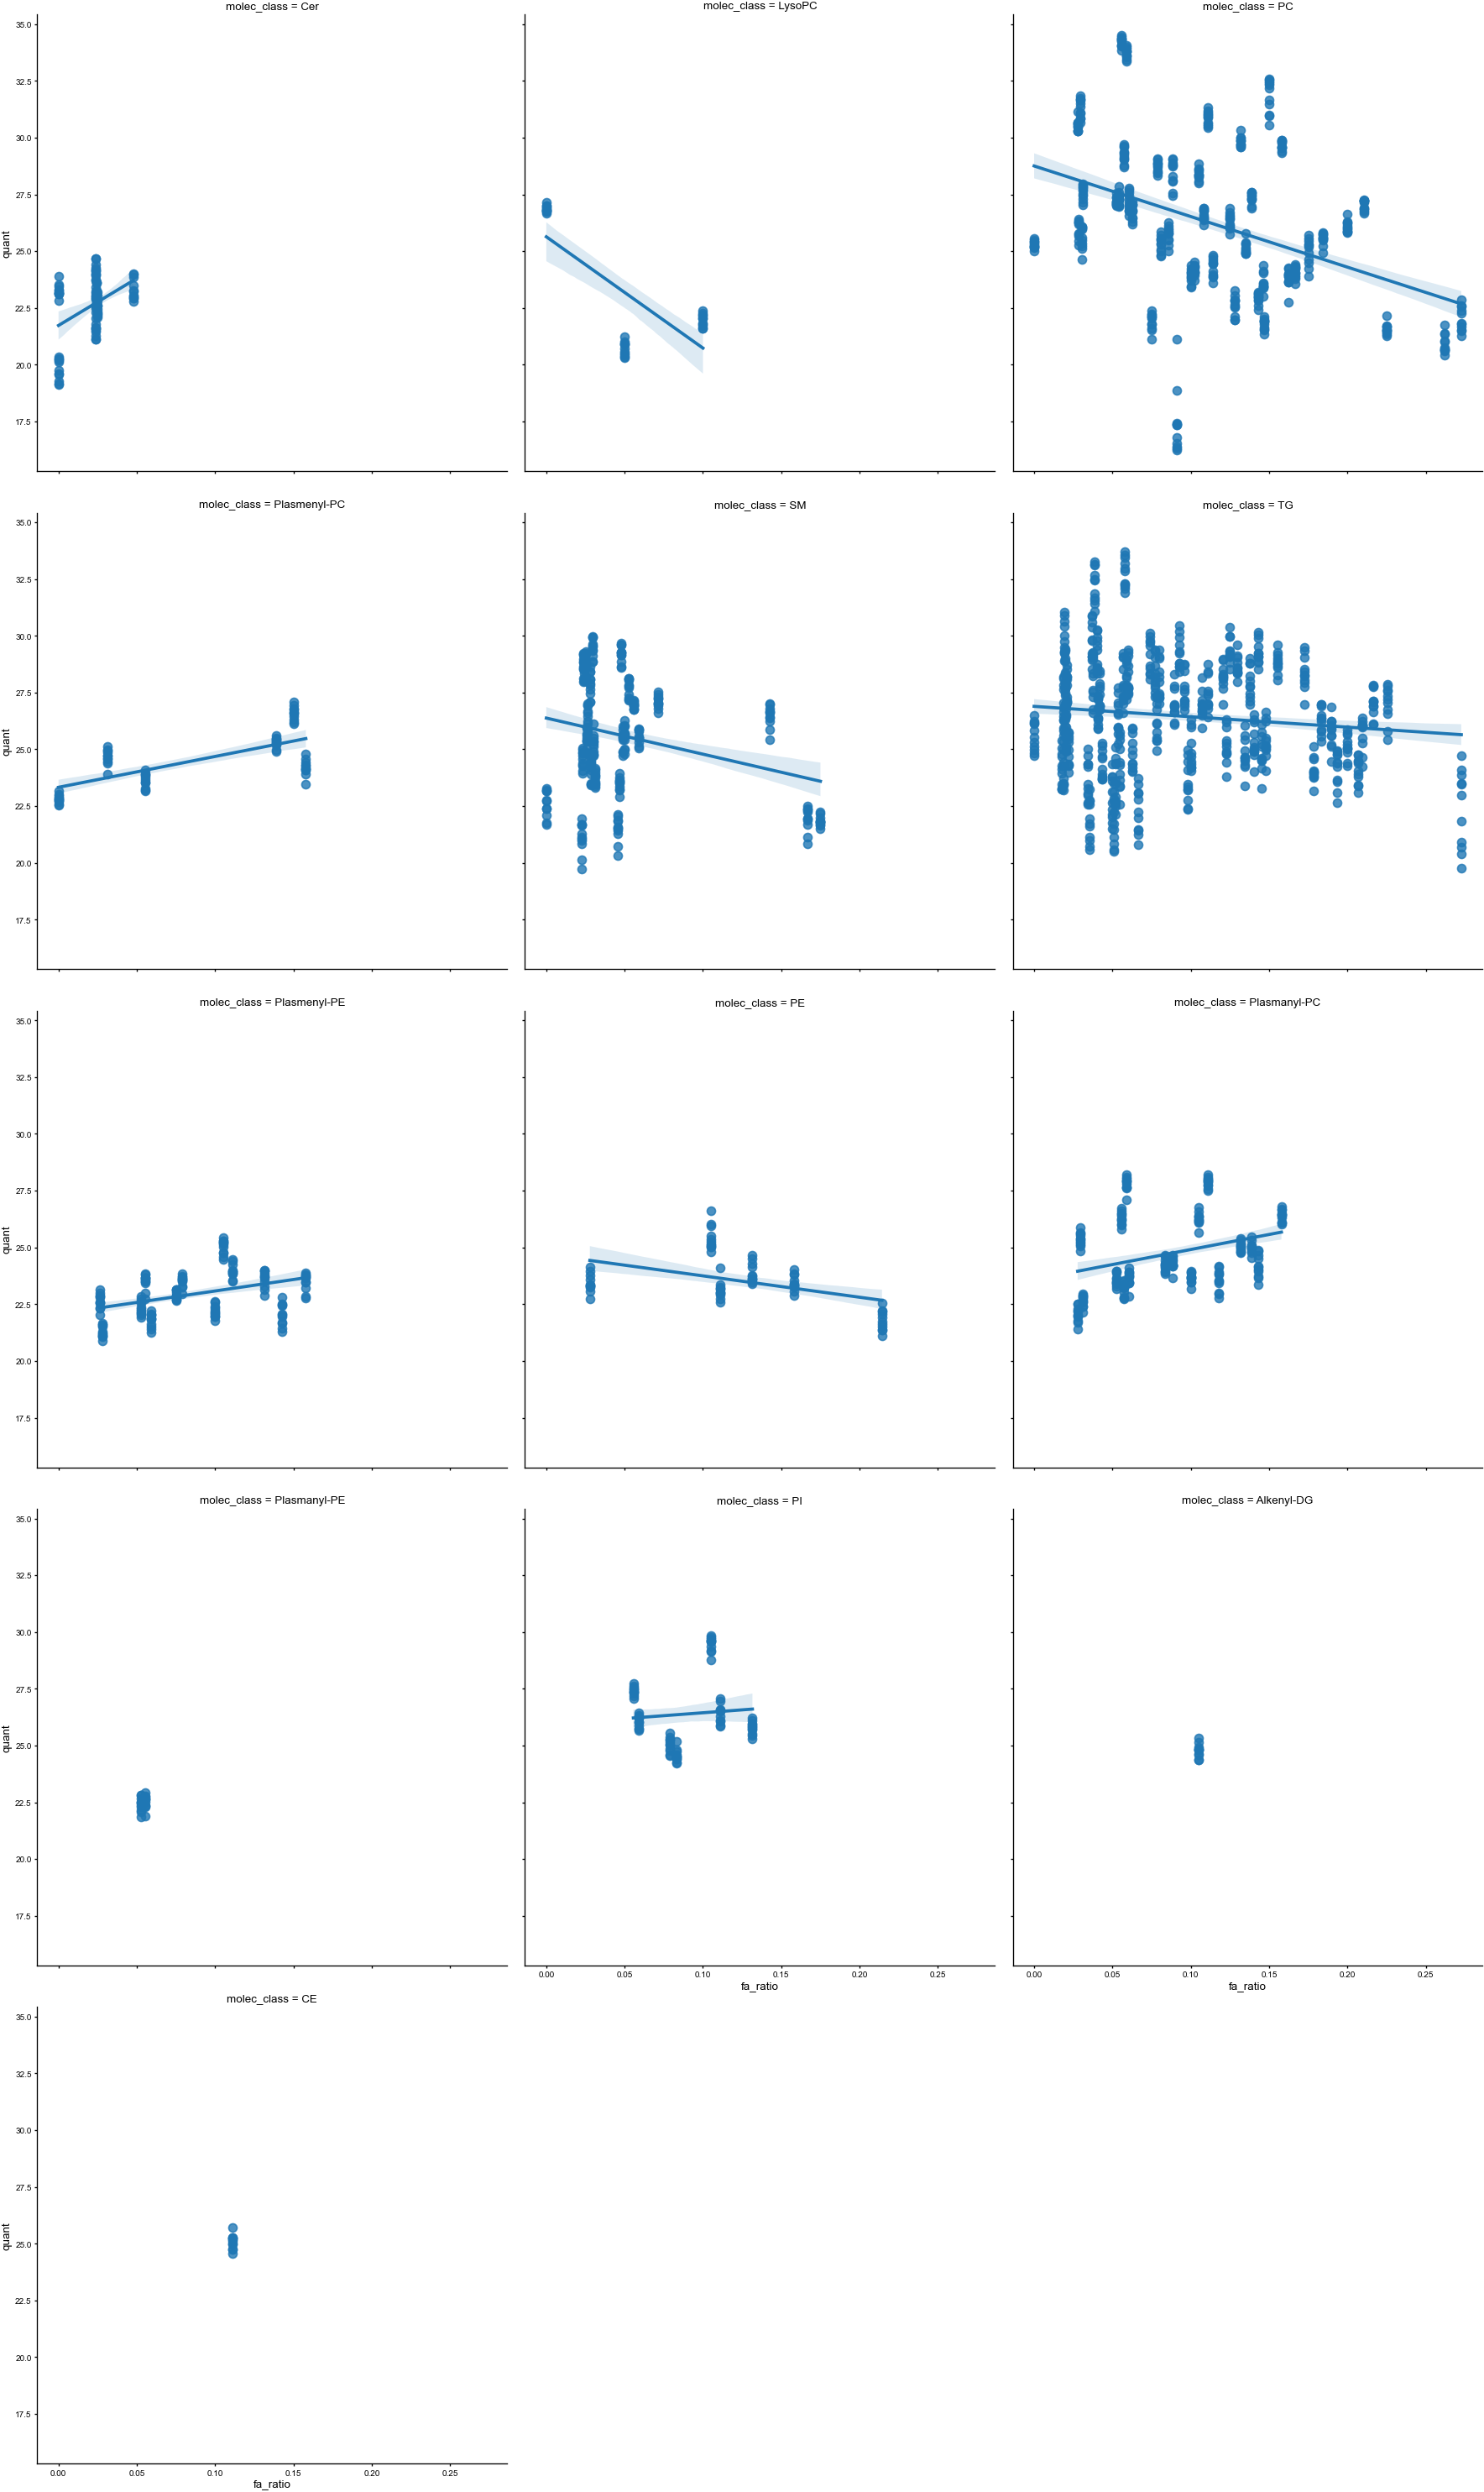

In [640]:
sns.lmplot(data=meltdf, y='quant', x='fa_ratio', x_partial='ogtt',
           col='molec_class', col_wrap=3)

In [617]:
smf.ols(f'quant ~ molec_class + sex + sex:molec_class', data=meltdf).fit().summary()
# smf.ols(f'quant ~ sex', data=meltdf).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  quant   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     124.8
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           1.41e-72
Time:                        12:05:11   Log-Likelihood:                -10.983
No. Observations:                 143   AIC:                             73.97
Df Residuals:                     117   BIC:                             151.0
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               24.6135      0.118    208.715      0.000      24.380      24.847
molec_class[T.CE]                        0.3534      0.167      2.119      0.036       0.023       0.684
molec_class[T.Cer]                      -1.7638      0.167    -10.576      0.000      -2.094      -1.434
molec_class[T.LysoPC]                   -0.6136      0.167     -3.679      0.000      -0.944      -0.283
molec_class[T.PC]                        1.7448      0.167     10.462      0.000       1.415       2.075
molec_class[T.PE]                       -1.1061      0.167     -6.632      0.000      -1.436      -0.776
molec_class[T.PI]                        1.6339      0.167      9.797      0.000       1.304       1.964
molec_class[T.Plasmanyl-PC]              0.1928      0.167      1.156      0.250      -0.138       0.523
molec_class[T.Plasmanyl-PE]             -2.0550      0.167    -12.322      0.000      -2.385      -1.725
molec_class[T.Plasmenyl-PC]             -0.1548      0.167     -0.928      0.355      -0.485       0.176
molec_class[T.Plasmenyl-PE]             -1.6079      0.167     -9.641      0.000      -1.938      -1.278
molec_class[T.SM]                        0.9584      0.167      5.746      0.000       0.628       1.289
molec_class[T.TG]                        1.9446      0.167     11.660      0.000       1.614       2.275
sex[T.M]                                 0.3799      0.175      2.172      0.032       0.034       0.726
sex[T.M]:molec_class[T.CE]              -0.1465      0.247     -0.592      0.555      -0.636       0.343
sex[T.M]:molec_class[T.Cer]             -0.6230      0.247     -2.519      0.013      -1.113      -0.133
sex[T.M]:molec_class[T.LysoPC]          -0.1497      0.247     -0.605      0.546      -0.640       0.340
sex[T.M]:molec_class[T.PC]              -0.3194      0.247     -1.291      0.199      -0.809       0.170
sex[T.M]:molec_class[T.PE]              -0.3615      0.247     -1.461      0.147      -0.851       0.128
sex[T.M]:molec_class[T.PI]              -0.0693      0.247     -0.280      0.780      -0.559       0.421
sex[T.M]:molec_class[T.Plasmanyl-PC]    -0.3828      0.247     -1.547      0.124      -0.873       0.107
sex[T.M]:molec_class[T.Plasmanyl-PE]    -0.5632      0.247     -2.277      0.025      -1.053      -0.073
sex[T.M]:molec_class[T.Plasmenyl-PC]    -0.3145      0.247     -1.271      0.206      -0.804       0.175
sex[T.M]:molec_class[T.Plasmenyl-PE]    -0.6301      0.247     -2.547      0.012      -1.120      -0.140
sex[T.M]:molec_class[T.SM]              -0.7992      0.247     -3.231      0.002      -1.289      -0.309
sex[T.M]:molec_class[T.TG]              -0.3565      0.247     -1.441      0.152      -0.846       0.133
======================================

In [602]:
# quant ~ molec_class, groups='animal'

mlm = smf.mixedlm(
    f'quant ~ sex', 
    groups='molec_class',
    # vc_formula={'sex': '0 + sex'}, 
#     vc_formula={'molec_class': '0 + molec_class'},
    data=meltdf).fit(reml=True)

In [603]:
mlm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:              MixedLM  Dependent Variable:  quant   
No. Observations:   143      Method:              REML    
No. Groups:         13       Scale:               0.0901  
Min. group size:    11       Log-Likelihood:      -67.5495
Max. group size:    11       Converged:           Yes     
Mean group size:    11.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       24.577    0.389 63.218 0.000 23.815 25.339
sex[T.M]         0.017    0.050  0.341 0.733 -0.082  0.116
molec_class Var  1.950    2.783                           
==========================================================

"""

In [604]:
mlm.random_effects

{'Alkenyl-DG': molec_class    0.200452
 dtype: float64,
 'CE': molec_class    0.486021
 dtype: float64,
 'Cer': molec_class   -1.837981
 dtype: float64,
 'LysoPC': molec_class   -0.478369
 dtype: float64,
 'PC': molec_class    1.793379
 dtype: float64,
 'PE': molec_class   -1.064606
 dtype: float64,
 'PI': molec_class    1.796148
 dtype: float64,
 'Plasmanyl-PC': molec_class    0.219183
 dtype: float64,
 'Plasmanyl-PE': molec_class   -2.100828
 dtype: float64,
 'Plasmenyl-PC': molec_class   -0.096043
 dtype: float64,
 'Plasmenyl-PE': molec_class   -1.685941
 dtype: float64,
 'SM': molec_class    0.793061
 dtype: float64,
 'TG': molec_class    1.975523
 dtype: float64}

# Do linear regressions multivariate to OGTT

In [633]:
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.linear_model import (LinearRegression, Lasso, Ridge, Lars, LassoLarsCV, LassoLars, 
                                  ElasticNet, ElasticNetCV)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import CVScores, FeatureImportances, LearningCurve, ValidationCurve

In [693]:
X = vldata.loc[vldata['ID'] != 'Unidentified', vldata_cols].T
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
y = X.index.map(fg['ogtt'])
y = pd.Series(y, index=X.index)
X_scaled = X_scaled.join(fg['sex'])
X_scaled['sex'] = pd.get_dummies(X_scaled['sex'])['F']
X_scaled

,vl_946,vl_948,vl_1056,vl_1123,vl_1974,vl_2018,vl_2027,vl_2070,vl_2079,vl_2110,...,vl_6379,vl_6391,vl_6395,vl_6396,vl_6431,vl_6436,vl_6454,vl_6458,vl_6461,sex
1727_27_RBG,-0.103065,0.559789,-2.150744,0.438076,-1.248569,-0.391428,-0.979493,-1.899438,-0.491779,0.394868,...,0.644739,0.491814,0.699658,0.318699,0.858865,0.784808,0.958580,0.695579,0.797194,0
1727_28_RBG,0.135973,0.784280,-1.667638,-0.034057,-1.617434,-0.880765,-0.759370,-1.752438,0.052604,-0.090455,...,1.809570,1.246432,1.127722,1.127022,1.824156,1.824903,1.713759,1.518255,1.923473,0
1727_29_RBG,2.162869,1.793293,-0.513958,1.692961,-0.805767,-1.368780,0.989242,-0.640864,1.462234,1.235757,...,0.781292,0.345679,0.537025,0.145288,0.635719,-0.093621,0.539134,0.579450,0.482772,0
1728_27_RBG,1.150698,1.646946,-0.219088,1.220320,-0.626817,-0.192006,0.668348,-0.086004,0.219615,0.689987,...,0.915219,1.103377,1.152220,1.273365,1.053353,0.832058,1.027413,1.068681,0.924872,0
1728_28_RBG,-0.244997,0.241742,-1.259459,-0.024975,-1.348470,-2.200972,-1.083651,-0.951489,-0.236901,-0.391281,...,1.638492,1.418878,1.822637,1.695090,1.722178,1.625400,1.837188,1.919692,1.800477,0
1728_30_RBG,1.816916,1.734512,0.698914,1.444525,0.171316,-0.014533,0.447718,-0.201090,0.826499,1.770939,...,1.416468,1.427745,1.520750,1.414661,1.504313,1.438976,1.471755,1.407955,1.393802,0
1731_30_RBG,-1.142756,-1.034740,0.372675,-1.394502,-0.827673,-2.049840,-1.166718,-0.424528,-1.490583,-2.922259,...,0.140016,0.264668,0.031372,0.311577,0.183000,0.422273,0.405950,0.239096,0.286787,1
1731_31_RBG,-1.351423,-1.160937,0.047752,-0.933828,-0.345357,-1.615104,-0.541669,-0.372806,-0.968077,-1.347001,...,-0.476321,-0.671281,-0.640423,-0.644078,-0.756506,-0.585905,-0.437332,-0.601821,-0.985526,1
1731_32_RBG,-1.116765,-0.653816,0.050652,-1.147713,-0.996082,-0.978155,-1.310913,-0.245613,-1.335177,-1.863285,...,-0.546114,-0.833677,-0.970342,-0.955882,-0.491679,-0.376117,-0.694850,-0.978803,-0.608672,1
1732_27_RBG,0.267739,1.123292,-0.075345,1.135114,-0.077862,1.323695,1.294513,-0.141073,1.707947,1.726384,...,-0.901185,-1.130757,-1.001480,-0.841015,-1.125006,-1.363487,-0.981679,-0.987596,-0.878197,0


In [692]:
llcv = LassoLarsCV(
    cv=RepeatedKFold(n_repeats=50, random_state=43), 
    n_jobs=7, 
    fit_intercept=False
).fit(X_scaled, y)

llcoef = pd.DataFrame(llcv.coef_, index=llcv.feature_names_in_, columns=['coef'])
llcoef = llcoef.join(vldata['ID']).sort_values('coef', ascending=False)
llcoef['abs_coef'] = llcoef['coef'].abs()
llcoef['normabs_coef'] = llcoef['abs_coef'].div(llcoef['abs_coef'].max()) * 10
llcoef = llcoef.sort_values('normabs_coef', ascending=False)
llcoef.iloc[:30]

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


,coef,ID,abs_coef,normabs_coef
sex,1096.168974,NaN,1096.168974,10.000000
vl_2070,-113.783937,PC 44:12,113.783937,1.038015
vl_2597,80.013812,SM d42:6,80.013812,0.729940
vl_4879,-64.267467,TG 22:6_22:6_22:6,64.267467,0.586292
vl_4314,-59.245726,SM d43:2,59.245726,0.540480
vl_946,59.053083,LysoPC 20:2,59.053083,0.538722
vl_2079,57.696414,PI 16:0_20:4,57.696414,0.526346
vl_1974,-56.345190,PC 42:11,56.345190,0.514019
vl_4657,-54.997527,GlcCer[NDS] d42:1,54.997527,0.501725
vl_948,53.177265,LysoPC 17:0,53.177265,0.485119


In [648]:
encv = ElasticNetCV(
    l1_ratio=[0.99, 0.999],
    cv=RepeatedKFold(n_repeats=30, random_state=43), 
    n_jobs=7, 
    fit_intercept=True
).fit(X_scaled, y)

encoef = pd.DataFrame(encv.coef_, index=encv.feature_names_in_, columns=['coef'])
encoef = encoef.join(vldata['ID']).sort_values('coef', ascending=False)
encoef['abs_coef'] = encoef['coef'].abs()
encoef['normabs_coef'] = encoef['abs_coef'].div(encoef['abs_coef'].max()) 
encoef = encoef.sort_values('normabs_coef', ascending=False)
encoef.iloc[:30]

,coef,ID,abs_coef,normabs_coef
vl_2384,25.153713,SM d42:7,25.153713,1.000000
vl_4609,18.537783,Cer[NP] t18:0_23:0,18.537783,0.736980
vl_4920,-16.057346,TG 18:2_20:5_20:5,16.057346,0.638369
vl_3484,15.961673,PC 40:5,15.961673,0.634565
vl_2911,11.162813,PE O-38:6,11.162813,0.443784
vl_948,10.595255,LysoPC 17:0,10.595255,0.421220
vl_3823,-8.247169,SM d40:2,8.247169,0.327871
vl_3513,-7.856514,Plasmanyl-PC O-32:1,7.856514,0.312340
vl_2110,-7.182935,PC 38:7,7.182935,0.285562
vl_2186,-6.895772,SM d34:2,6.895772,0.274145


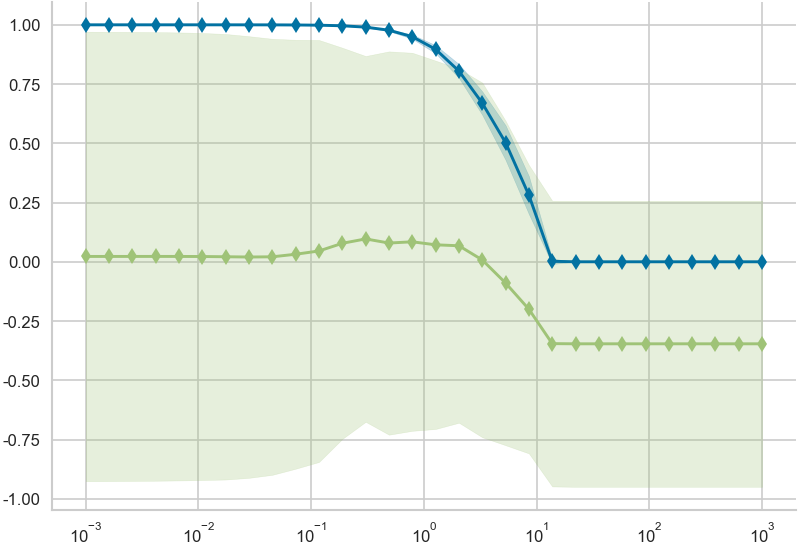

In [706]:
vc = ValidationCurve(
#     estimator=ElasticNet(l1_ratio=0.99),
    estimator=LassoLars(),
    param_name='alpha', 
    param_range=np.logspace(-3, 3, 30),
    cv=RepeatedKFold(),
    n_jobs=7,
    logx=True,
)
vc.fit(X_scaled, y)
sns.despine()

In [705]:
cv = cross_validate(
#     estimator=RandomForestRegressor(oob_score=True), 
#     estimator=ElasticNet(l1_ratio=0.999, alpha=10),
    estimator=LassoLars(alpha=0.005, jitter=0.001,),
    X=X_scaled, y=y, 
    cv=RepeatedKFold(n_splits=5, n_repeats=50, random_state=43),
    n_jobs=7, 
    scoring=['r2'], 
    return_estimator=True,
)

coefs = []
for est in cv['estimator']:
    try:
        coefs.append(est.coef_)
    except:
        coefs.append(est.feature_importances_)
coefs = np.stack(coefs)
coefs = pd.DataFrame(coefs, columns=est.feature_names_in_)
coefs = coefs.mean().abs()
coefs = coefs.div(coefs.max())
coefs = coefs.to_frame('norm_import').join(vldata[['ID', 'superclass', 'molec_class']])
coefs = coefs.sort_values('norm_import', ascending=False)
coefs.iloc[:30]

,norm_import,ID,superclass,molec_class
vl_2384,1.000000,SM d42:7,Sphingolipid,SM
vl_3484,0.712467,PC 40:5,Phospholipid,PC
vl_3513,0.598521,Plasmanyl-PC O-32:1,Phospholipid,Plasmanyl-PC
vl_2911,0.455490,PE O-38:6,Phospholipid,Plasmenyl-PE
vl_4609,0.389006,Cer[NP] t18:0_23:0,Sphingolipid,Cer[NP]
vl_2552,0.355997,PC 16:0_22:6,Phospholipid,PC
vl_4214,0.305720,PE O-38:1,Phospholipid,Plasmenyl-PE
vl_946,0.293419,LysoPC 20:2,Phospholipid,LysoPC
vl_948,0.258523,LysoPC 17:0,Phospholipid,LysoPC
vl_2186,0.241019,SM d34:2,Sphingolipid,SM


## Slope vs slope plot

In [326]:
~vldata.index.isin(['vl_6200'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [397]:
vldata.loc[(vldata['pval_male_ogtt']>0.05) & (vldata['ID'] != 'Unidentified') &
                       (vldata['pval_female_ogtt']>0.05)]

,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,qval_sex,log_qval_sex,qval_male_ogtt,log_qval_male_ogtt,qval_female_ogtt,log_qval_female_ogtt,size_dummy,outlier,coef_male_ogtt_fixed,coef_female_ogtt_fixed
vl_946,2.478,548.37488,+,LysoPC 20:2,LysoPC,78,14.662277,14.698737,14.701709,19.368946,...,3.651814e-04,3.437491,0.343273,0.464360,0.96727,0.014452,0,False,NaN,NaN
vl_948,2.496,510.35880,+,LysoPC 17:0,LysoPC,150,14.737479,14.778014,16.514468,21.885525,...,2.907159e-08,7.536531,0.352296,0.453092,0.96356,0.016121,0,False,NaN,NaN
vl_1056,3.242,524.37469,+,LysoPC 18:0,LysoPC,163,16.433923,18.908208,20.335865,26.938440,...,1.797170e-05,4.745411,0.990931,0.003957,0.96356,0.016121,0,False,NaN,NaN
vl_1123,3.568,550.39099,+,LysoPC 20:1,LysoPC,73,15.191915,15.139724,15.153213,18.636795,...,3.680148e-07,6.434135,0.354442,0.450455,0.96356,0.016121,0,False,NaN,NaN
vl_1974,7.775,852.56415,+,PC 42:11,PC,27,15.202901,15.190675,15.212371,18.528170,...,9.669771e-05,4.014584,0.474311,0.323937,0.90342,0.044110,0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vl_6431,20.242,977.86035,+,TG 18:2_18:1_23:0,TG,72,16.701427,16.705873,16.712249,20.035100,...,1.296575e-01,0.887202,0.343273,0.464360,0.96356,0.016121,0,True,NaN,NaN
vl_6436,20.265,946.88922,+,TG 57:2,TG,66,18.746826,17.733955,18.826365,20.656709,...,2.453492e-01,0.610215,0.390214,0.408697,0.96356,0.016121,0,False,NaN,NaN
vl_6454,20.508,934.88812,+,TG 56:1,TG,89,20.269431,20.744248,21.309080,22.776710,...,1.087019e-01,0.963763,0.387977,0.411194,0.96356,0.016121,0,False,NaN,NaN
vl_6458,20.537,986.92023,+,TG 18:2_18:1_24:0,TG,78,17.113679,17.271889,17.956024,21.115378,...,1.511176e-01,0.820685,0.327426,0.484887,0.96356,0.016121,0,True,NaN,NaN


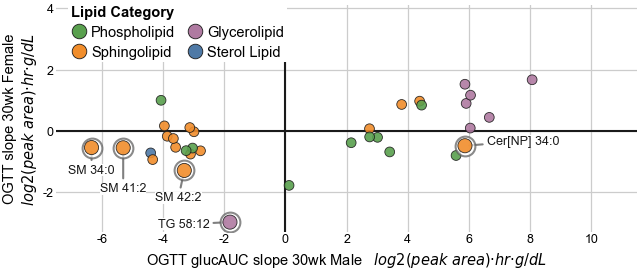

In [434]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2.5))
importlib.reload(src.plots)
vldata['size_dummy'] = 0
x, y =  'coef_male_ogtt_fixed', 'coef_female_ogtt_fixed'
# Multiply by 60 and 1000 to convert to 1e3 of new units
vldata[x] = vldata['coef_male_ogtt']   * 60 * 1000
vldata[y] = vldata['coef_female_ogtt'] * 60 * 1000
pval_cutoff = 0.05
df = vldata.loc[(vldata['pval_male_ogtt'] < pval_cutoff) | (vldata['pval_female_ogtt'] < pval_cutoff)].copy()
outliers = {
    'vl_6200': dict(x=10, y=0),  # TG 55:3
    'vl_6379': dict(x=7, y=3),  # TG 60:4
    'vl_5645': dict(x=8, y=0),    # TG 50:3
    'vl_6431': dict(x=10, y=-7),  # TG 18:2 18:1 23:0
    'vl_6458': dict(x=8, y=6),   # TG 18:2 18:1 24:0  60:3
#         'vl_6461': dict(x=1, y=-9),  # TG 58:2
#         'vl_6436': dict(x=-2, y=9),  # TG 57:2
#         'vl_6183': dict(x=-2, y=8),  # TG 53:2
#         'vl_5748': dict(x=2, y=8),  # TG 57:7

    'vl_2305':  dict(x=-2, y=9),  # PC 33:3
    'vl_5226': dict(x=0, y=-10),  # TG 16:0 20:5 22:6  58:11
    'vl_5124': dict(x=0, y=-10),  # TG 18:2 20:5 22:5
    'vl_2813': dict(x=-4, y=-10),  # PC 41:6
    'vl_3013': dict(x=10, y=2),  # Cer[NP] t18:0 16:0
    'vl_4879': dict(x=9, y=0),  # TG 22:6 66:18
#         'vl_5174': dict(x=7, y=0),  #  TG 52:7

    'vl_4920': dict(x=-8, y=-1),  # TG 18:2 20:5 20:5  58:12
    'vl_2876': dict(x=0, y=-10),  # SM d34:0
    'vl_4004': dict(x=0, y=-18),  # SM d41:2
    'vl_4133': dict(x=-1, y=-12),  # SM d42:2
#         'vl_5883': dict(x=0, y=-10), # CE 18:2
    'vl_5024': dict(x=0, y=-10),  # TG 60:13
#     'vl_5224': dict(x=-2, y=-10),  # TG 60:12
    'vl_2167': dict(x=-5, y=-6),  #
    'vl_5156': dict(x=3, y=-7),  #  TG 

    'vl_2384': dict(x=0, y=10), # SM d42:7
    'vl_3484': dict(x=6, y=7),  # PC 40:5
#         'vl_6022': dict(x=0, y=10),  # TG 16:0 18:0 20:4  54:4
#         'vl_4657': dict(x=-2, y=25),  # GlcCer
    }
df['outlier'] = df.index.isin(outliers)
ax = src.plots.slope_vs_slope(
    df=df, x=x, y=y, metab_type='lipid', ax=ax, plot_unid=False, auto_ticks=False,
    size='outlier', alpha=0.9, aspect_equal=False, show_legend=False, )
notsignif = vldata.loc[(vldata['pval_male_ogtt']>pval_cutoff) & (vldata['ID'] != 'Unidentified') &
                       (vldata['pval_female_ogtt']>pval_cutoff)]
# sns.scatterplot(
#     data=notsignif, x=x, y=y, hue='superclass', palette=colors, ax=ax,
#     s=15, fc='0.9', linewidth=0.2, ec='0.1')
ax.set(xlabel=f'OGTT glucAUC slope 30wk Male   {src.plots.ogtt_gluc_slope}', 
       ylabel=f'OGTT slope 30wk Female\n{src.plots.ogtt_gluc_slope}', 
       ylim=[-3.3, 4.1], xlim=[-7.5, 11.5], aspect='equal'
      )
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(2))

for i, row in df.loc[df.index.isin(outliers)].iterrows():
    xy = (row[x], row[y])
    if 't' in outliers[i]:
        text = outliers[i]['t']
    else:
        text = row['ID']
    parse = src.utils.parse_lipid(text)
    text = f'{parse[0]} {parse[4]}'
    src.plots.annotate_point(
        text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=7)
entries = list(vldata['superclass'].unique()[1:])# + ['Not significant']
colors['Not significant'] = '0.9'
legend = src.plots.custom_legend(
    entries=entries, ax=ax, loc=(0.02, 0.75), palette=colors, ncol=2,
    title='Lipid Category', show_frame=True, frame_edgewidth=0., fontsize=7, ms=7,)
# bb = src.plots.tight_bbox(ax)
# ax.text(x=bb.x0, y=bb.y1, s='C', 
#         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
# plt.savefig('../reports/figures/Figure7/Fig7_slope_vs_slope_filtered.pdf', 
#             bbox_inches='tight', dpi=300)

In [435]:
# pdf = vldata.loc[vldata['is_id']].copy()
pdf = df.loc[df['ID'] != 'Unidentified'].copy()
pdf['i'] = pdf.index

px_colors = {'Phospholipid': 'green', 'Sphingolipid': 'orange', 
             'Glycerolipid': 'purple', 'Sterol Lipid': 'blue'}

px.scatter(
    pdf, x='coef_male_ogtt', y='coef_female_ogtt', 
    color='superclass', color_discrete_map=px_colors,
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], )

In [417]:
# fig, ax = plt.subplots(dpi=300, figsize=(5, 5))
# slope_df = vldata.loc[vldata['is_id']]
# slope_df = slope_df.sort_values('superclass')
# sns.scatterplot(
#     data=slope_df, x='coef_male_ogtt', y='coef_female_ogtt', hue='superclass', palette=colors, edgecolor='none', alpha=0.7, zorder=10,)
# ## Label outliers 
# # for i, row in df.iterrows():
# #     if row['F_ogtt_slope'] > 0.00005 or row['F_ogtt_slope'] < -0.000038 or \
# #         row['M_ogtt_slope'] > 0.00015 or row['M_ogtt_slope'] < -0.00008:
# #         ax.text(row['M_ogtt_slope'], row['F_ogtt_slope'], row['ID'], 
# #                 fontsize=5, ha='center', va='center')
# ax.set_xlabel('30 wk Male OGTT slope')
# ax.set_ylabel('30 wk Female OGTT slope')
# ax.set_xticks([-10e-5, -5e-5, 0, 5e-5, 10e-5, 15e-5, 20e-5])
# ax.set_yticks([-5e-5, 0, 5e-5])
# ax.axvline(0, color='gray', lw=1, zorder=5)
# ax.axhline(0, color='gray', lw=1, zorder=5)
# ax.legend(loc=(1.01, 0))
# ax.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')
# ax.tick_params(length=0, pad=1, labelsize=7)
# ax.grid(lw=0.5)
# ax.set_axisbelow(True)
# ax.set_aspect('equal')
# ax.legend(loc=(1.02, 0), borderpad=0, labelspacing=0.34, frameon=False, handletextpad=0, fontsize=8)
# sns.despine(bottom=True, left=True, ax=ax)
# # plt.savefig('../reports/figures/Figure6/valdiation_ogtt_slope_vs_slope.pdf', bbox_inches='tight')

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


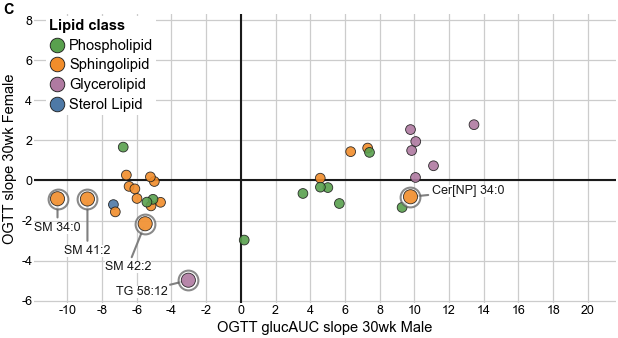

In [318]:
def slope_vs_slope_wrapper(ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(5, 2.5))
    importlib.reload(src.plots)
    vldata['size_dummy'] = 0
    df = vldata.loc[(vldata['pval_male_ogtt'] < 0.05) | (vldata['pval_female_ogtt'] < 0.05)]
    outliers = {
        'vl_6200': dict(x=10, y=0),  # TG 55:3
        'vl_6379': dict(x=10, y=3),  # TG 60:4
        'vl_5645': dict(x=8, y=0),    # TG 50:3
        'vl_6431': dict(x=10, y=-7),  # TG 18:2 18:1 23:0
        'vl_6458': dict(x=14, y=6),   # TG 18:2 18:1 24:0
#         'vl_6461': dict(x=1, y=-9),  # TG 58:2
#         'vl_6436': dict(x=-2, y=9),  # TG 57:2
#         'vl_6183': dict(x=-2, y=8),  # TG 53:2
#         'vl_5748': dict(x=2, y=8),  # TG 57:7

        'vl_2305':  dict(x=-2, y=9),  # PC 33:3
        'vl_5226': dict(x=0, y=-10),  # TG 16:0 20:5 22:6  58:11
        'vl_5124': dict(x=0, y=-10),  # TG 18:2 20:5 22:5
        'vl_2813': dict(x=-4, y=-10),  # PC 41:6
        'vl_3013': dict(x=10, y=2),  # Cer[NP] t18:0 16:0
        'vl_4879': dict(x=9, y=0),  # TG 22:6 66:18
#         'vl_5174': dict(x=7, y=0),  #  TG 52:7

        'vl_4920': dict(x=-8, y=-4),  # TG 18:2 20:5 20:5  58:12
        'vl_2876': dict(x=0, y=-10),  # SM d34:0
        'vl_4004': dict(x=0, y=-18),  # SM d41:2
        'vl_4133': dict(x=-3, y=-15),  # SM d42:2
#         'vl_5883': dict(x=0, y=-10), # CE 18:2
        'vl_5024': dict(x=0, y=-10),  # TG 60:13
    #     'vl_5224': dict(x=-2, y=-10),  # TG 60:12
        'vl_2167': dict(x=-5, y=-6),  #
        'vl_5156': dict(x=3, y=-7),  #  TG 


        'vl_2384': dict(x=0, y=10), # SM d42:7
        'vl_3484': dict(x=6, y=7),  # PC 40:5
#         'vl_6022': dict(x=0, y=10),  # TG 16:0 18:0 20:4  54:4
#         'vl_4657': dict(x=-2, y=25),  # GlcCer
        }
    df['outlier'] = df.index.isin(outliers)
    src.plots.slope_vs_slope(
        df=df, x='coef_male_ogtt', y='coef_female_ogtt', metab_type='lipid', ax=ax,
        size='outlier', alpha=0.9, aspect_equal=False, show_legend=False, )
    ax.set_xlim(-11.9e-5, 21.6e-5)
    ax.set_ylim(-6.1e-5, 8.3e-5)
    ax.set_xlabel('OGTT glucAUC slope 30wk Male')
    ax.set_ylabel('OGTT slope 30wk Female')
    for i, row in df.loc[df.index.isin(outliers)].iterrows():
        xy = (row['coef_male_ogtt'], row['coef_female_ogtt'])
        if 't' in outliers[i]:
            text = outliers[i]['t']
        else:
            text = row['ID']
        parse = src.utils.parse_lipid(text)
        text = f'{parse[0]} {parse[4]}'
        src.plots.annotate_point(
            text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=7)
    legend = src.plots.custom_legend(
        vldata['superclass'].unique()[1:], ax, loc=(0.02, 0.65),
        title='Lipid class', show_frame=True, frame_edgewidth=0, fontsize=7, ms=7,)
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s='C', 
            fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
    return ax
ax = slope_vs_slope_wrapper()
# plt.savefig('../reports/figures/Figure7/Fig7_slope_vs_slope_v2.pdf', bbox_inches='tight', dpi=300)

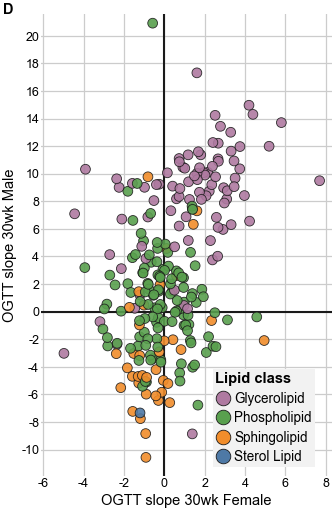

In [14]:
def slope_vs_slope_wrapper(ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(2.5, 4))
    importlib.reload(src.plots)
    vldata['size_dummy'] = 0
    df = vldata.copy()
    outliers = {
#         'vl_6200': dict(x=-10, y=0),  # TG 55:3
#         'vl_6379': dict(x=10, y=3),  # TG 60:4
#         'vl_5645': dict(x=8, y=0),    # TG 50:3
#         'vl_6431': dict(x=10, y=-7),  # TG 18:2 18:1 23:0
#         'vl_6458': dict(x=14, y=6),   # TG 18:2 18:1 24:0
#         'vl_6461': dict(x=1, y=-9),  # TG 58:2
#         'vl_6436': dict(x=-2, y=9),  # TG 57:2
#         'vl_6183': dict(x=-2, y=8),  # TG 53:2
#         'vl_5748': dict(x=2, y=8),  # TG 57:7

#         'vl_2305':  dict(x=-2, y=9),  # PC 33:3
#         'vl_5226': dict(x=0, y=-10),  # TG 16:0 20:5 22:6  58:11
#         'vl_5124': dict(x=0, y=-10),  # TG 18:2 20:5 22:5
#         'vl_2813': dict(x=-4, y=-10),  # PC 41:6
#         'vl_3013': dict(x=10, y=2),  # Cer[NP] t18:0 16:0
#         'vl_4879': dict(x=-2, y=-9),  # TG 22:6 66:18
#         'vl_5174': dict(x=7, y=0),  #  TG 52:7

#         'vl_4920': dict(x=-8, y=-4),  # TG 18:2 20:5 20:5  58:12
#         'vl_2876': dict(x=0, y=-10),  # SM d34:0
#         'vl_4004': dict(x=0, y=-18),  # SM d41:2
#         'vl_4133': dict(x=-3, y=-15),  # SM d42:2
#         'vl_5883': dict(x=0, y=-10), # CE 18:2
#         'vl_5024': dict(x=0, y=-10),  # TG 60:13
#     #     'vl_5224': dict(x=-2, y=-10),  # TG 60:12
#         'vl_2167': dict(x=-5, y=-6),  #
#         'vl_5156': dict(x=3, y=-7),  #  TG 


#         'vl_2384': dict(x=0, y=10), # SM d42:7
#         'vl_3484': dict(x=6, y=7),  # PC 40:5
#         'vl_6022': dict(x=0, y=10),  # TG 16:0 18:0 20:4
#         'vl_4657': dict(x=-2, y=25),  # Cer
        }
    df['outlier'] = df.index.isin(outliers)
    src.plots.slope_vs_slope(
        df=df, x='coef_female_ogtt', y='coef_male_ogtt', metab_type='lipid', ax=ax,
        size='outlier', alpha=0.9, aspect_equal=False, show_legend=False, )
#     ax.set_aspect('equal')
    ax.set_ylim(-11.9e-5, 21.6e-5)
    ax.set_xlim(-6.1e-5, 8.3e-5)
    ax.set_ylabel('OGTT slope 30wk Male')
    ax.set_xlabel('OGTT slope 30wk Female')
    for i, row in df.loc[outliers].iterrows():
        xy = (row['coef_male_ogtt'], row['coef_female_ogtt'])
        if 't' in outliers[i]:
            text = outliers[i]['t']
        else:
            text = row['ID']
        parse = src.utils.parse_lipid(text)
        text = f'{parse[0]} {parse[4]}'
        src.plots.annotate_point(
            text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=7)
    legend = src.plots.custom_legend(
        vldata['superclass'].unique()[1:], ax, loc=(0.59, 0.02),
        title='Lipid class', show_frame=True, fontsize=6.5, ms=7,
    )
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s='D', 
            fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
    return ax
ax = slope_vs_slope_wrapper()
# plt.savefig('../reports/figures/Figure7/Fig7D_slope_vs_slope_vertical_orientation.pdf', 
#             bbox_inches='tight', dpi=300)

# Correlation of each lipid to OGTT in 10wk, 30wk male, 30wk female

## First, align IDs between datasets

In [232]:
ddf = data.loc[(data['ID'] != 'Unidentified') & (data['Type'] == 'lipid')].copy()
vdf = vldata.loc[vldata['is_id']].copy()

ddf['name'] = ddf['molec_class'] + ' ' + ddf['fa_carbon:unsat']
vdf['name'] = vdf['molec_class'] + ' ' + vdf['fa_carbon:unsat']

align_d = {}
for d_i, dname in ddf['name'].iteritems():
    align_d[d_i] = []
    for v_i, vname in vdf['name'].iteritems():
        if dname == vname:
            align_d[d_i].append(v_i)
            
matches = [(x, align_d[x][0]) for x in align_d if len(align_d[x]) == 1]
matches = pd.DataFrame(matches, columns=['original', 'val']).merge(
    data[['ID', 'molec_class', 'superclass']], left_on='original', right_index=True)
matches

,original,val,ID,molec_class,superclass
0,l_53,vl_948,LysoPC 17:0,LysoPC,Phospholipid
1,l_55,vl_946,LysoPC 20:2,LysoPC,Phospholipid
2,l_56,vl_948,LysoPC 17:0,LysoPC,Phospholipid
3,l_62,vl_1056,LysoPC 18:0,LysoPC,Phospholipid
4,l_65,vl_1056,LysoPC 18:0,LysoPC,Phospholipid
...,...,...,...,...,...
154,l_900,vl_6431,TG 18:2_18:1_23:0,TG,Glycerolipid
155,l_905,vl_6436,TG 57:2,TG,Glycerolipid
156,l_907,vl_6454,TG 56:1,TG,Glycerolipid
157,l_908,vl_6458,TG 18:2_18:1_24:0,TG,Glycerolipid


## Next calculate correlation values in each dataset

In [686]:
mogtt = fg.loc[fg['validation'] & (fg['sex'] == 'M') & (fg['cohort'] == '30wk'), 'ogtt']
fogtt = fg.loc[fg['validation'] & (fg['sex'] == 'F') & (fg['cohort'] == '30wk'), 'ogtt']

o_fed_ogtt_corr    = ddf.loc[matches['original'], rbg_cols].T.corrwith(fg['ogtt'])
o_fasted_ogtt_corr = ddf.loc[matches['original'], fbg_cols].T.corrwith(fg['ogtt'])
v_male_ogtt_corr = vdf.loc[matches['val'], mogtt.index].T.corrwith(fg['ogtt'])
v_female_ogtt_corr = vdf.loc[matches['val'], fogtt.index].T.corrwith(fg['ogtt'])
o_fed_ogtt_corr.name = 'orig_fed_corr'
o_fasted_ogtt_corr.name = 'orig_fasted_corr'
v_male_ogtt_corr.name = 'val_male_corr'
v_female_ogtt_corr.name = 'val_female_corr'

mdf = matches.merge(o_fed_ogtt_corr, left_on='original', right_index=True)
mdf =     mdf.merge(o_fasted_ogtt_corr, left_on='original', right_index=True)
mdf =     mdf.merge(v_male_ogtt_corr, left_on='val', right_index=True)
mdf =     mdf.merge(v_female_ogtt_corr, left_on='val', right_index=True)

# for some reason, things are getting duplicated, so filter:
vc = mdf['original'].value_counts()
unique = vc.loc[vc == 1].index
mdf = mdf.loc[mdf['original'].isin(unique)]

# Filter for minimum abs(pearson corr)
mdf = mdf.loc[(mdf[['val_male_corr', 'val_female_corr']].abs() > 0.32).any(axis=1)
              | (mdf['superclass'] == 'Sphingolipid')
             ]
mdf = mdf.merge(data[['fa_carbons', 'fa_unsat', 'fa_carbon:unsat']], left_on='original', right_index=True)
mdf['unsat/carbon'] = mdf['fa_unsat'] / mdf['fa_carbons']
mdf = mdf.sort_values(['superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])
mdf['IDshort'] = mdf['molec_class'].map(class_abbrevs) + ' ' + mdf['fa_carbon:unsat']
mdf['IDshort'] = mdf['IDshort'].str.replace('- ', '-')
mdf

,original,val,ID,molec_class,superclass,orig_fed_corr,orig_fasted_corr,val_male_corr,val_female_corr,fa_carbons,fa_unsat,fa_carbon:unsat,unsat/carbon,IDshort
125,l_719,vl_5587,TG 46:1,TG,Glycerolipid,0.507784,-0.335384,0.460033,0.207097,46.0,1.0,46:1,0.021739,TG 46:1
118,l_674,vl_5383,TG 46:2,TG,Glycerolipid,0.530427,-0.452318,0.592270,0.051493,46.0,2.0,46:2,0.043478,TG 46:2
141,l_835,vl_6068,TG 16:0_16:0_16:0,TG,Glycerolipid,0.635366,0.189148,0.546620,0.188953,48.0,0.0,48:0,0.000000,TG 48:0
132,l_774,vl_5809,TG 48:1,TG,Glycerolipid,0.519113,-0.158653,0.504864,-0.017798,48.0,1.0,48:1,0.020833,TG 48:1
126,l_724,vl_5603,TG 48:2,TG,Glycerolipid,0.551535,-0.222676,0.542896,0.009924,48.0,2.0,48:2,0.041667,TG 48:2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,l_547,vl_4558,SM d42:1,SM,Sphingolipid,0.078997,0.048794,-0.515909,-0.152380,42.0,1.0,42:1,0.023810,SM 42:1
98,l_520,vl_4133,SM d42:2,SM,Sphingolipid,0.207297,0.118908,-0.540233,-0.417619,42.0,2.0,42:2,0.047619,SM 42:2
105,l_570,vl_4720,SM d43:1,SM,Sphingolipid,-0.031969,-0.205405,-0.422875,-0.066068,43.0,1.0,43:1,0.023256,SM 43:1
101,l_534,vl_4314,SM d43:2,SM,Sphingolipid,0.164484,-0.131668,-0.236649,0.089470,43.0,2.0,43:2,0.046512,SM 43:2


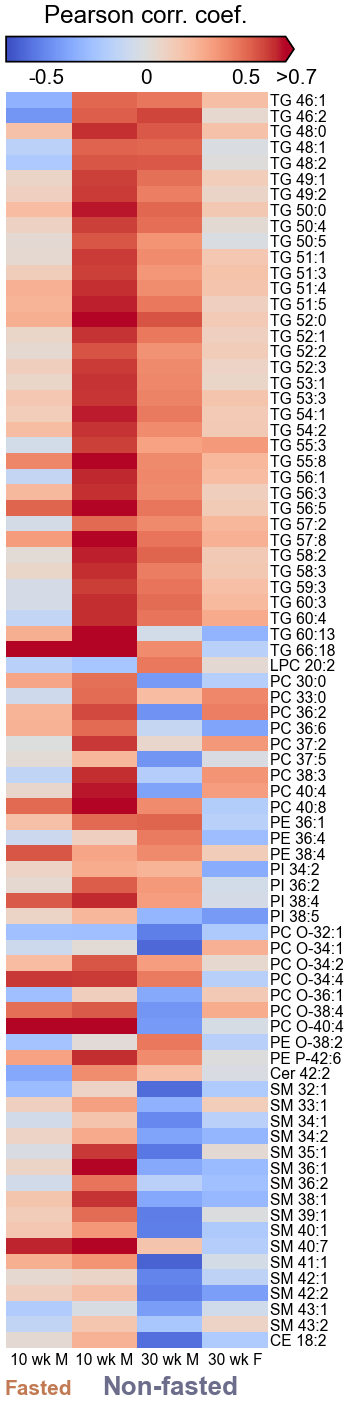

In [712]:
df = mdf[['orig_fasted_corr', 'orig_fed_corr', 'val_male_corr', 'val_female_corr']]
cmap = 'coolwarm'
vmin, vmax = -0.7, 0.7
cm = sns.clustermap(
    data=df,
    col_cluster=False, row_cluster=False,
    dendrogram_ratio=0.001, # colors_ratio=[0.08, 0],
    figsize=(1.8, 6), 
#     row_colors=mdf['superclass'].map(colors),
    cmap=cmap, vmin=vmin, vmax=vmax,
    cbar=False,
#     cbar_pos=(0.86, 0.15, 0.07, 0.14), 
    yticklabels=mdf['IDshort'],
)
fig = cm.fig
fig.set_dpi(250)
hm = cm.ax_heatmap
hm.tick_params(axis='y', labelsize=4.5, length=0, pad=0.5)
hm.set_xticks([0.5, 1.5, 2.5, 3.5], ['10 wk M', '10 wk M', '30 wk M', '30 wk F'],
    fontsize=4.5, rotation=0)
hm.tick_params(axis='x', length=0, pad=1.5)
hm.text(0.5, len(mdf)+3, 'Fasted', color=colors['Fasted'], ha='center', fontsize=6, fontweight='bold')
hm.text(2.5, len(mdf)+3, 'Non-fasted', color=colors['Fed'], ha='center', fontsize=7.5, fontweight='bold')

cm.ax_cbar.remove()  # Otherwise ghostly ticks appear 
cbar, cax = src.plots.custom_colorbar(
    ax=hm, vmin=vmin, vmax=vmax, vcenter=0, palette=cmap, extend='max', extendfrac=0.03,
    orientation='horizontal', bbox=[0, 1.024, 1.1, 0.02],
#     label='hi', 
)
cax.set_xticks([-0.5, 0, 0.5, vmax], ['-0.5', '0', '0.5', '    >0.7'])
cax.tick_params(pad=2, length=0)
cax.set_title('Pearson corr. coef.', fontsize=7)

# cm.ax_row_colors.set_xticks([0.5], ['Lipid\nclass'], rotation=90, ha='center')
# cm.ax_cbar.set_ylabel('Pearson correlation', rotation=270, va='center')
# cm.ax_cbar.set_yticks([])
# cm.ax_cbar.tick_params(length=0, pad=-5)
# for tick in [-0.5, 0, 0.5]:
#     cm.ax_cbar.text(0.5, tick, tick, color='0.05', fontsize=6, fontweight='bold', ha='center')
# cm.ax_cbar.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5], color='white', zorder=10)
# cm.ax_cbar.set_zorder(0)
bb = src.plots.tight_bbox(cm.ax_row_dendrogram)
# cm.ax_row_dendrogram.text(x=bb.x0, y=bb.y1, s='C', 
#         fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
plt.savefig('../reports/figures/Figure7/Fig7_ogtt_corr_heatmap_v2.pdf', bbox_inches='tight', dpi=300)

# Try bringing in the diet study results (fed rodent chow vs rabbit chow)
## Use the Last RBG metric to correlate to lipids

1. Align all possible lipids 
    1. Define lipids that are not sum composition
    1. Align all of the non-sum composition IDs
    2. After that, calculate the sum comp for all lipids
    3. Discard any IDs with overlapping sum compositions in any of the 3 datasets
    4. Then discard the IDs that were not sum composition 
    5. 

In [246]:
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
datad = pd.read_csv('../data/processed/diet_study_lipidomics.csv', index_col=0)
data['shortID'] = data['molec_class'] + ' ' + data['fa_carbon:unsat']

# olid = Original Lipid IDs
olid = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')] 
# data lacks an 'is_sum_comp' column
olid['is_sum_comp'] = olid['ID'].apply(lambda x: src.utils.parse_lipid(x)[-1])

# vlid = Validation Lipid IDs
vlid = vldata.loc[(vldata['Type'] == 'lipid') & (vldata['ID'] != 'Unidentified')] 
vlid['is_sum_comp'] = vlid['is_sum_comp'].astype(bool)

# datad = Data from Diet experiment --> Already contains only IDs
diet = datad.loc[datad['fa_carbons'].notna()]  # Filter out 5 classes
diet['is_sum_comp'] = diet['is_sum_comp'].astype(bool)

dfs = [olid, vlid, diet]

# Create shortened IDs with just molecule class and the sum composition
for df in dfs:
    df['shortID'] = df['molec_class'] + ' ' + df['fa_carbon:unsat']

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

# Step 1: Find all non-sumcomp lipids that are in all 3 datasets:
## Some of the sum composition IDs have duplicates so just drop them
## `nonsc_all3` is a lookup table of all lipids with their indexes that are not sum composition and are found in all 3 datasets

In [249]:
nonsc = [
    olid.loc[~olid['is_sum_comp']].copy().drop_duplicates(subset='ID', keep=False),
    vlid.loc[~vlid['is_sum_comp']].copy().drop_duplicates(subset='ID', keep=False),
    diet.loc[~diet['is_sum_comp']].copy().drop_duplicates(subset='ID', keep=False),
]

nonsc_all3 = {}
df0 = nonsc[0]
df1 = nonsc[1]
df2 = nonsc[2]
for df0_i, row in nonsc[0].iterrows():
    rowid = row['ID']
    if (rowid in df1['ID'].to_list()) and (rowid in df2['ID'].to_list()):
        df1_i = df1.loc[df1['ID'] == row['ID']].index[0]
        df2_i = df2.loc[df2['ID'] == row['ID']].index[0]
        nonsc_all3[rowid] = {'o': df0_i, 'v': df1_i, 'd': df2_i}
        
        # Find the other lipids in each dataframe that have same shortID
        df0_others = df0.loc[df0['shortID'] == df0.loc[df0_i, 'shortID']]
        df1_others = df1.loc[df1['shortID'] == df1.loc[df1_i, 'shortID']]
        df2_others = df2.loc[df2['shortID'] == df2.loc[df2_i, 'shortID']]
        
        if len(df0_others) > 1:
            nonsc_all3[rowid]['o_others'] = df0_others.index
        if len(df1_others) > 1:
            nonsc_all3[rowid]['v_others'] = df1_others.index
        if len(df2_others) > 1:
            nonsc_all3[rowid]['d_others'] = df2_others.index

nonsc_all3_df = pd.DataFrame(nonsc_all3).T
nonsc_all3_df

,o,v,d,o_others,v_others,d_others
LysoPC 20:2,l_55,vl_946,dl_38,NaN,NaN,NaN
PI 16:0_20:4,l_160,vl_2079,dl_183,NaN,NaN,NaN
PI 16:0_18:2,l_168,vl_2146,dl_194,NaN,NaN,NaN
PC 18:3_18:2,l_179,vl_2178,dl_211,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')","Index(['dl_211', 'dl_256'], dtype='object')"
PC 14:0_18:2,l_206,vl_2327,dl_244,NaN,NaN,NaN
PC 18:2_20:4,l_213,vl_2375,dl_254,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')","Index(['dl_254', 'dl_290'], dtype='object')"
PC 16:0_20:5,l_216,vl_2388,dl_256,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')","Index(['dl_211', 'dl_256'], dtype='object')"
PI 18:0_20:4,l_227,vl_2463,dl_258,NaN,NaN,NaN
PC 18:2_18:2,l_235,vl_2456,dl_270,"Index(['l_235', 'l_279'], dtype='object', name...","Index(['vl_2456', 'vl_2723'], dtype='object')","Index(['dl_270', 'dl_331'], dtype='object')"
PC 16:0_22:6,l_252,vl_2552,dl_290,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')","Index(['dl_254', 'dl_290'], dtype='object')"


## Now go through and remove all the indexes in `o_others`,   `v_others` and `d_others` for the next step of searching

In [250]:
o_indexes = []
[o_indexes.extend(x) for x in nonsc_all3_df['o_others'].dropna()]
v_indexes = []
[v_indexes.extend(x) for x in nonsc_all3_df['v_others'].dropna()]
d_indexes = []
[d_indexes.extend(x) for x in nonsc_all3_df['d_others'].dropna()]

dfs[0] = dfs[0].drop(o_indexes, errors='ignore')
dfs[1] = dfs[1].drop(v_indexes, errors='ignore')
dfs[2] = dfs[2].drop(d_indexes, errors='ignore')

## Drop all that  have duplicate `shortID`s

In [251]:
dfs[0].drop_duplicates(subset='shortID', keep=False, inplace=True)
dfs[1].drop_duplicates(subset='shortID', keep=False, inplace=True)
dfs[2].drop_duplicates(subset='shortID', keep=False, inplace=True)

## Now repeat similar logic as above, for all the rows remaining 

In [252]:
df0 = dfs[0]
df1 = dfs[1]
df2 = dfs[2]
for df0_i, row in df0.iterrows():
    rowid = row['ID']
    if (rowid in df1['ID'].to_list()) and (rowid in df2['ID'].to_list()):
        df1_i = df1.loc[df1['ID'] == row['ID']].index[0]
        df2_i = df2.loc[df2['ID'] == row['ID']].index[0]
        nonsc_all3[rowid] = {'o': df0_i, 'v': df1_i, 'd': df2_i}
        
nonsc_all3 = pd.DataFrame(nonsc_all3).T
nonsc_all3.iloc[:50]

,o,v,d,o_others,v_others,d_others
LysoPC 20:2,l_55,vl_946,dl_38,NaN,NaN,NaN
PI 16:0_20:4,l_160,vl_2079,dl_183,NaN,NaN,NaN
PI 16:0_18:2,l_168,vl_2146,dl_194,NaN,NaN,NaN
PC 18:3_18:2,l_179,vl_2178,dl_211,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')","Index(['dl_211', 'dl_256'], dtype='object')"
PC 14:0_18:2,l_206,vl_2327,dl_244,NaN,NaN,NaN
PC 18:2_20:4,l_213,vl_2375,dl_254,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')","Index(['dl_254', 'dl_290'], dtype='object')"
PC 16:0_20:5,l_216,vl_2388,dl_256,"Index(['l_179', 'l_216'], dtype='object', name...","Index(['vl_2178', 'vl_2388'], dtype='object')","Index(['dl_211', 'dl_256'], dtype='object')"
PI 18:0_20:4,l_227,vl_2463,dl_258,NaN,NaN,NaN
PC 18:2_18:2,l_235,vl_2456,dl_270,"Index(['l_235', 'l_279'], dtype='object', name...","Index(['vl_2456', 'vl_2723'], dtype='object')","Index(['dl_270', 'dl_331'], dtype='object')"
PC 16:0_22:6,l_252,vl_2552,dl_290,"Index(['l_213', 'l_252'], dtype='object', name...","Index(['vl_2375', 'vl_2552'], dtype='object')","Index(['dl_254', 'dl_290'], dtype='object')"


# For all 3 datasets, calculate the correlation to the furthest-in-the-future random blood glucose 

In [276]:
apd

,age,sex,bodyweight,lastRBG,meanRBG,HbA1c,Interscapular_Brown_Fat,Interscapular_white_fat,Inguinal_white_fat,diabetic,diet,animal,last_meal,has_eaten_rodent_chow,test_combo
Nile_rat_ID,,,,,,,,,,,,,,,
550,12,M,115.2,394,249.666667,5.9,1.78,NaN,0.81,True,Rodent,550,Rodent,True,True Rodent
571,12,M,111.0,242,217.333333,5.2,2.70,NaN,1.06,True,Rodent,571,Rodent,True,True Rodent
582,12,M,119.0,184,154.000000,4.9,2.86,NaN,1.20,True,Rodent,582,Rodent,True,True Rodent
551,12,M,105.5,105,96.666667,4.0,2.13,NaN,0.81,False,Rodent,551,Rodent,True,True Rodent
562,12,M,113.9,52,71.666667,4.0,2.67,NaN,0.96,False,Rodent,562,Rodent,True,True Rodent
568,12,M,106.0,73,66.666667,NaN,2.02,NaN,0.84,False,Rodent,568,Rodent,True,True Rodent
569,12,M,93.0,65,78.000000,NaN,1.57,NaN,0.69,False,Rodent,569,Rodent,True,True Rodent
553,12,M,105.5,105,96.666667,4.0,0.36,NaN,0.17,False,Rodent to Rabbit,553,Rabbit,True,True Rabbit
552,12,M,79.6,52,70.666667,4.0,0.59,NaN,0.24,False,Rodent to Rabbit,552,Rabbit,True,True Rabbit


<AxesSubplot:>

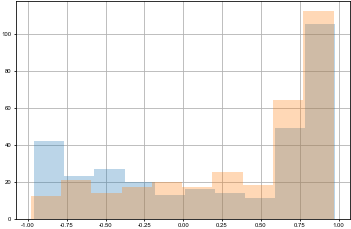

In [318]:
lastrbg = ap['lastRBG']
lastrbg.index = lastrbg.index.astype('str')

data['nonfast12corr'] = (data.loc[:, rbg_cols]
                         .T
                         .groupby(fg['animal']).mean()
                         .corrwith(lastrbg))
data['fasted12corr'] =  (data.loc[:, fbg_cols]
                         .T
                         .groupby(fg['animal']).mean()
                         .corrwith(lastrbg))

wk30cols = fg.loc[(fg['cohort'] == '30wk') & fg['quant_file'] & (fg['validation'])]
m30cols = wk30cols.loc[wk30cols['sex'] == 'M'].index
f30cols = wk30cols.loc[wk30cols['sex'] == 'F'].index
vldata['m30corr'] = (vldata[m30cols]
                     .T
                     .groupby(fg['animal']).mean()
                     .corrwith(lastrbg))
vldata['f30corr'] = (vldata[f30cols]
                     .T
                     .groupby(fg['animal']).mean()
                     .corrwith(lastrbg))

diet_lastrbgs = apd.loc[:, 'lastRBG']
diet_lastrbgs.index = diet_lastrbgs.index.astype('str')


rodent_idx = apd.loc[apd['diet'] == 'Rodent'].index.astype('str')
rab2rod_idx = apd.loc[apd['diet'] == 'Rabbit to Rodent'].index.astype('str')
rabbit_idx = apd.loc[apd['diet'] == 'Rabbit'].index.astype('str')
rod2rab_idx = apd.loc[apd['diet'] == 'Rodent to Rabbit'].index.astype('str')

datad['rodentcorr'] = datad.loc[:, rodent_idx.astype('str')].T.corrwith(diet_lastrbgs)
datad['rab2rodcorr'] = datad.loc[:, rab2rod_idx.astype('str')].T.corrwith(diet_lastrbgs)
datad['rabbitcorr'] = datad.loc[:, rabbit_idx.astype('str')].T.corrwith(diet_lastrbgs)
datad['rod2rabcorr'] = datad.loc[:, rod2rab_idx.astype('str')].T.corrwith(diet_lastrbgs)
datad['rodentcorr'].hist(alpha=0.3)
datad['rab2rodcorr'].hist(alpha=0.3)

In [319]:
rdf = nonsc_all3.iloc[:, :3]
rdf = (rdf
        .merge(data[['shortID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat']], 
              left_on='o', right_index=True, how='left')
        .merge(data[['nonfast12corr', 'fasted12corr']], left_on='o', right_index=True)
        .merge(datad[['rodentcorr', 'rab2rodcorr', 'rabbitcorr', 'rod2rabcorr']], left_on='d', right_index=True)
        .merge(vldata[['m30corr', 'f30corr']], left_on='v', right_index=True)
        .sort_values(['superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])
      )
rdf['class'] = rdf['molec_class'].map(colors)
rdf

,o,v,d,shortID,superclass,molec_class,fa_carbons,fa_unsat,nonfast12corr,fasted12corr,rodentcorr,rab2rodcorr,rabbitcorr,rod2rabcorr,m30corr,f30corr,class
TG 46:2,l_674,vl_5383,dl_872,TG 46:2,Glycerolipid,TG,46.0,2.0,0.478423,-0.775102,0.800737,0.754461,0.183163,0.759224,0.923018,0.651327,"[0.6875, 0.4765625, 0.6328125]"
TG 48:1,l_774,vl_5809,dl_976,TG 48:1,Glycerolipid,TG,48.0,1.0,0.456258,-0.482828,0.788283,0.787806,0.635493,0.694729,0.901748,0.621096,"[0.6875, 0.4765625, 0.6328125]"
TG 48:2,l_724,vl_5603,dl_930,TG 48:2,Glycerolipid,TG,48.0,2.0,0.484375,-0.554256,0.799773,0.788345,0.677921,0.725504,0.917104,0.573930,"[0.6875, 0.4765625, 0.6328125]"
TG 49:1,l_802,vl_5935,dl_1000,TG 49:1,Glycerolipid,TG,49.0,1.0,0.561079,-0.088337,0.878989,0.868014,0.422339,0.401185,0.970716,0.619054,"[0.6875, 0.4765625, 0.6328125]"
TG 49:2,l_754,vl_5720,dl_955,TG 49:2,Glycerolipid,TG,49.0,2.0,0.592888,-0.025956,0.879328,0.858071,0.439236,0.694480,0.932871,0.650226,"[0.6875, 0.4765625, 0.6328125]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SM d42:1,l_547,vl_4558,dl_712,SM 42:1,Sphingolipid,SM,42.0,1.0,0.007778,0.293092,-0.861955,-0.776319,0.008953,-0.416651,-0.983167,-0.612846,"[0.9453125, 0.5546875, 0.16796875]"
SM d42:2,l_520,vl_4133,dl_641,SM 42:2,Sphingolipid,SM,42.0,2.0,0.190127,0.334833,-0.823081,-0.577576,-0.420997,-0.701454,-0.915671,-0.542291,"[0.9453125, 0.5546875, 0.16796875]"
SM d43:1,l_570,vl_4720,dl_740,SM 43:1,Sphingolipid,SM,43.0,1.0,-0.178780,-0.249826,-0.763893,-0.780746,0.444696,0.770826,-0.893037,-0.772139,"[0.9453125, 0.5546875, 0.16796875]"
SM d43:2,l_534,vl_4314,dl_679,SM 43:2,Sphingolipid,SM,43.0,2.0,0.447271,0.124729,-0.736910,-0.625634,0.013387,0.385400,-0.912435,-0.358118,"[0.9453125, 0.5546875, 0.16796875]"


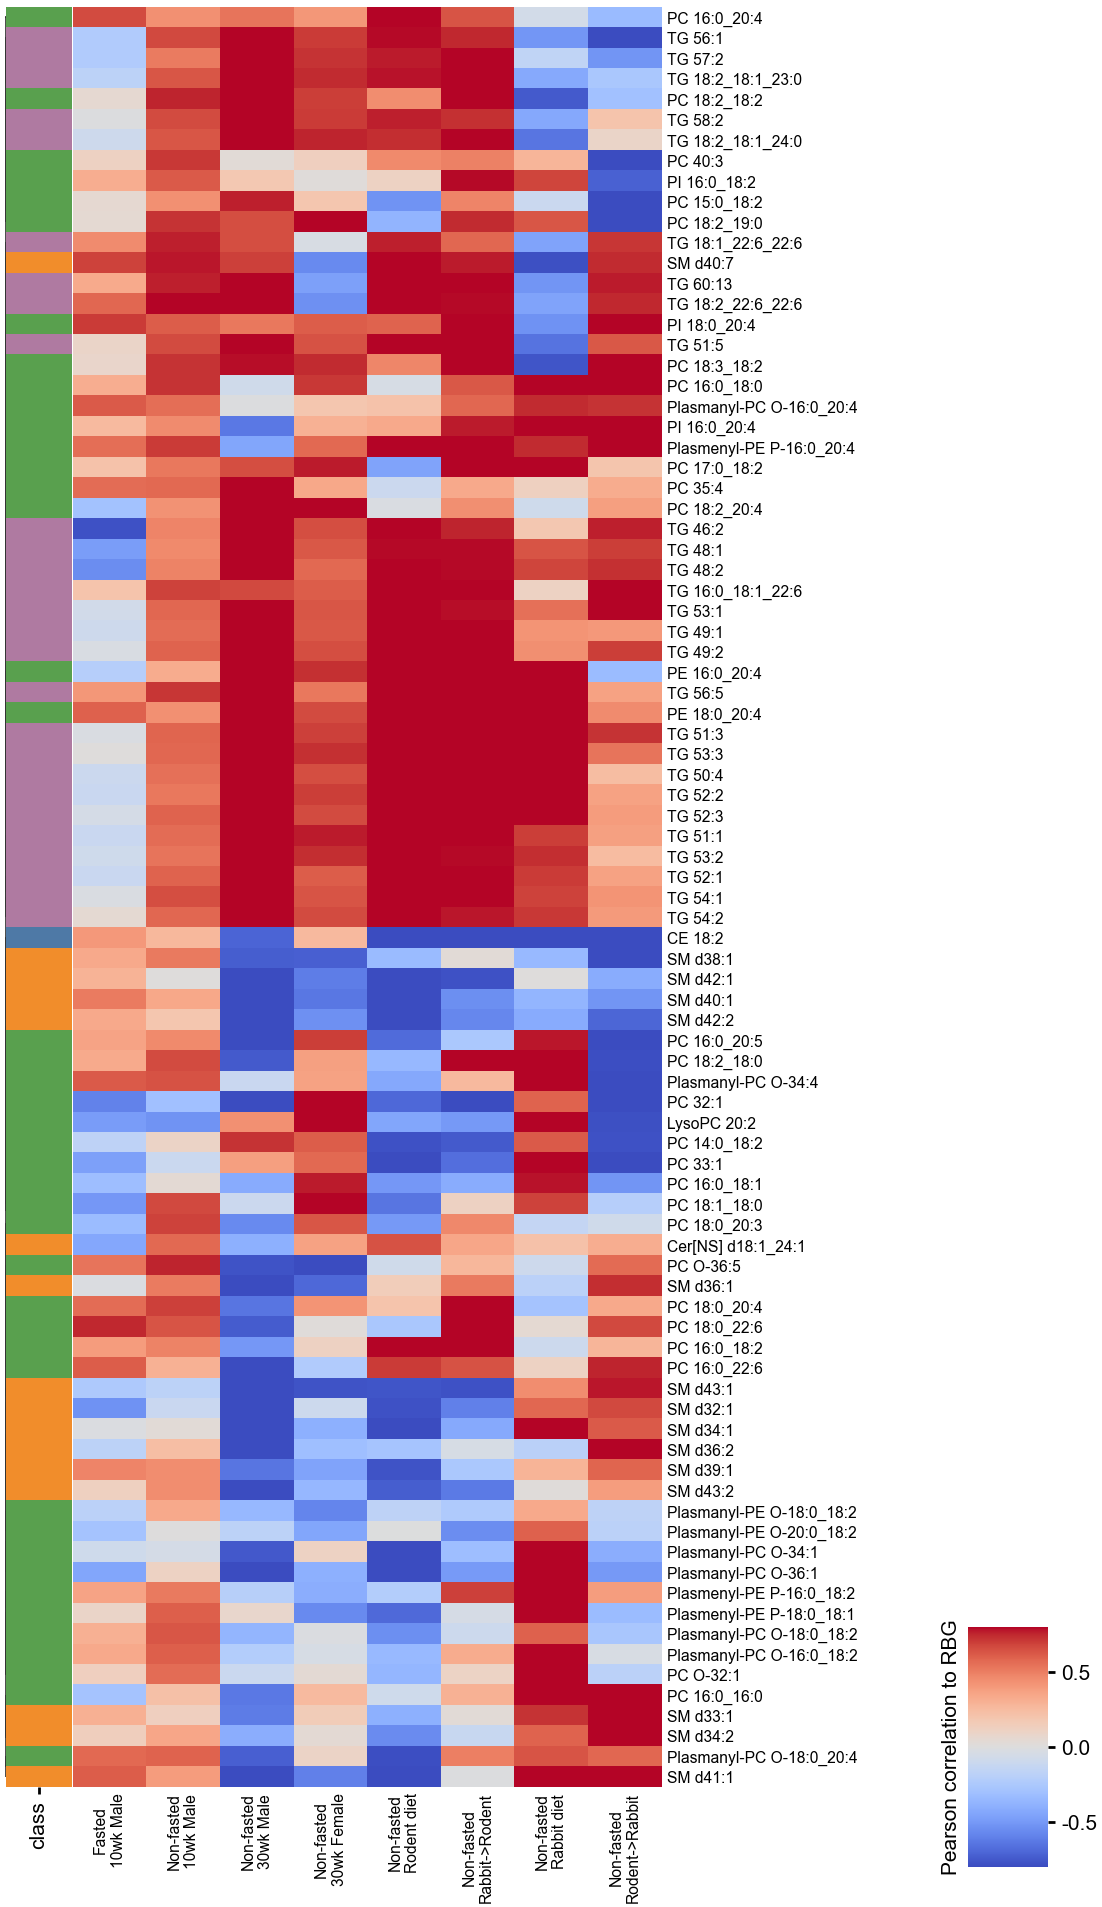

In [327]:
cm = sns.clustermap(
    data=rdf[[
        'fasted12corr', 'nonfast12corr', 
        'm30corr', 'f30corr',
        'rodentcorr', 'rab2rodcorr', 'rabbitcorr', 'rod2rabcorr' 
    ]],
    row_cluster=True, col_cluster=False, dendrogram_ratio=[0.001, 0.001], colors_ratio=[0.1, 0],
    row_colors=rdf['class'],
    method='complete', 
    center=0, vmin=-0.8, vmax=0.8,
    cmap='coolwarm',
    yticklabels=rdf.index,
    figsize=(4, 8), cbar_pos=(1, 0.05, 0.08, 0.12),
)
fig = plt.gcf()
fig.set(dpi=250, facecolor='white')
axh = cm.ax_heatmap
axh.set_xticks(np.arange(0.5, 8.5, 1), 
               [
                'Fasted\n10wk Male', 'Non-fasted\n10wk Male', 
                'Non-fasted\n30wk Male', 'Non-fasted\n30wk Female',
                'Non-fasted\nRodent diet', 'Non-fasted\nRabbit->Rodent', 
                'Non-fasted\nRabbit diet', 'Non-fasted\nRodent->Rabbit'
                ])
axh.tick_params(length=0, pad=1.5, labelsize=4.5, )
axcb = cm.ax_cbar
axcb.set_ylabel('Pearson correlation to RBG', fontsize=6)
axcb.yaxis.set_label_position('left')
plt.savefig('../reports/figures/Figure7/Both_studies_RBG_corrs.pdf', bbox_inches='tight', dpi=300)

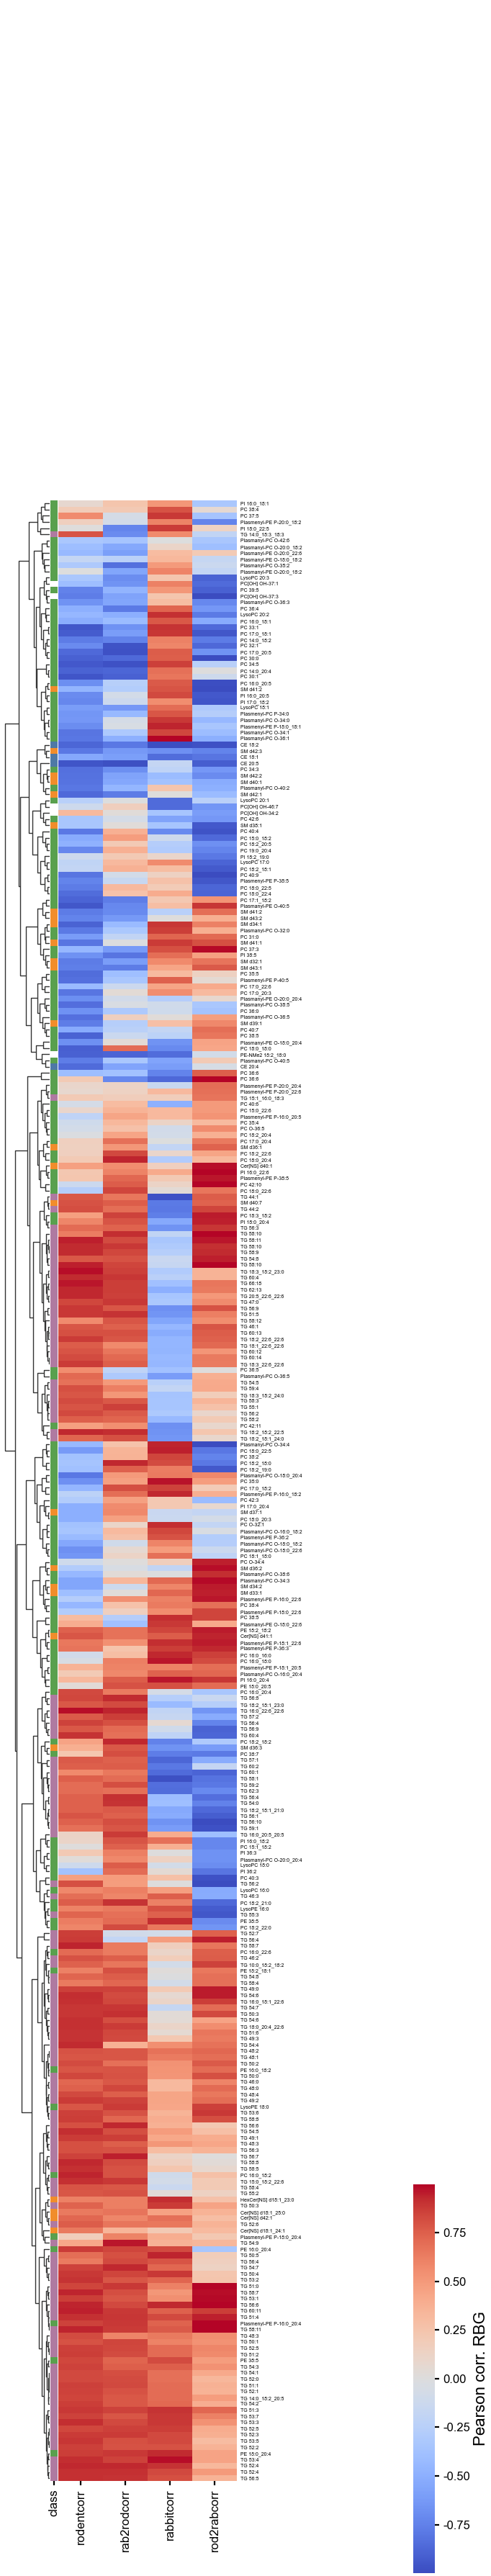

In [346]:
datad['class'] = datad['molec_class'].map(colors)
# subset = datad.loc[datad['molec_class'] == 'TG']
# subset = datad.loc[datad['superclass'] == 'Phospholipid']
subset = datad
cm = sns.clustermap(
    data=subset[['rodentcorr', 'rab2rodcorr', 'rabbitcorr', 'rod2rabcorr']],
    col_cluster=False, metric='cityblock', method='complete',
    row_colors=subset['class'],
    cmap='coolwarm',
    figsize=(3, 18),
    yticklabels=subset['ID'],
    cbar_pos=[1, 0, 0.05, 0.15],
    cbar_kws=dict(label='Pearson corr. RBG')
)
fig = plt.gcf()
fig.set(facecolor='white', dpi=200)
axh = cm.ax_heatmap
axh.tick_params(axis='y', pad=1.5, length=0, labelsize=2.5, rotation=0)
plt.savefig('../reports/figures/Figure7/diet study extras/all_lipids_RBG_corr.pdf', 
            bbox_inches='tight', dpi=300)

# Do quadrants enrich for certain levels of unsaturation? 

In [513]:
edf = vldata.loc[vldata['is_id']].copy()
# Drop slopes that are near zero

def get_quadrant(x, y):
    if x > 0 and y > 0: return 'q1'
    if x < 0 and y > 0: return 'q2'
    if x < 0 and y < 0: return 'q3'
    if x > 0 and y < 0: return 'q4'

# edf = edf.loc[(edf['coef_male_ogtt'].abs() > 1e-5) & 
#               (edf['coef_female_ogtt'].abs() > 1e-5)]
# edf['q1'] = (edf['coef_male_ogtt'] > 0) & (edf['coef_female_ogtt'] > 0)
# edf['q2'] = (edf['coef_male_ogtt'] < 0) & (edf['coef_female_ogtt'] > 0)
# edf['q3'] = (edf['coef_male_ogtt'] < 0) & (edf['coef_female_ogtt'] < 0)
# edf['q4'] = (edf['coef_male_ogtt'] > 0) & (edf['coef_female_ogtt'] < 0)
edf['quadrant'] = (edf[['coef_male_ogtt', 'coef_female_ogtt']]
                   .apply(lambda x: get_quadrant(x[0], x[1]), axis=1)
                  )
edf['unsat_ratio'] = (edf['fa_unsat'] / edf['fa_carbons'])

<AxesSubplot:xlabel='unsat_ratio', ylabel='Density'>

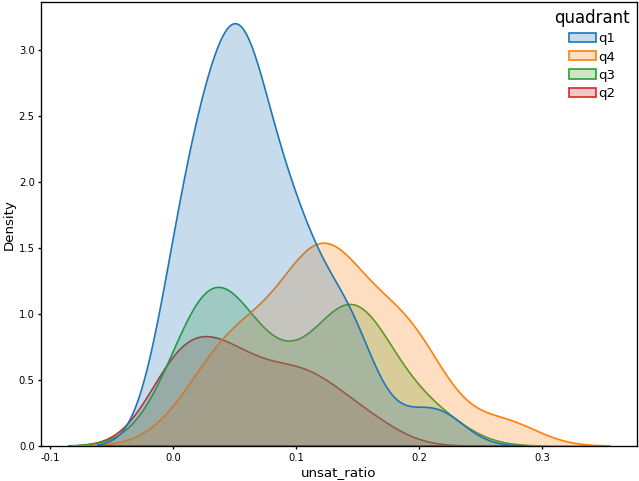

In [514]:
# fig, ax = plt.subplots(dpi=150, figsize=(4, 3))
sns.kdeplot(
    data=edf, x='unsat_ratio', hue='quadrant', fill=True,# kind='kde',

)
# sns.histplot(data=edf, x='')

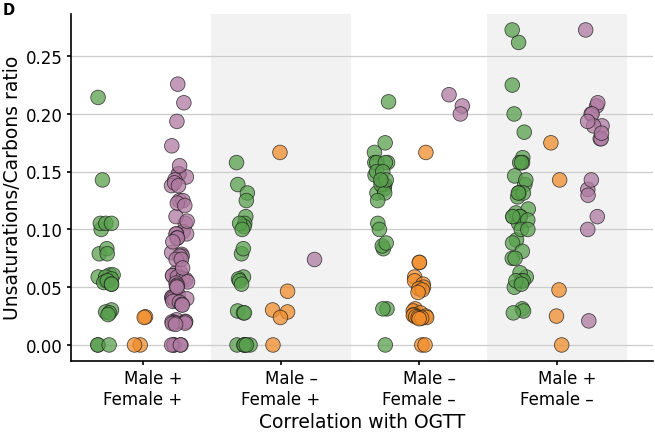

In [553]:
order = ['q1', 'q2', 'q3', 'q4']
order_label = ['    Male +\nFemale +', '    Male –\nFemale +', 
               '    Male –\nFemale –', '    Male +\nFemale –']
fig, ax = plt.subplots(dpi=150, figsize=(5,3.))
sns.stripplot(
    data=edf.loc[edf['superclass'] != 'Sterol Lipid'], x='quadrant', y='unsat_ratio', 
    hue='superclass', palette=colors,
    order=order,
    jitter=0.18, size=7, alpha=0.75,
    linewidth=src.plots.POINT_LW, edgecolor=src.plots.POINT_EC,
#     size=3.5,
    dodge=True,
    zorder=2,
)
# sns.violinplot(
#     data=edf.loc[edf['superclass'] != 'Sterol Lipid'], x='quadrant', y='unsat_ratio', 
# #     hue='superclass', palette=colors, dodge=True,
#     ax=ax, zorder=0,
# #     split=True,
# )
ax.axvspan(0.5, 1.5, zorder=0, color='0.95')
ax.axvspan(2.5, 3.5, zorder=0, color='0.95')
ax.set_xticks([0, 1, 2, 3], order_label, fontsize=8, ha='center', )
ax.tick_params(axis='y', labelsize=8)

# ax.set_ylabel(None)
ax.set_xlabel('Correlation with OGTT', fontsize=9)
# ax.set_title('Unsaturations/Carbons ratio', loc='left', va='top')
ax.set_ylabel('Unsaturations/Carbons ratio', fontsize=9)
ax.grid(axis='y', lw=src.plots.GRID_LW, color=src.plots.GRID_LIGHT_COLOR)
ax.set_axisbelow(True)
# ax.legend(loc=(1.01, 0), title='Lipid class')
ax.legend().remove()
offset = 0.266
# src.plots.annotate_point(xy=(3 + offset, 18/66), text='TG 66:18', xytext=(0, -7),
#                          ax=ax, zorder=1, fontsize=8, bbox_pad=2)

sns.despine()
bb = src.plots.tight_bbox(ax)
ax.text(x=bb.x0, y=bb.y1, s='D', 
        fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)

plt.savefig('../reports/figures/Figure7/Fig7_quadrant_enrichment.pdf', bbox_inches='tight', dpi=300)

# Perform ANOVA to see if the 4 quadrants have significantly different unsat/carbon ratio 

In [554]:
ldf = edf.loc[(edf['molec_class'] == 'TG') & (edf['quadrant']!='q2')]  # TG
# ldf = edf.loc[(edf['superclass'] == 'Phospholipid')]           # Phospholipids
# ldf = edf.loc[(edf['superclass'] == 'Sphingolipid') & (edf['quadrant'] != 'q1')]  # Sphingos
statsmodels.stats.multicomp.MultiComparison(
    data=ldf['unsat_ratio'], groups=ldf['quadrant'],
).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
q1,q3,0.1328,0.0002,0.0577,0.208,True
q1,q4,0.0921,0.0,0.0576,0.1267,True
q3,q4,-0.0407,0.4462,-0.1204,0.039,False


## Mixed effects formulation 

In [467]:
mdf = edf[['unsat_ratio', 'quadrant', 'superclass']]
mdf = mdf.loc[mdf['superclass'] != 'Sterol Lipid']
mlm = sm.formula.mixedlm(
    'unsat_ratio ~ quadrant', data=mdf, groups='superclass',
).fit(reml=True)
mlm.summary()

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: unsat_ratio
No. Observations: 124     Method:             REML       
No. Groups:       3       Scale:              0.0030     
Min. group size:  15      Log-Likelihood:     170.2537   
Max. group size:  68      Converged:          Yes        
Mean group size:  41.3                                   
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.040    0.024 1.630 0.103 -0.008  0.088
quadrant[T.q2]   0.031    0.020 1.543 0.123 -0.008  0.069
quadrant[T.q3]   0.080    0.018 4.385 0.000  0.044  0.115
quadrant[T.q4]   0.092    0.014 6.547 0.000  0.065  0.120
superclass Var   0.001    0.031                          
=========================================================

"""

In [564]:
data.loc['l_679', data_cols].to_frame().corrwith(fg['ogtt'].to_frame())

ogtt   NaN
dtype: float64

In [565]:
from scipy.stats import pearsonr

In [579]:
pearsonr(data.loc['l_679', data_cols], fg.loc[fg['original'], 'ogtt'].drop('1091_9_FBG'))

(0.473696485111207, 0.00015096854467108132)

<AxesSubplot:>

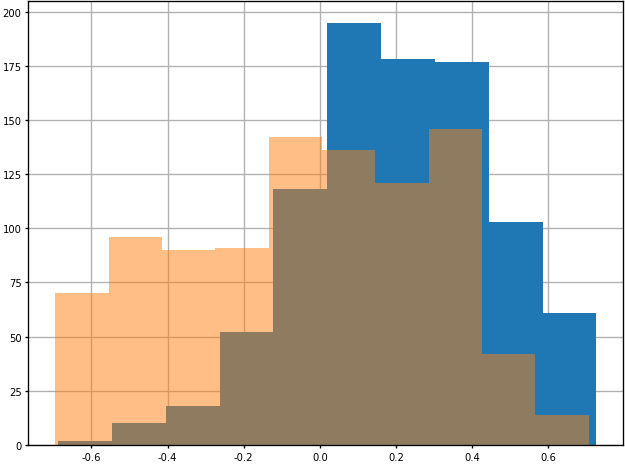

In [594]:
corrs = data.loc[data['Type']=='lipid', data_cols].T.corrwith(
    fg.loc[fg['original'], 'ogtt'].drop('1091_9_FBG')
)
corrs.hist()
val_corrs = vldata.loc[:, vldata_cols].T.corrwith(
    fg.loc[fg['validation'] & fg['quant_file'], 'ogtt']
)
val_corrs.hist(alpha=0.5)

In [598]:

fogtt

1731_30_RBG    41218.5
1731_31_RBG    41218.5
1731_32_RBG    41218.5
1742_32_RBG    25742.5
1742_33_RBG    25742.5
1742_34_RBG    25742.5
1743_31_RBG    35757.5
1743_32_RBG    35757.5
1743_33_RBG    35757.5
1746_30_RBG    29785.0
1746_31_RBG    29785.0
1746_32_RBG    29785.0
1748_29_RBG    37650.0
1748_30_RBG    37650.0
1748_31_RBG    37650.0
1754_30_RBG    31460.0
1754_31_RBG    31460.0
1754_32_RBG    31460.0
Name: ogtt, dtype: float64

<AxesSubplot:>

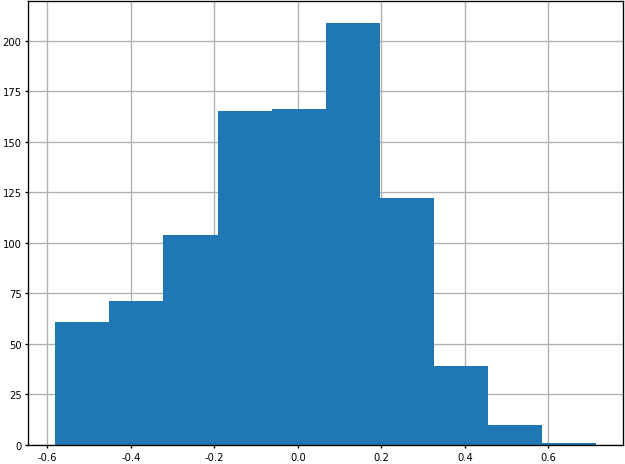

In [605]:
# vldata.loc[:, mogtt.index].T.corrwith(mogtt).hist()
vldata.loc[:, fogtt.index].T.corrwith(fogtt).hist()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
# 495 metabs
# 914 lipids

# 358 lipid IDs  556 un-ID
# 76 metab IDs   419 un-ID


,RT,m/z,polarity,ID,molec_class,Features Found,1700s_extract_blank_rep1,1700s_extract_blank_rep2,1700s_extract_blank_rep3,1700s_QCdil_025,...,qval_all_ogtt,log_qval_all_ogtt,qval_sex,log_qval_sex,qval_male_ogtt,log_qval_male_ogtt,qval_female_ogtt,log_qval_female_ogtt,m30ogttcorr,f30ogttcorr
vl_6,0.703,287.05676,+,Unidentified,Unidentified,51.0,13.891960,13.875591,13.951897,23.224394,...,0.140725,0.851627,4.371353e-01,0.359384,0.343273,0.464360,0.963560,0.016121,-0.503957,-0.350958
vl_11,0.706,247.09293,-,Unidentified,Unidentified,53.0,14.076268,14.972670,14.172502,23.709329,...,0.640618,0.193401,9.870740e-01,0.005650,0.497129,0.303531,0.963560,0.016121,-0.357440,-0.106675
vl_16,0.709,426.99759,-,Unidentified,Unidentified,19.0,13.754865,13.734585,13.909297,23.134954,...,0.159983,0.795925,4.436506e-01,0.352959,0.997526,0.001076,0.760507,0.118897,-0.001846,-0.637658
vl_19,0.715,293.09964,+,Unidentified,Unidentified,79.0,14.587984,15.851096,17.730969,27.486901,...,0.136573,0.864636,5.958339e-01,0.224875,0.611916,0.213308,0.760507,0.118897,-0.287841,-0.640648
vl_60,0.762,514.28418,-,Unidentified,Unidentified,22.0,17.274716,17.585457,17.806500,21.184131,...,0.014386,1.842047,3.147743e-07,6.502001,0.390678,0.408181,0.801227,0.096245,-0.523576,0.575212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vm_431,18.268,227.10133,-,Unidentified,Unidentified,NaN,15.345352,15.531085,16.040601,18.018756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vm_432,18.271,145.09734,-,Unidentified,Unidentified,NaN,16.049620,15.393615,17.859286,19.603447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vm_433,18.711,175.11894,+,Arginine,Amino acid,NaN,17.543679,18.393155,19.244330,21.916863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vm_434,18.724,131.08154,-,Unidentified,Unidentified,NaN,14.563069,14.741141,16.232415,18.359815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.reset_index

In [1698]:
sp = pd.DataFrame([[0, 10, 'act'], 
                   [10, 15, 'ls'], 
                   [15, 25, 'act'], 
                   [25, 30, 'ls'], 
                   
                   [0, 10, 'ls'], 
                   [10, 20, 'ls'],
                   [20, 25, 'ls'],
                   [25, 30, 'bx'], 
                   [30, 40, 'ls'],
                   [40, 50, 'ls'],
                  ],
                  columns=['from', 'to', 'form'])
sp['hole'] = ['res5'] * 4 + ['res10'] * 6
# sp = sp.sort_values([''])
sp = sp.sort_values(['hole', 'from']).reset_index(drop=True)

# def combine_rows(x):

# sp.rolling(3).apply(sum)

# sp.loc[sp['form'].shift(-1) == sp['form'], 'new from'] = sp.shift(-1)['to']
sp

,from,to,form,hole
0,0,10,ls,res10
1,10,20,ls,res10
2,20,25,ls,res10
3,25,30,bx,res10
4,30,40,ls,res10
5,40,50,ls,res10
6,0,10,act,res5
7,10,15,ls,res5
8,15,25,act,res5
9,25,30,ls,res5


In [1712]:
rows = []

for hole in sp['hole'].unique():
    
    
    df = sp.loc[sp['hole'] == hole].copy()
    display(df)
    
    prev_row = df.iloc[0]
    
    for i in range(len(df) - 1):
        current_row = df.iloc[i+1]
        
        if prev_row['form'] == current_row['form']:
            # make new row where from = prev_row['from'] and to = current_row['to']
            new_row = current_row.copy()
            new_row['from'] = prev_row['from']
#             rows.append(new_row)
            
            prev_row = new_row
            
        else:
            rows.append(current_row)
            prev_row = current_row
        
pd.DataFrame(rows)

,from,to,form,hole
0,0,10,ls,res10
1,10,20,ls,res10
2,20,25,ls,res10
3,25,30,bx,res10
4,30,40,ls,res10
5,40,50,ls,res10


,from,to,form,hole
6,0,10,act,res5
7,10,15,ls,res5
8,15,25,act,res5
9,25,30,ls,res5


,from,to,form,hole
3,25,30,bx,res10
4,30,40,ls,res10
7,10,15,ls,res5
8,15,25,act,res5
9,25,30,ls,res5


In [1705]:
import pandas as pd

df = pd.DataFrame({'label': ['A', 'A', 'B', 'B', 'C', 'C'],
                   'value': [1, 2, 3, 4, 5, 6],
                   'combine': [True, True, False, True, True, False]})

# define a function that combines rows if the 'combine' column is True
def combine_rows(group):
    if group['combine'].all():
        return group.sum()
    return group

# group the rows by the 'label' column and apply the 'combine_rows' function
df = df.groupby('label').apply(combine_rows)

# display the modified dataframe
df

0 combine label  value
label                                  
A     label     AA     NaN   NaN    NaN
      value      3     NaN   NaN    NaN
      combine    2     NaN   NaN    NaN
B     2        NaN   False     B    3.0
      3        NaN    True     B    4.0
C     4        NaN    True     C    5.0
      5        NaN   False     C    6.0

In [ ]:
for i in range(len(df) - 1):
    prev_row = df.iloc[i]
    current_row = df.iloc[i+1]
    if 

In [1653]:
sp.shift()

,from,to,form,hole
4,NaN,NaN,NaN,NaN
5,0.0,10.0,ls,res10
6,10.0,20.0,ls,res10
0,20.0,30.0,bx,res10
1,0.0,10.0,act,res5
2,10.0,15.0,ls,res5
3,15.0,25.0,act,res5


0    NaN
1     ls
2     ls
3     bx
4    act
5     ls
6    act
Name: form, dtype: object